## Image Generation using GAN(Generative Adversarial Networks)

GANs are deep neural network architectures comprised of two networks, pitting one against the other (thus the “adversarial”). It's potential is huge, because they can learn to mimic any distribution of data. That is, GANs can be taught to create worlds mysteriously similar to our own in any domain: images, music, speech, prose. They are robot artists in a sense, and their output is impressive – poignant even.

### How GANs work
One neural network, called the *generator*, generates new data instances, while the other, the *discriminator*, evaluates them for authenticity; i.e. the discriminator decides whether each instance of data it reviews belongs to the actual training dataset or not.

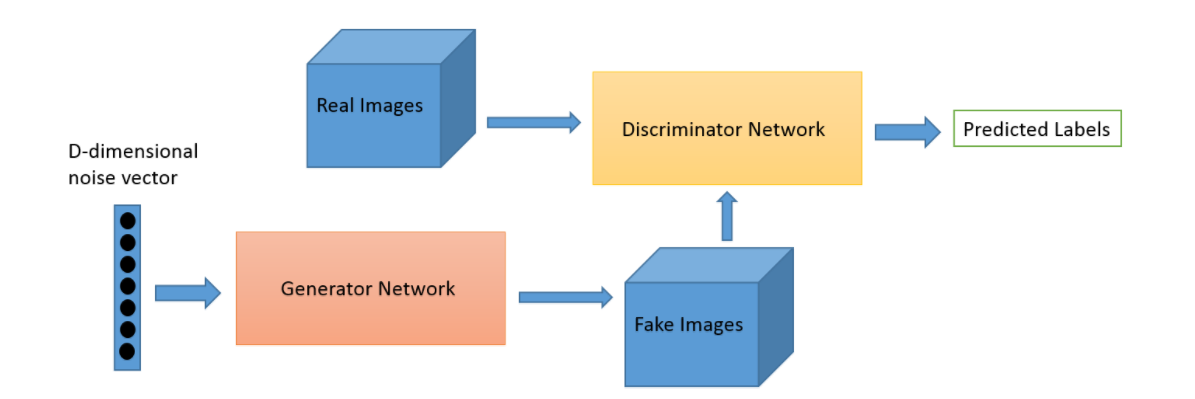

#### Here are the steps a GAN takes:
 - The generator takes in random numbers and returns an image
 - This generated image is fed into the discriminator alongside a stream of images taken from the actual dataset
 - he discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake
 
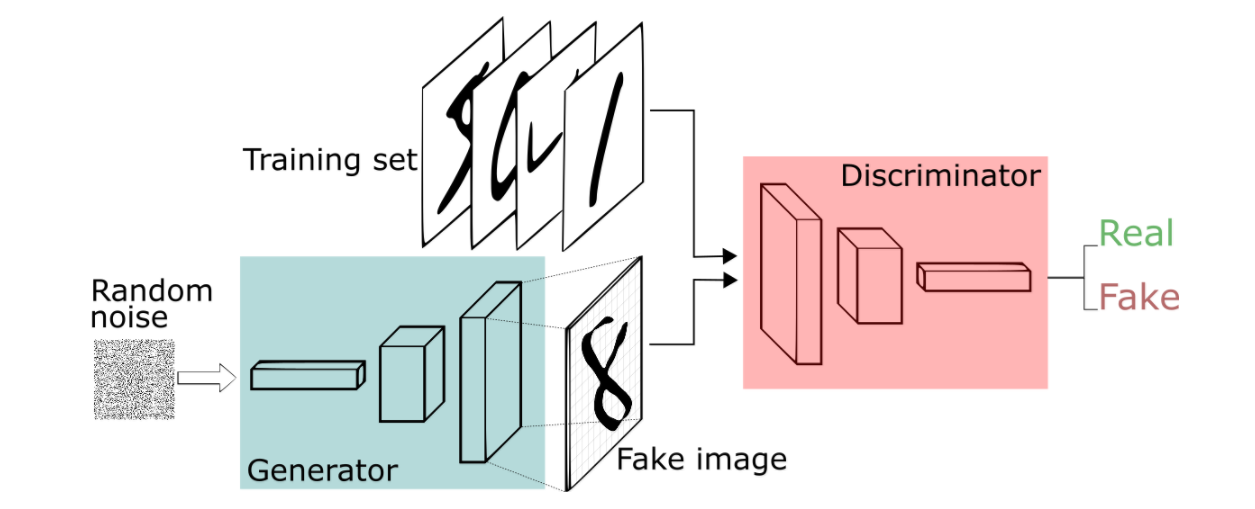

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class GAN():
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("C:\\Stuff\\NEU\\Big-Data Systems and Intelligent Analytics\\Project Data\\mnist_%d.png" % epoch)
        plt.close()

In [4]:
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

In [5]:
    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

In [6]:
    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

In [7]:
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("C:\\Stuff\\NEU\\Big-Data Systems and Intelligent Analytics\\Project Data\\mnist_%d.png" % epoch)
        plt.close()

In [6]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, save_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\prashant\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.651147, acc.: 53.12%] [G loss: 0.525708]
1 [D loss: 0.493330, acc.: 65.62%] [G loss: 0.577570]
2 [D loss: 0.447298, acc.: 65.62%] [G loss: 0.695001]
3 [D loss: 0.313172, acc.: 84.38%] [G loss: 0.831560]
4 [D loss: 0.324212, acc.: 78.12%] [G loss: 1.009502]
5 [D loss: 0.284868, acc.: 87.50%] [G loss: 1.145089]
6 [D loss: 0.178900, acc.: 100.00%] [G loss: 1.280760]
7 [D loss: 0.171911, acc.: 100.00%] [G loss: 1.362847]
8 [D loss: 0.173607, acc.: 100.00%] [G loss: 1.471134]
9 [D loss: 0.153278, acc.: 100.00%] [G loss: 1.504799]
10 [D loss: 0.120517, acc.: 100.00%] [G loss: 1.644464]
11 [D loss: 0.133397, acc.: 100.00%] [G loss: 1.784904]
12 [D loss: 0.129453, acc.: 100.00%] [G loss: 1.833109]
13 [D loss: 0.101786, acc.: 100.00%] [G loss: 1.934035]
14 [D loss: 0.103388, acc.: 100.00%] [G loss: 2.054257]
15 [D loss: 0.091556, acc.: 100.00%] [G loss: 2.046341]
16 [D loss: 0.080179, acc.: 100.00%] [G loss: 2.155531]
17 [D loss: 0.070501, acc.: 100.00%] [G loss: 2.223639]
18 [D lo

149 [D loss: 0.778638, acc.: 65.62%] [G loss: 2.912547]
150 [D loss: 0.075787, acc.: 100.00%] [G loss: 3.694619]
151 [D loss: 0.192767, acc.: 93.75%] [G loss: 3.838442]
152 [D loss: 0.192244, acc.: 93.75%] [G loss: 3.393225]
153 [D loss: 0.104758, acc.: 96.88%] [G loss: 3.388538]
154 [D loss: 0.264967, acc.: 90.62%] [G loss: 3.194251]
155 [D loss: 0.130334, acc.: 96.88%] [G loss: 3.117933]
156 [D loss: 0.189110, acc.: 93.75%] [G loss: 3.071467]
157 [D loss: 0.207517, acc.: 96.88%] [G loss: 3.210710]
158 [D loss: 0.135079, acc.: 96.88%] [G loss: 2.873717]
159 [D loss: 0.152426, acc.: 93.75%] [G loss: 2.899893]
160 [D loss: 0.109839, acc.: 96.88%] [G loss: 3.053669]
161 [D loss: 0.273646, acc.: 84.38%] [G loss: 3.073660]
162 [D loss: 0.072120, acc.: 100.00%] [G loss: 2.991156]
163 [D loss: 0.212538, acc.: 93.75%] [G loss: 3.525675]
164 [D loss: 0.188638, acc.: 96.88%] [G loss: 2.637006]
165 [D loss: 0.266730, acc.: 87.50%] [G loss: 3.320642]
166 [D loss: 0.253386, acc.: 96.88%] [G loss: 

443 [D loss: 0.697396, acc.: 40.62%] [G loss: 0.658339]
444 [D loss: 0.685629, acc.: 46.88%] [G loss: 0.665635]
445 [D loss: 0.708181, acc.: 53.12%] [G loss: 0.647623]
446 [D loss: 0.669653, acc.: 53.12%] [G loss: 0.632169]
447 [D loss: 0.648687, acc.: 56.25%] [G loss: 0.650049]
448 [D loss: 0.687657, acc.: 53.12%] [G loss: 0.640030]
449 [D loss: 0.685605, acc.: 46.88%] [G loss: 0.646517]
450 [D loss: 0.651214, acc.: 43.75%] [G loss: 0.656439]
451 [D loss: 0.674183, acc.: 68.75%] [G loss: 0.663318]
452 [D loss: 0.696031, acc.: 46.88%] [G loss: 0.673182]
453 [D loss: 0.652247, acc.: 56.25%] [G loss: 0.668895]
454 [D loss: 0.703368, acc.: 34.38%] [G loss: 0.669667]
455 [D loss: 0.691063, acc.: 40.62%] [G loss: 0.649856]
456 [D loss: 0.668052, acc.: 50.00%] [G loss: 0.653020]
457 [D loss: 0.666236, acc.: 50.00%] [G loss: 0.661766]
458 [D loss: 0.704705, acc.: 40.62%] [G loss: 0.661791]
459 [D loss: 0.671653, acc.: 50.00%] [G loss: 0.686201]
460 [D loss: 0.676796, acc.: 46.88%] [G loss: 0.

592 [D loss: 0.631226, acc.: 65.62%] [G loss: 0.716648]
593 [D loss: 0.655018, acc.: 62.50%] [G loss: 0.748175]
594 [D loss: 0.637509, acc.: 62.50%] [G loss: 0.755590]
595 [D loss: 0.642574, acc.: 62.50%] [G loss: 0.720837]
596 [D loss: 0.620707, acc.: 68.75%] [G loss: 0.725681]
597 [D loss: 0.656600, acc.: 59.38%] [G loss: 0.723179]
598 [D loss: 0.636546, acc.: 62.50%] [G loss: 0.731448]
599 [D loss: 0.631044, acc.: 65.62%] [G loss: 0.739064]
600 [D loss: 0.624240, acc.: 59.38%] [G loss: 0.727964]
601 [D loss: 0.656934, acc.: 56.25%] [G loss: 0.720674]
602 [D loss: 0.648671, acc.: 50.00%] [G loss: 0.723424]
603 [D loss: 0.626875, acc.: 59.38%] [G loss: 0.719674]
604 [D loss: 0.668258, acc.: 53.12%] [G loss: 0.734749]
605 [D loss: 0.664645, acc.: 56.25%] [G loss: 0.712141]
606 [D loss: 0.627197, acc.: 56.25%] [G loss: 0.731249]
607 [D loss: 0.653890, acc.: 56.25%] [G loss: 0.733455]
608 [D loss: 0.707308, acc.: 37.50%] [G loss: 0.721799]
609 [D loss: 0.665456, acc.: 53.12%] [G loss: 0.

739 [D loss: 0.640693, acc.: 65.62%] [G loss: 0.731126]
740 [D loss: 0.570997, acc.: 84.38%] [G loss: 0.740794]
741 [D loss: 0.593857, acc.: 68.75%] [G loss: 0.796296]
742 [D loss: 0.611639, acc.: 75.00%] [G loss: 0.764165]
743 [D loss: 0.672394, acc.: 62.50%] [G loss: 0.745886]
744 [D loss: 0.608575, acc.: 68.75%] [G loss: 0.755521]
745 [D loss: 0.628609, acc.: 84.38%] [G loss: 0.777574]
746 [D loss: 0.590378, acc.: 71.88%] [G loss: 0.791485]
747 [D loss: 0.603402, acc.: 75.00%] [G loss: 0.806061]
748 [D loss: 0.556560, acc.: 78.12%] [G loss: 0.824348]
749 [D loss: 0.585167, acc.: 84.38%] [G loss: 0.812858]
750 [D loss: 0.627419, acc.: 62.50%] [G loss: 0.813142]
751 [D loss: 0.629376, acc.: 71.88%] [G loss: 0.777868]
752 [D loss: 0.619011, acc.: 75.00%] [G loss: 0.772210]
753 [D loss: 0.646901, acc.: 62.50%] [G loss: 0.809694]
754 [D loss: 0.612437, acc.: 68.75%] [G loss: 0.801172]
755 [D loss: 0.568307, acc.: 71.88%] [G loss: 0.804616]
756 [D loss: 0.615092, acc.: 71.88%] [G loss: 0.

886 [D loss: 0.682042, acc.: 56.25%] [G loss: 0.791638]
887 [D loss: 0.744570, acc.: 40.62%] [G loss: 0.787060]
888 [D loss: 0.627496, acc.: 62.50%] [G loss: 0.804627]
889 [D loss: 0.575914, acc.: 75.00%] [G loss: 0.860082]
890 [D loss: 0.640172, acc.: 59.38%] [G loss: 0.834175]
891 [D loss: 0.671964, acc.: 59.38%] [G loss: 0.795548]
892 [D loss: 0.688141, acc.: 50.00%] [G loss: 0.809370]
893 [D loss: 0.621436, acc.: 75.00%] [G loss: 0.798641]
894 [D loss: 0.623723, acc.: 65.62%] [G loss: 0.771850]
895 [D loss: 0.596603, acc.: 65.62%] [G loss: 0.815359]
896 [D loss: 0.650717, acc.: 65.62%] [G loss: 0.781435]
897 [D loss: 0.642950, acc.: 65.62%] [G loss: 0.798692]
898 [D loss: 0.681003, acc.: 46.88%] [G loss: 0.724160]
899 [D loss: 0.665990, acc.: 59.38%] [G loss: 0.729142]
900 [D loss: 0.642853, acc.: 50.00%] [G loss: 0.720762]
901 [D loss: 0.639217, acc.: 65.62%] [G loss: 0.721612]
902 [D loss: 0.647913, acc.: 65.62%] [G loss: 0.744508]
903 [D loss: 0.607861, acc.: 65.62%] [G loss: 0.

1032 [D loss: 0.621797, acc.: 71.88%] [G loss: 0.782323]
1033 [D loss: 0.634081, acc.: 65.62%] [G loss: 0.763342]
1034 [D loss: 0.635155, acc.: 62.50%] [G loss: 0.749016]
1035 [D loss: 0.602627, acc.: 75.00%] [G loss: 0.742507]
1036 [D loss: 0.719593, acc.: 40.62%] [G loss: 0.806956]
1037 [D loss: 0.576582, acc.: 84.38%] [G loss: 0.800939]
1038 [D loss: 0.612158, acc.: 68.75%] [G loss: 0.834352]
1039 [D loss: 0.634215, acc.: 65.62%] [G loss: 0.807206]
1040 [D loss: 0.626621, acc.: 71.88%] [G loss: 0.803084]
1041 [D loss: 0.626550, acc.: 56.25%] [G loss: 0.826757]
1042 [D loss: 0.649892, acc.: 65.62%] [G loss: 0.846915]
1043 [D loss: 0.569018, acc.: 65.62%] [G loss: 0.861000]
1044 [D loss: 0.670351, acc.: 50.00%] [G loss: 0.821181]
1045 [D loss: 0.645863, acc.: 59.38%] [G loss: 0.813360]
1046 [D loss: 0.634883, acc.: 62.50%] [G loss: 0.815485]
1047 [D loss: 0.677043, acc.: 46.88%] [G loss: 0.848001]
1048 [D loss: 0.664748, acc.: 62.50%] [G loss: 0.863599]
1049 [D loss: 0.606752, acc.: 8

1176 [D loss: 0.580173, acc.: 78.12%] [G loss: 0.826021]
1177 [D loss: 0.542476, acc.: 84.38%] [G loss: 0.919426]
1178 [D loss: 0.592434, acc.: 68.75%] [G loss: 0.904901]
1179 [D loss: 0.548896, acc.: 68.75%] [G loss: 0.935284]
1180 [D loss: 0.626088, acc.: 59.38%] [G loss: 0.899449]
1181 [D loss: 0.590809, acc.: 65.62%] [G loss: 0.885389]
1182 [D loss: 0.624826, acc.: 75.00%] [G loss: 0.880081]
1183 [D loss: 0.616686, acc.: 65.62%] [G loss: 0.858057]
1184 [D loss: 0.618911, acc.: 65.62%] [G loss: 0.909310]
1185 [D loss: 0.609207, acc.: 65.62%] [G loss: 0.911302]
1186 [D loss: 0.603315, acc.: 62.50%] [G loss: 0.898190]
1187 [D loss: 0.691937, acc.: 59.38%] [G loss: 0.852610]
1188 [D loss: 0.594184, acc.: 65.62%] [G loss: 0.821514]
1189 [D loss: 0.651095, acc.: 62.50%] [G loss: 0.843996]
1190 [D loss: 0.626820, acc.: 62.50%] [G loss: 0.813424]
1191 [D loss: 0.726155, acc.: 53.12%] [G loss: 0.790604]
1192 [D loss: 0.652414, acc.: 59.38%] [G loss: 0.802029]
1193 [D loss: 0.681680, acc.: 5

1320 [D loss: 0.602122, acc.: 68.75%] [G loss: 0.824936]
1321 [D loss: 0.584412, acc.: 71.88%] [G loss: 0.845547]
1322 [D loss: 0.614919, acc.: 78.12%] [G loss: 0.812506]
1323 [D loss: 0.610584, acc.: 68.75%] [G loss: 0.872811]
1324 [D loss: 0.583862, acc.: 75.00%] [G loss: 0.874518]
1325 [D loss: 0.636334, acc.: 56.25%] [G loss: 0.872928]
1326 [D loss: 0.639945, acc.: 62.50%] [G loss: 0.776033]
1327 [D loss: 0.617295, acc.: 65.62%] [G loss: 0.835693]
1328 [D loss: 0.581531, acc.: 62.50%] [G loss: 0.833721]
1329 [D loss: 0.611700, acc.: 75.00%] [G loss: 0.813984]
1330 [D loss: 0.573962, acc.: 71.88%] [G loss: 0.855732]
1331 [D loss: 0.595786, acc.: 56.25%] [G loss: 0.894538]
1332 [D loss: 0.579432, acc.: 78.12%] [G loss: 0.879304]
1333 [D loss: 0.631832, acc.: 65.62%] [G loss: 0.881110]
1334 [D loss: 0.624738, acc.: 68.75%] [G loss: 0.853198]
1335 [D loss: 0.603892, acc.: 75.00%] [G loss: 0.797333]
1336 [D loss: 0.635390, acc.: 59.38%] [G loss: 0.793817]
1337 [D loss: 0.617073, acc.: 6

1607 [D loss: 0.623886, acc.: 65.62%] [G loss: 0.848756]
1608 [D loss: 0.540100, acc.: 78.12%] [G loss: 0.871317]
1609 [D loss: 0.588449, acc.: 71.88%] [G loss: 0.939510]
1610 [D loss: 0.660234, acc.: 62.50%] [G loss: 0.887888]
1611 [D loss: 0.565656, acc.: 78.12%] [G loss: 0.916496]
1612 [D loss: 0.560683, acc.: 78.12%] [G loss: 0.932896]
1613 [D loss: 0.622113, acc.: 71.88%] [G loss: 0.953462]
1614 [D loss: 0.574788, acc.: 81.25%] [G loss: 0.926822]
1615 [D loss: 0.603078, acc.: 75.00%] [G loss: 0.864624]
1616 [D loss: 0.646872, acc.: 59.38%] [G loss: 0.799540]
1617 [D loss: 0.683088, acc.: 65.62%] [G loss: 0.853659]
1618 [D loss: 0.585205, acc.: 62.50%] [G loss: 0.828334]
1619 [D loss: 0.643610, acc.: 62.50%] [G loss: 0.866715]
1620 [D loss: 0.567307, acc.: 71.88%] [G loss: 0.923585]
1621 [D loss: 0.630057, acc.: 71.88%] [G loss: 0.879779]
1622 [D loss: 0.621784, acc.: 62.50%] [G loss: 0.904009]
1623 [D loss: 0.574148, acc.: 75.00%] [G loss: 0.958620]
1624 [D loss: 0.680735, acc.: 5

1895 [D loss: 0.592377, acc.: 65.62%] [G loss: 0.860138]
1896 [D loss: 0.590751, acc.: 71.88%] [G loss: 0.846003]
1897 [D loss: 0.707004, acc.: 53.12%] [G loss: 0.845465]
1898 [D loss: 0.659535, acc.: 56.25%] [G loss: 0.825582]
1899 [D loss: 0.670666, acc.: 56.25%] [G loss: 0.910757]
1900 [D loss: 0.590661, acc.: 81.25%] [G loss: 0.897072]
1901 [D loss: 0.647487, acc.: 50.00%] [G loss: 0.861288]
1902 [D loss: 0.686037, acc.: 59.38%] [G loss: 0.828675]
1903 [D loss: 0.632669, acc.: 62.50%] [G loss: 0.842674]
1904 [D loss: 0.597325, acc.: 65.62%] [G loss: 0.883862]
1905 [D loss: 0.648685, acc.: 59.38%] [G loss: 0.846612]
1906 [D loss: 0.585589, acc.: 68.75%] [G loss: 0.938398]
1907 [D loss: 0.641622, acc.: 65.62%] [G loss: 0.987034]
1908 [D loss: 0.567134, acc.: 78.12%] [G loss: 0.976493]
1909 [D loss: 0.563139, acc.: 78.12%] [G loss: 0.899044]
1910 [D loss: 0.574487, acc.: 71.88%] [G loss: 0.931262]
1911 [D loss: 0.638913, acc.: 65.62%] [G loss: 0.859807]
1912 [D loss: 0.681549, acc.: 5

2039 [D loss: 0.591118, acc.: 71.88%] [G loss: 0.967740]
2040 [D loss: 0.541137, acc.: 78.12%] [G loss: 0.945868]
2041 [D loss: 0.657634, acc.: 59.38%] [G loss: 0.831653]
2042 [D loss: 0.598849, acc.: 84.38%] [G loss: 0.809006]
2043 [D loss: 0.606158, acc.: 68.75%] [G loss: 0.884064]
2044 [D loss: 0.526042, acc.: 75.00%] [G loss: 0.997311]
2045 [D loss: 0.621768, acc.: 68.75%] [G loss: 0.910695]
2046 [D loss: 0.607464, acc.: 68.75%] [G loss: 0.911555]
2047 [D loss: 0.653209, acc.: 65.62%] [G loss: 0.861005]
2048 [D loss: 0.611701, acc.: 68.75%] [G loss: 0.789122]
2049 [D loss: 0.566335, acc.: 75.00%] [G loss: 0.822324]
2050 [D loss: 0.618940, acc.: 68.75%] [G loss: 0.872022]
2051 [D loss: 0.583367, acc.: 68.75%] [G loss: 0.849021]
2052 [D loss: 0.668968, acc.: 59.38%] [G loss: 0.931333]
2053 [D loss: 0.553514, acc.: 78.12%] [G loss: 0.922676]
2054 [D loss: 0.560754, acc.: 78.12%] [G loss: 0.874170]
2055 [D loss: 0.650074, acc.: 71.88%] [G loss: 0.913146]
2056 [D loss: 0.608187, acc.: 6

2184 [D loss: 0.672598, acc.: 62.50%] [G loss: 0.769129]
2185 [D loss: 0.608981, acc.: 68.75%] [G loss: 0.767967]
2186 [D loss: 0.663628, acc.: 59.38%] [G loss: 0.847924]
2187 [D loss: 0.588660, acc.: 65.62%] [G loss: 0.878355]
2188 [D loss: 0.584908, acc.: 71.88%] [G loss: 0.915762]
2189 [D loss: 0.705207, acc.: 50.00%] [G loss: 0.873135]
2190 [D loss: 0.634846, acc.: 68.75%] [G loss: 0.875947]
2191 [D loss: 0.595342, acc.: 62.50%] [G loss: 0.933602]
2192 [D loss: 0.717791, acc.: 50.00%] [G loss: 0.901655]
2193 [D loss: 0.627886, acc.: 62.50%] [G loss: 0.862643]
2194 [D loss: 0.564411, acc.: 78.12%] [G loss: 0.919688]
2195 [D loss: 0.604936, acc.: 78.12%] [G loss: 0.889063]
2196 [D loss: 0.549976, acc.: 78.12%] [G loss: 0.972207]
2197 [D loss: 0.650002, acc.: 62.50%] [G loss: 0.901607]
2198 [D loss: 0.670455, acc.: 46.88%] [G loss: 0.825710]
2199 [D loss: 0.616773, acc.: 62.50%] [G loss: 0.857145]
2200 [D loss: 0.619074, acc.: 59.38%] [G loss: 0.873675]
2201 [D loss: 0.630174, acc.: 7

2328 [D loss: 0.641169, acc.: 68.75%] [G loss: 0.893414]
2329 [D loss: 0.554687, acc.: 78.12%] [G loss: 0.950683]
2330 [D loss: 0.552675, acc.: 78.12%] [G loss: 1.017100]
2331 [D loss: 0.640118, acc.: 71.88%] [G loss: 0.919866]
2332 [D loss: 0.692473, acc.: 53.12%] [G loss: 0.843277]
2333 [D loss: 0.623911, acc.: 68.75%] [G loss: 0.862418]
2334 [D loss: 0.624321, acc.: 59.38%] [G loss: 0.870845]
2335 [D loss: 0.598055, acc.: 65.62%] [G loss: 0.882099]
2336 [D loss: 0.568987, acc.: 78.12%] [G loss: 0.907773]
2337 [D loss: 0.552922, acc.: 75.00%] [G loss: 0.928455]
2338 [D loss: 0.642392, acc.: 62.50%] [G loss: 0.932502]
2339 [D loss: 0.585203, acc.: 75.00%] [G loss: 0.940194]
2340 [D loss: 0.615726, acc.: 71.88%] [G loss: 0.995339]
2341 [D loss: 0.698568, acc.: 53.12%] [G loss: 0.938013]
2342 [D loss: 0.655694, acc.: 59.38%] [G loss: 0.888380]
2343 [D loss: 0.654570, acc.: 59.38%] [G loss: 0.927902]
2344 [D loss: 0.578171, acc.: 78.12%] [G loss: 0.959912]
2345 [D loss: 0.621297, acc.: 6

2473 [D loss: 0.547666, acc.: 81.25%] [G loss: 0.897780]
2474 [D loss: 0.600942, acc.: 71.88%] [G loss: 0.891465]
2475 [D loss: 0.733113, acc.: 53.12%] [G loss: 0.806560]
2476 [D loss: 0.667962, acc.: 53.12%] [G loss: 0.811198]
2477 [D loss: 0.595432, acc.: 65.62%] [G loss: 0.918853]
2478 [D loss: 0.596014, acc.: 75.00%] [G loss: 0.946792]
2479 [D loss: 0.596273, acc.: 71.88%] [G loss: 0.895963]
2480 [D loss: 0.609130, acc.: 75.00%] [G loss: 0.862307]
2481 [D loss: 0.733737, acc.: 50.00%] [G loss: 0.963350]
2482 [D loss: 0.624473, acc.: 65.62%] [G loss: 0.898817]
2483 [D loss: 0.694760, acc.: 56.25%] [G loss: 0.868073]
2484 [D loss: 0.630473, acc.: 59.38%] [G loss: 0.902243]
2485 [D loss: 0.648981, acc.: 62.50%] [G loss: 0.889927]
2486 [D loss: 0.608073, acc.: 75.00%] [G loss: 0.870876]
2487 [D loss: 0.653750, acc.: 62.50%] [G loss: 0.821217]
2488 [D loss: 0.615855, acc.: 59.38%] [G loss: 0.918818]
2489 [D loss: 0.559535, acc.: 75.00%] [G loss: 0.864155]
2490 [D loss: 0.665990, acc.: 6

2619 [D loss: 0.580554, acc.: 71.88%] [G loss: 0.853893]
2620 [D loss: 0.680588, acc.: 59.38%] [G loss: 0.897192]
2621 [D loss: 0.723765, acc.: 43.75%] [G loss: 0.901843]
2622 [D loss: 0.604140, acc.: 65.62%] [G loss: 0.938929]
2623 [D loss: 0.562283, acc.: 81.25%] [G loss: 0.890869]
2624 [D loss: 0.565213, acc.: 71.88%] [G loss: 0.895328]
2625 [D loss: 0.610995, acc.: 75.00%] [G loss: 0.931337]
2626 [D loss: 0.749890, acc.: 37.50%] [G loss: 0.877196]
2627 [D loss: 0.570327, acc.: 71.88%] [G loss: 0.856683]
2628 [D loss: 0.668652, acc.: 56.25%] [G loss: 0.963689]
2629 [D loss: 0.474759, acc.: 84.38%] [G loss: 0.905999]
2630 [D loss: 0.660301, acc.: 56.25%] [G loss: 1.022105]
2631 [D loss: 0.677925, acc.: 56.25%] [G loss: 0.962890]
2632 [D loss: 0.658247, acc.: 56.25%] [G loss: 0.944890]
2633 [D loss: 0.589947, acc.: 62.50%] [G loss: 1.021132]
2634 [D loss: 0.709912, acc.: 59.38%] [G loss: 0.994990]
2635 [D loss: 0.591877, acc.: 62.50%] [G loss: 0.947725]
2636 [D loss: 0.652046, acc.: 6

2763 [D loss: 0.652373, acc.: 62.50%] [G loss: 0.932092]
2764 [D loss: 0.641129, acc.: 68.75%] [G loss: 0.956628]
2765 [D loss: 0.591938, acc.: 71.88%] [G loss: 0.906460]
2766 [D loss: 0.627863, acc.: 59.38%] [G loss: 0.921977]
2767 [D loss: 0.676404, acc.: 53.12%] [G loss: 0.965513]
2768 [D loss: 0.519296, acc.: 81.25%] [G loss: 0.944804]
2769 [D loss: 0.568108, acc.: 71.88%] [G loss: 0.992277]
2770 [D loss: 0.579863, acc.: 68.75%] [G loss: 0.928915]
2771 [D loss: 0.604263, acc.: 71.88%] [G loss: 0.862464]
2772 [D loss: 0.650764, acc.: 68.75%] [G loss: 0.828340]
2773 [D loss: 0.703620, acc.: 53.12%] [G loss: 0.822375]
2774 [D loss: 0.593197, acc.: 71.88%] [G loss: 0.867326]
2775 [D loss: 0.482309, acc.: 75.00%] [G loss: 0.935793]
2776 [D loss: 0.704429, acc.: 53.12%] [G loss: 0.909494]
2777 [D loss: 0.613066, acc.: 62.50%] [G loss: 1.000722]
2778 [D loss: 0.581356, acc.: 65.62%] [G loss: 0.956205]
2779 [D loss: 0.499075, acc.: 81.25%] [G loss: 0.968629]
2780 [D loss: 0.540686, acc.: 7

2908 [D loss: 0.627654, acc.: 68.75%] [G loss: 0.912618]
2909 [D loss: 0.585159, acc.: 75.00%] [G loss: 0.960908]
2910 [D loss: 0.683155, acc.: 68.75%] [G loss: 0.852606]
2911 [D loss: 0.685155, acc.: 56.25%] [G loss: 0.897478]
2912 [D loss: 0.629089, acc.: 71.88%] [G loss: 0.868696]
2913 [D loss: 0.613674, acc.: 68.75%] [G loss: 0.903115]
2914 [D loss: 0.584154, acc.: 78.12%] [G loss: 0.986819]
2915 [D loss: 0.592800, acc.: 78.12%] [G loss: 1.031121]
2916 [D loss: 0.593114, acc.: 75.00%] [G loss: 0.874000]
2917 [D loss: 0.541909, acc.: 71.88%] [G loss: 0.866731]
2918 [D loss: 0.667925, acc.: 68.75%] [G loss: 0.958892]
2919 [D loss: 0.519626, acc.: 81.25%] [G loss: 0.938135]
2920 [D loss: 0.546494, acc.: 78.12%] [G loss: 0.946455]
2921 [D loss: 0.718003, acc.: 43.75%] [G loss: 0.930501]
2922 [D loss: 0.612589, acc.: 62.50%] [G loss: 0.959828]
2923 [D loss: 0.555251, acc.: 65.62%] [G loss: 0.987142]
2924 [D loss: 0.582085, acc.: 65.62%] [G loss: 1.034565]
2925 [D loss: 0.627048, acc.: 6

3052 [D loss: 0.799044, acc.: 40.62%] [G loss: 0.909062]
3053 [D loss: 0.678907, acc.: 68.75%] [G loss: 0.986889]
3054 [D loss: 0.618556, acc.: 62.50%] [G loss: 0.993434]
3055 [D loss: 0.569869, acc.: 71.88%] [G loss: 0.959487]
3056 [D loss: 0.599425, acc.: 62.50%] [G loss: 0.942758]
3057 [D loss: 0.563228, acc.: 59.38%] [G loss: 0.905228]
3058 [D loss: 0.684281, acc.: 59.38%] [G loss: 0.865664]
3059 [D loss: 0.625758, acc.: 75.00%] [G loss: 0.840424]
3060 [D loss: 0.641659, acc.: 56.25%] [G loss: 0.765336]
3061 [D loss: 0.610841, acc.: 65.62%] [G loss: 0.836173]
3062 [D loss: 0.708888, acc.: 56.25%] [G loss: 0.841411]
3063 [D loss: 0.624304, acc.: 65.62%] [G loss: 0.837455]
3064 [D loss: 0.687292, acc.: 62.50%] [G loss: 0.964157]
3065 [D loss: 0.614497, acc.: 78.12%] [G loss: 0.906003]
3066 [D loss: 0.651586, acc.: 68.75%] [G loss: 0.835936]
3067 [D loss: 0.653405, acc.: 59.38%] [G loss: 0.909253]
3068 [D loss: 0.618444, acc.: 62.50%] [G loss: 0.813772]
3069 [D loss: 0.607086, acc.: 6

3196 [D loss: 0.595415, acc.: 68.75%] [G loss: 0.927516]
3197 [D loss: 0.667616, acc.: 50.00%] [G loss: 0.839850]
3198 [D loss: 0.577823, acc.: 65.62%] [G loss: 0.927240]
3199 [D loss: 0.587082, acc.: 71.88%] [G loss: 0.991108]
3200 [D loss: 0.725686, acc.: 62.50%] [G loss: 0.854504]
3201 [D loss: 0.671519, acc.: 59.38%] [G loss: 0.838244]
3202 [D loss: 0.565946, acc.: 75.00%] [G loss: 0.909909]
3203 [D loss: 0.721996, acc.: 56.25%] [G loss: 1.014398]
3204 [D loss: 0.802220, acc.: 40.62%] [G loss: 0.889678]
3205 [D loss: 0.630288, acc.: 65.62%] [G loss: 0.976385]
3206 [D loss: 0.617985, acc.: 62.50%] [G loss: 0.948427]
3207 [D loss: 0.656974, acc.: 59.38%] [G loss: 0.903075]
3208 [D loss: 0.614068, acc.: 62.50%] [G loss: 0.961597]
3209 [D loss: 0.707779, acc.: 56.25%] [G loss: 0.997948]
3210 [D loss: 0.636236, acc.: 65.62%] [G loss: 0.847250]
3211 [D loss: 0.573657, acc.: 59.38%] [G loss: 0.912101]
3212 [D loss: 0.653006, acc.: 65.62%] [G loss: 0.954828]
3213 [D loss: 0.595522, acc.: 6

3341 [D loss: 0.609742, acc.: 71.88%] [G loss: 0.886318]
3342 [D loss: 0.626876, acc.: 62.50%] [G loss: 0.972604]
3343 [D loss: 0.653012, acc.: 68.75%] [G loss: 0.936558]
3344 [D loss: 0.541800, acc.: 78.12%] [G loss: 0.952682]
3345 [D loss: 0.545650, acc.: 78.12%] [G loss: 0.978247]
3346 [D loss: 0.582181, acc.: 75.00%] [G loss: 0.977883]
3347 [D loss: 0.548263, acc.: 78.12%] [G loss: 0.946239]
3348 [D loss: 0.695355, acc.: 59.38%] [G loss: 0.968018]
3349 [D loss: 0.680230, acc.: 56.25%] [G loss: 0.847503]
3350 [D loss: 0.728890, acc.: 59.38%] [G loss: 0.842026]
3351 [D loss: 0.664162, acc.: 56.25%] [G loss: 0.869027]
3352 [D loss: 0.680056, acc.: 62.50%] [G loss: 0.906815]
3353 [D loss: 0.610326, acc.: 71.88%] [G loss: 0.901834]
3354 [D loss: 0.646589, acc.: 59.38%] [G loss: 0.816602]
3355 [D loss: 0.613105, acc.: 68.75%] [G loss: 0.939853]
3356 [D loss: 0.718498, acc.: 53.12%] [G loss: 0.828736]
3357 [D loss: 0.633573, acc.: 62.50%] [G loss: 0.882023]
3358 [D loss: 0.709232, acc.: 4

3485 [D loss: 0.576746, acc.: 78.12%] [G loss: 0.979471]
3486 [D loss: 0.607223, acc.: 65.62%] [G loss: 0.948995]
3487 [D loss: 0.613346, acc.: 65.62%] [G loss: 0.961660]
3488 [D loss: 0.658865, acc.: 65.62%] [G loss: 0.916808]
3489 [D loss: 0.630628, acc.: 71.88%] [G loss: 0.846309]
3490 [D loss: 0.605594, acc.: 68.75%] [G loss: 0.890565]
3491 [D loss: 0.631103, acc.: 68.75%] [G loss: 0.831643]
3492 [D loss: 0.633575, acc.: 78.12%] [G loss: 0.863453]
3493 [D loss: 0.517575, acc.: 81.25%] [G loss: 0.941583]
3494 [D loss: 0.662320, acc.: 68.75%] [G loss: 0.883714]
3495 [D loss: 0.708896, acc.: 50.00%] [G loss: 0.861429]
3496 [D loss: 0.638377, acc.: 65.62%] [G loss: 0.845148]
3497 [D loss: 0.653153, acc.: 68.75%] [G loss: 0.838066]
3498 [D loss: 0.734097, acc.: 53.12%] [G loss: 0.882235]
3499 [D loss: 0.679306, acc.: 56.25%] [G loss: 0.878825]
3500 [D loss: 0.676934, acc.: 53.12%] [G loss: 0.944969]
3501 [D loss: 0.623654, acc.: 71.88%] [G loss: 0.880893]
3502 [D loss: 0.594073, acc.: 7

3630 [D loss: 0.721575, acc.: 53.12%] [G loss: 0.861196]
3631 [D loss: 0.740533, acc.: 50.00%] [G loss: 0.972113]
3632 [D loss: 0.631016, acc.: 65.62%] [G loss: 0.865668]
3633 [D loss: 0.649942, acc.: 56.25%] [G loss: 0.920773]
3634 [D loss: 0.692732, acc.: 46.88%] [G loss: 0.863178]
3635 [D loss: 0.635836, acc.: 68.75%] [G loss: 0.925183]
3636 [D loss: 0.639411, acc.: 62.50%] [G loss: 0.887941]
3637 [D loss: 0.625666, acc.: 62.50%] [G loss: 0.919523]
3638 [D loss: 0.556228, acc.: 78.12%] [G loss: 0.871737]
3639 [D loss: 0.637638, acc.: 62.50%] [G loss: 0.893588]
3640 [D loss: 0.603031, acc.: 68.75%] [G loss: 0.886477]
3641 [D loss: 0.596701, acc.: 65.62%] [G loss: 0.879969]
3642 [D loss: 0.639072, acc.: 62.50%] [G loss: 0.858481]
3643 [D loss: 0.632745, acc.: 62.50%] [G loss: 0.868973]
3644 [D loss: 0.661337, acc.: 68.75%] [G loss: 0.845497]
3645 [D loss: 0.598013, acc.: 68.75%] [G loss: 0.907100]
3646 [D loss: 0.630995, acc.: 53.12%] [G loss: 0.983881]
3647 [D loss: 0.551169, acc.: 7

3774 [D loss: 0.731508, acc.: 59.38%] [G loss: 0.943003]
3775 [D loss: 0.692730, acc.: 59.38%] [G loss: 0.835208]
3776 [D loss: 0.596164, acc.: 65.62%] [G loss: 0.790602]
3777 [D loss: 0.600010, acc.: 62.50%] [G loss: 0.870645]
3778 [D loss: 0.629443, acc.: 65.62%] [G loss: 0.823955]
3779 [D loss: 0.647245, acc.: 65.62%] [G loss: 0.964713]
3780 [D loss: 0.692787, acc.: 53.12%] [G loss: 0.913726]
3781 [D loss: 0.622258, acc.: 62.50%] [G loss: 0.836659]
3782 [D loss: 0.691396, acc.: 56.25%] [G loss: 0.835318]
3783 [D loss: 0.717934, acc.: 53.12%] [G loss: 0.917734]
3784 [D loss: 0.595994, acc.: 65.62%] [G loss: 0.886281]
3785 [D loss: 0.704098, acc.: 50.00%] [G loss: 0.913296]
3786 [D loss: 0.631083, acc.: 59.38%] [G loss: 0.751830]
3787 [D loss: 0.698587, acc.: 65.62%] [G loss: 0.848178]
3788 [D loss: 0.697480, acc.: 59.38%] [G loss: 0.870003]
3789 [D loss: 0.666290, acc.: 65.62%] [G loss: 0.857346]
3790 [D loss: 0.631060, acc.: 65.62%] [G loss: 0.945540]
3791 [D loss: 0.645534, acc.: 5

3919 [D loss: 0.698134, acc.: 56.25%] [G loss: 0.845030]
3920 [D loss: 0.609054, acc.: 75.00%] [G loss: 0.930709]
3921 [D loss: 0.646258, acc.: 68.75%] [G loss: 0.939702]
3922 [D loss: 0.579838, acc.: 71.88%] [G loss: 0.925168]
3923 [D loss: 0.570735, acc.: 71.88%] [G loss: 0.915057]
3924 [D loss: 0.649335, acc.: 62.50%] [G loss: 0.951471]
3925 [D loss: 0.633548, acc.: 62.50%] [G loss: 0.929480]
3926 [D loss: 0.737108, acc.: 53.12%] [G loss: 0.836857]
3927 [D loss: 0.716916, acc.: 50.00%] [G loss: 0.823024]
3928 [D loss: 0.649997, acc.: 59.38%] [G loss: 0.879766]
3929 [D loss: 0.656500, acc.: 53.12%] [G loss: 1.023504]
3930 [D loss: 0.655504, acc.: 50.00%] [G loss: 0.925192]
3931 [D loss: 0.700459, acc.: 56.25%] [G loss: 0.907225]
3932 [D loss: 0.625212, acc.: 71.88%] [G loss: 0.903988]
3933 [D loss: 0.663275, acc.: 59.38%] [G loss: 0.853909]
3934 [D loss: 0.728613, acc.: 43.75%] [G loss: 0.903918]
3935 [D loss: 0.667548, acc.: 59.38%] [G loss: 0.911416]
3936 [D loss: 0.750079, acc.: 4

4064 [D loss: 0.775644, acc.: 53.12%] [G loss: 0.981890]
4065 [D loss: 0.816976, acc.: 56.25%] [G loss: 0.899630]
4066 [D loss: 0.563360, acc.: 78.12%] [G loss: 0.837430]
4067 [D loss: 0.681311, acc.: 62.50%] [G loss: 0.788764]
4068 [D loss: 0.550859, acc.: 75.00%] [G loss: 0.832896]
4069 [D loss: 0.699214, acc.: 56.25%] [G loss: 0.876134]
4070 [D loss: 0.659261, acc.: 68.75%] [G loss: 0.975313]
4071 [D loss: 0.615527, acc.: 65.62%] [G loss: 0.973205]
4072 [D loss: 0.700329, acc.: 56.25%] [G loss: 0.998446]
4073 [D loss: 0.613959, acc.: 62.50%] [G loss: 0.832278]
4074 [D loss: 0.700629, acc.: 56.25%] [G loss: 0.907468]
4075 [D loss: 0.550322, acc.: 84.38%] [G loss: 0.851267]
4076 [D loss: 0.646187, acc.: 56.25%] [G loss: 0.900971]
4077 [D loss: 0.575465, acc.: 71.88%] [G loss: 0.840948]
4078 [D loss: 0.668668, acc.: 56.25%] [G loss: 0.905608]
4079 [D loss: 0.715544, acc.: 53.12%] [G loss: 0.857566]
4080 [D loss: 0.748475, acc.: 53.12%] [G loss: 0.854773]
4081 [D loss: 0.599808, acc.: 7

4209 [D loss: 0.619044, acc.: 68.75%] [G loss: 0.965158]
4210 [D loss: 0.758070, acc.: 53.12%] [G loss: 0.947111]
4211 [D loss: 0.714618, acc.: 50.00%] [G loss: 0.980895]
4212 [D loss: 0.652087, acc.: 53.12%] [G loss: 1.005706]
4213 [D loss: 0.672493, acc.: 62.50%] [G loss: 0.950325]
4214 [D loss: 0.691604, acc.: 53.12%] [G loss: 0.900712]
4215 [D loss: 0.714519, acc.: 50.00%] [G loss: 0.809757]
4216 [D loss: 0.537455, acc.: 81.25%] [G loss: 0.812777]
4217 [D loss: 0.595946, acc.: 68.75%] [G loss: 0.877794]
4218 [D loss: 0.629906, acc.: 65.62%] [G loss: 0.856014]
4219 [D loss: 0.654245, acc.: 65.62%] [G loss: 0.873412]
4220 [D loss: 0.641371, acc.: 68.75%] [G loss: 0.876078]
4221 [D loss: 0.677889, acc.: 68.75%] [G loss: 0.977598]
4222 [D loss: 0.607435, acc.: 68.75%] [G loss: 0.901584]
4223 [D loss: 0.647198, acc.: 62.50%] [G loss: 1.013974]
4224 [D loss: 0.644129, acc.: 62.50%] [G loss: 1.006359]
4225 [D loss: 0.568325, acc.: 75.00%] [G loss: 0.933494]
4226 [D loss: 0.588663, acc.: 6

4354 [D loss: 0.654306, acc.: 46.88%] [G loss: 0.909227]
4355 [D loss: 0.619067, acc.: 71.88%] [G loss: 0.851901]
4356 [D loss: 0.657718, acc.: 62.50%] [G loss: 0.883918]
4357 [D loss: 0.599031, acc.: 62.50%] [G loss: 0.903356]
4358 [D loss: 0.686482, acc.: 53.12%] [G loss: 0.920647]
4359 [D loss: 0.573683, acc.: 71.88%] [G loss: 0.885100]
4360 [D loss: 0.608398, acc.: 65.62%] [G loss: 0.978388]
4361 [D loss: 0.728551, acc.: 56.25%] [G loss: 0.960634]
4362 [D loss: 0.569911, acc.: 71.88%] [G loss: 0.947005]
4363 [D loss: 0.683973, acc.: 59.38%] [G loss: 1.000223]
4364 [D loss: 0.727870, acc.: 53.12%] [G loss: 1.093885]
4365 [D loss: 0.639621, acc.: 53.12%] [G loss: 1.044604]
4366 [D loss: 0.686619, acc.: 56.25%] [G loss: 0.931865]
4367 [D loss: 0.686163, acc.: 56.25%] [G loss: 0.826163]
4368 [D loss: 0.641296, acc.: 62.50%] [G loss: 0.847222]
4369 [D loss: 0.611704, acc.: 68.75%] [G loss: 0.830699]
4370 [D loss: 0.632477, acc.: 65.62%] [G loss: 0.843277]
4371 [D loss: 0.568190, acc.: 6

4500 [D loss: 0.606473, acc.: 62.50%] [G loss: 0.879137]
4501 [D loss: 0.677886, acc.: 53.12%] [G loss: 0.810837]
4502 [D loss: 0.647076, acc.: 75.00%] [G loss: 0.881527]
4503 [D loss: 0.645918, acc.: 65.62%] [G loss: 0.879429]
4504 [D loss: 0.684702, acc.: 56.25%] [G loss: 0.955870]
4505 [D loss: 0.631712, acc.: 65.62%] [G loss: 0.913284]
4506 [D loss: 0.578197, acc.: 68.75%] [G loss: 1.003604]
4507 [D loss: 0.611611, acc.: 71.88%] [G loss: 0.909277]
4508 [D loss: 0.696979, acc.: 59.38%] [G loss: 0.950119]
4509 [D loss: 0.642933, acc.: 65.62%] [G loss: 0.870596]
4510 [D loss: 0.628413, acc.: 71.88%] [G loss: 0.911457]
4511 [D loss: 0.668850, acc.: 53.12%] [G loss: 0.898133]
4512 [D loss: 0.577623, acc.: 68.75%] [G loss: 0.893195]
4513 [D loss: 0.746776, acc.: 53.12%] [G loss: 0.813805]
4514 [D loss: 0.716529, acc.: 50.00%] [G loss: 0.887804]
4515 [D loss: 0.686387, acc.: 62.50%] [G loss: 0.879058]
4516 [D loss: 0.589306, acc.: 65.62%] [G loss: 0.880671]
4517 [D loss: 0.618091, acc.: 6

4645 [D loss: 0.694118, acc.: 56.25%] [G loss: 0.886347]
4646 [D loss: 0.626238, acc.: 71.88%] [G loss: 0.840770]
4647 [D loss: 0.576979, acc.: 78.12%] [G loss: 0.881195]
4648 [D loss: 0.682592, acc.: 53.12%] [G loss: 0.851165]
4649 [D loss: 0.594891, acc.: 65.62%] [G loss: 0.832572]
4650 [D loss: 0.703477, acc.: 53.12%] [G loss: 0.894279]
4651 [D loss: 0.667671, acc.: 56.25%] [G loss: 0.909463]
4652 [D loss: 0.712227, acc.: 59.38%] [G loss: 0.922986]
4653 [D loss: 0.632979, acc.: 68.75%] [G loss: 0.845923]
4654 [D loss: 0.642508, acc.: 68.75%] [G loss: 0.934371]
4655 [D loss: 0.676763, acc.: 62.50%] [G loss: 0.849248]
4656 [D loss: 0.522126, acc.: 78.12%] [G loss: 0.893826]
4657 [D loss: 0.662928, acc.: 62.50%] [G loss: 0.842840]
4658 [D loss: 0.639194, acc.: 65.62%] [G loss: 0.880110]
4659 [D loss: 0.609834, acc.: 62.50%] [G loss: 0.864611]
4660 [D loss: 0.696445, acc.: 46.88%] [G loss: 0.800378]
4661 [D loss: 0.659227, acc.: 59.38%] [G loss: 0.988170]
4662 [D loss: 0.662958, acc.: 5

4789 [D loss: 0.686141, acc.: 59.38%] [G loss: 0.987212]
4790 [D loss: 0.583148, acc.: 75.00%] [G loss: 1.013139]
4791 [D loss: 0.701410, acc.: 46.88%] [G loss: 0.883433]
4792 [D loss: 0.615609, acc.: 62.50%] [G loss: 0.931194]
4793 [D loss: 0.629242, acc.: 65.62%] [G loss: 0.914602]
4794 [D loss: 0.750978, acc.: 50.00%] [G loss: 0.855306]
4795 [D loss: 0.697391, acc.: 56.25%] [G loss: 0.905867]
4796 [D loss: 0.698030, acc.: 56.25%] [G loss: 0.984951]
4797 [D loss: 0.626324, acc.: 68.75%] [G loss: 0.994264]
4798 [D loss: 0.661753, acc.: 62.50%] [G loss: 0.952675]
4799 [D loss: 0.626785, acc.: 71.88%] [G loss: 0.894654]
4800 [D loss: 0.647985, acc.: 59.38%] [G loss: 0.870409]
4801 [D loss: 0.639216, acc.: 50.00%] [G loss: 0.993420]
4802 [D loss: 0.607945, acc.: 65.62%] [G loss: 0.990019]
4803 [D loss: 0.608547, acc.: 65.62%] [G loss: 0.888414]
4804 [D loss: 0.644472, acc.: 62.50%] [G loss: 0.960758]
4805 [D loss: 0.741122, acc.: 50.00%] [G loss: 0.883754]
4806 [D loss: 0.642709, acc.: 5

4934 [D loss: 0.788314, acc.: 37.50%] [G loss: 0.903060]
4935 [D loss: 0.604903, acc.: 71.88%] [G loss: 0.839296]
4936 [D loss: 0.582107, acc.: 81.25%] [G loss: 0.928360]
4937 [D loss: 0.637466, acc.: 71.88%] [G loss: 0.979244]
4938 [D loss: 0.651564, acc.: 59.38%] [G loss: 0.973185]
4939 [D loss: 0.732829, acc.: 53.12%] [G loss: 0.834021]
4940 [D loss: 0.589885, acc.: 78.12%] [G loss: 0.868541]
4941 [D loss: 0.683532, acc.: 59.38%] [G loss: 0.927008]
4942 [D loss: 0.672612, acc.: 56.25%] [G loss: 0.896636]
4943 [D loss: 0.712597, acc.: 59.38%] [G loss: 0.934168]
4944 [D loss: 0.705288, acc.: 46.88%] [G loss: 1.052486]
4945 [D loss: 0.584628, acc.: 62.50%] [G loss: 0.991495]
4946 [D loss: 0.695424, acc.: 53.12%] [G loss: 0.989009]
4947 [D loss: 0.624463, acc.: 65.62%] [G loss: 0.936176]
4948 [D loss: 0.704152, acc.: 50.00%] [G loss: 0.891709]
4949 [D loss: 0.595042, acc.: 68.75%] [G loss: 0.921348]
4950 [D loss: 0.641469, acc.: 65.62%] [G loss: 0.863973]
4951 [D loss: 0.713458, acc.: 5

5078 [D loss: 0.653237, acc.: 62.50%] [G loss: 0.997172]
5079 [D loss: 0.765469, acc.: 46.88%] [G loss: 0.997474]
5080 [D loss: 0.693264, acc.: 56.25%] [G loss: 0.852100]
5081 [D loss: 0.597504, acc.: 65.62%] [G loss: 0.850381]
5082 [D loss: 0.596062, acc.: 71.88%] [G loss: 0.938924]
5083 [D loss: 0.606673, acc.: 71.88%] [G loss: 0.972713]
5084 [D loss: 0.685676, acc.: 43.75%] [G loss: 0.879297]
5085 [D loss: 0.617228, acc.: 62.50%] [G loss: 0.901706]
5086 [D loss: 0.637737, acc.: 62.50%] [G loss: 0.925055]
5087 [D loss: 0.686079, acc.: 53.12%] [G loss: 0.886325]
5088 [D loss: 0.632465, acc.: 59.38%] [G loss: 0.762347]
5089 [D loss: 0.678323, acc.: 59.38%] [G loss: 0.833100]
5090 [D loss: 0.749747, acc.: 43.75%] [G loss: 0.812148]
5091 [D loss: 0.590951, acc.: 68.75%] [G loss: 0.841627]
5092 [D loss: 0.672470, acc.: 59.38%] [G loss: 0.832117]
5093 [D loss: 0.641860, acc.: 62.50%] [G loss: 0.858593]
5094 [D loss: 0.636248, acc.: 62.50%] [G loss: 0.886112]
5095 [D loss: 0.634583, acc.: 5

5222 [D loss: 0.655663, acc.: 62.50%] [G loss: 0.847359]
5223 [D loss: 0.553527, acc.: 81.25%] [G loss: 0.841005]
5224 [D loss: 0.608888, acc.: 62.50%] [G loss: 0.889011]
5225 [D loss: 0.727859, acc.: 56.25%] [G loss: 0.922335]
5226 [D loss: 0.694577, acc.: 56.25%] [G loss: 0.974954]
5227 [D loss: 0.600930, acc.: 75.00%] [G loss: 0.944830]
5228 [D loss: 0.694938, acc.: 59.38%] [G loss: 0.892453]
5229 [D loss: 0.776538, acc.: 40.62%] [G loss: 0.842401]
5230 [D loss: 0.662069, acc.: 59.38%] [G loss: 0.910001]
5231 [D loss: 0.699796, acc.: 59.38%] [G loss: 0.928588]
5232 [D loss: 0.545897, acc.: 75.00%] [G loss: 1.043824]
5233 [D loss: 0.684358, acc.: 59.38%] [G loss: 0.924548]
5234 [D loss: 0.537745, acc.: 71.88%] [G loss: 0.900073]
5235 [D loss: 0.684155, acc.: 46.88%] [G loss: 0.888325]
5236 [D loss: 0.660027, acc.: 65.62%] [G loss: 0.845981]
5237 [D loss: 0.651286, acc.: 68.75%] [G loss: 0.834732]
5238 [D loss: 0.569972, acc.: 78.12%] [G loss: 0.887275]
5239 [D loss: 0.662231, acc.: 6

5366 [D loss: 0.561569, acc.: 75.00%] [G loss: 0.808893]
5367 [D loss: 0.616782, acc.: 59.38%] [G loss: 0.860677]
5368 [D loss: 0.708365, acc.: 53.12%] [G loss: 0.921013]
5369 [D loss: 0.676012, acc.: 56.25%] [G loss: 0.872114]
5370 [D loss: 0.641596, acc.: 71.88%] [G loss: 0.857316]
5371 [D loss: 0.653355, acc.: 65.62%] [G loss: 0.902520]
5372 [D loss: 0.801896, acc.: 31.25%] [G loss: 0.895855]
5373 [D loss: 0.671898, acc.: 59.38%] [G loss: 0.915516]
5374 [D loss: 0.614167, acc.: 68.75%] [G loss: 0.907549]
5375 [D loss: 0.690416, acc.: 53.12%] [G loss: 0.869942]
5376 [D loss: 0.635298, acc.: 62.50%] [G loss: 0.880537]
5377 [D loss: 0.689024, acc.: 56.25%] [G loss: 0.864471]
5378 [D loss: 0.657662, acc.: 62.50%] [G loss: 0.881515]
5379 [D loss: 0.659213, acc.: 62.50%] [G loss: 0.909965]
5380 [D loss: 0.659466, acc.: 59.38%] [G loss: 0.868516]
5381 [D loss: 0.599095, acc.: 75.00%] [G loss: 0.795611]
5382 [D loss: 0.574862, acc.: 71.88%] [G loss: 0.858523]
5383 [D loss: 0.614751, acc.: 6

5510 [D loss: 0.710642, acc.: 59.38%] [G loss: 0.892948]
5511 [D loss: 0.649901, acc.: 62.50%] [G loss: 0.885211]
5512 [D loss: 0.642623, acc.: 59.38%] [G loss: 0.876877]
5513 [D loss: 0.730515, acc.: 43.75%] [G loss: 0.923885]
5514 [D loss: 0.688499, acc.: 53.12%] [G loss: 0.910577]
5515 [D loss: 0.685049, acc.: 56.25%] [G loss: 0.930494]
5516 [D loss: 0.691657, acc.: 59.38%] [G loss: 0.928345]
5517 [D loss: 0.614910, acc.: 59.38%] [G loss: 0.910393]
5518 [D loss: 0.761181, acc.: 50.00%] [G loss: 0.911106]
5519 [D loss: 0.680853, acc.: 59.38%] [G loss: 0.857315]
5520 [D loss: 0.613691, acc.: 71.88%] [G loss: 0.915231]
5521 [D loss: 0.725807, acc.: 53.12%] [G loss: 0.859900]
5522 [D loss: 0.632237, acc.: 65.62%] [G loss: 0.885632]
5523 [D loss: 0.625753, acc.: 65.62%] [G loss: 0.836377]
5524 [D loss: 0.708353, acc.: 50.00%] [G loss: 0.819552]
5525 [D loss: 0.629650, acc.: 59.38%] [G loss: 0.862968]
5526 [D loss: 0.637110, acc.: 56.25%] [G loss: 0.892724]
5527 [D loss: 0.622011, acc.: 5

5654 [D loss: 0.653736, acc.: 62.50%] [G loss: 0.866091]
5655 [D loss: 0.696133, acc.: 56.25%] [G loss: 0.800215]
5656 [D loss: 0.654927, acc.: 65.62%] [G loss: 0.833652]
5657 [D loss: 0.604927, acc.: 68.75%] [G loss: 0.875255]
5658 [D loss: 0.641430, acc.: 75.00%] [G loss: 0.868877]
5659 [D loss: 0.693831, acc.: 46.88%] [G loss: 0.856861]
5660 [D loss: 0.642753, acc.: 65.62%] [G loss: 0.888110]
5661 [D loss: 0.658419, acc.: 56.25%] [G loss: 0.896090]
5662 [D loss: 0.755744, acc.: 53.12%] [G loss: 0.886513]
5663 [D loss: 0.602287, acc.: 78.12%] [G loss: 0.856221]
5664 [D loss: 0.765588, acc.: 43.75%] [G loss: 0.781474]
5665 [D loss: 0.614771, acc.: 68.75%] [G loss: 0.883088]
5666 [D loss: 0.676159, acc.: 59.38%] [G loss: 0.895864]
5667 [D loss: 0.650033, acc.: 65.62%] [G loss: 0.897671]
5668 [D loss: 0.689526, acc.: 53.12%] [G loss: 0.885748]
5669 [D loss: 0.616259, acc.: 65.62%] [G loss: 0.877832]
5670 [D loss: 0.595669, acc.: 71.88%] [G loss: 0.869535]
5671 [D loss: 0.522189, acc.: 8

5940 [D loss: 0.685219, acc.: 56.25%] [G loss: 0.798614]
5941 [D loss: 0.658074, acc.: 56.25%] [G loss: 0.880806]
5942 [D loss: 0.674298, acc.: 53.12%] [G loss: 0.984089]
5943 [D loss: 0.727127, acc.: 53.12%] [G loss: 0.879384]
5944 [D loss: 0.723279, acc.: 50.00%] [G loss: 0.857108]
5945 [D loss: 0.667907, acc.: 56.25%] [G loss: 0.945025]
5946 [D loss: 0.656358, acc.: 62.50%] [G loss: 1.042527]
5947 [D loss: 0.660201, acc.: 59.38%] [G loss: 0.976367]
5948 [D loss: 0.611077, acc.: 65.62%] [G loss: 0.917004]
5949 [D loss: 0.630146, acc.: 65.62%] [G loss: 0.857643]
5950 [D loss: 0.665757, acc.: 56.25%] [G loss: 0.841458]
5951 [D loss: 0.660303, acc.: 65.62%] [G loss: 0.838992]
5952 [D loss: 0.720517, acc.: 53.12%] [G loss: 0.851281]
5953 [D loss: 0.636158, acc.: 68.75%] [G loss: 0.856424]
5954 [D loss: 0.624850, acc.: 62.50%] [G loss: 0.933283]
5955 [D loss: 0.659896, acc.: 62.50%] [G loss: 0.917301]
5956 [D loss: 0.659240, acc.: 59.38%] [G loss: 0.931898]
5957 [D loss: 0.747364, acc.: 5

6085 [D loss: 0.647704, acc.: 68.75%] [G loss: 0.899872]
6086 [D loss: 0.695476, acc.: 46.88%] [G loss: 0.832885]
6087 [D loss: 0.561963, acc.: 81.25%] [G loss: 0.913327]
6088 [D loss: 0.579080, acc.: 65.62%] [G loss: 0.972056]
6089 [D loss: 0.699394, acc.: 53.12%] [G loss: 0.999235]
6090 [D loss: 0.553474, acc.: 71.88%] [G loss: 0.836905]
6091 [D loss: 0.671188, acc.: 53.12%] [G loss: 0.869738]
6092 [D loss: 0.786246, acc.: 43.75%] [G loss: 0.963046]
6093 [D loss: 0.694439, acc.: 56.25%] [G loss: 0.860265]
6094 [D loss: 0.716643, acc.: 37.50%] [G loss: 0.996945]
6095 [D loss: 0.693770, acc.: 53.12%] [G loss: 1.003240]
6096 [D loss: 0.657348, acc.: 59.38%] [G loss: 1.027457]
6097 [D loss: 0.642201, acc.: 59.38%] [G loss: 0.995238]
6098 [D loss: 0.614240, acc.: 62.50%] [G loss: 0.963870]
6099 [D loss: 0.676239, acc.: 56.25%] [G loss: 0.887243]
6100 [D loss: 0.686998, acc.: 56.25%] [G loss: 0.899148]
6101 [D loss: 0.603538, acc.: 71.88%] [G loss: 0.977521]
6102 [D loss: 0.684170, acc.: 5

6229 [D loss: 0.710542, acc.: 56.25%] [G loss: 0.862471]
6230 [D loss: 0.654234, acc.: 62.50%] [G loss: 0.937912]
6231 [D loss: 0.642117, acc.: 71.88%] [G loss: 0.894568]
6232 [D loss: 0.593152, acc.: 65.62%] [G loss: 0.799985]
6233 [D loss: 0.689226, acc.: 43.75%] [G loss: 0.827135]
6234 [D loss: 0.661920, acc.: 59.38%] [G loss: 0.897586]
6235 [D loss: 0.605473, acc.: 68.75%] [G loss: 0.869742]
6236 [D loss: 0.675388, acc.: 56.25%] [G loss: 0.885712]
6237 [D loss: 0.679023, acc.: 46.88%] [G loss: 0.843089]
6238 [D loss: 0.645521, acc.: 53.12%] [G loss: 0.875111]
6239 [D loss: 0.707174, acc.: 53.12%] [G loss: 0.873590]
6240 [D loss: 0.597644, acc.: 71.88%] [G loss: 0.928019]
6241 [D loss: 0.673012, acc.: 65.62%] [G loss: 0.902197]
6242 [D loss: 0.698530, acc.: 59.38%] [G loss: 0.869384]
6243 [D loss: 0.614045, acc.: 65.62%] [G loss: 0.899068]
6244 [D loss: 0.694339, acc.: 59.38%] [G loss: 0.898854]
6245 [D loss: 0.689850, acc.: 59.38%] [G loss: 0.897914]
6246 [D loss: 0.719705, acc.: 5

6375 [D loss: 0.612265, acc.: 53.12%] [G loss: 0.854171]
6376 [D loss: 0.650008, acc.: 59.38%] [G loss: 0.822309]
6377 [D loss: 0.682757, acc.: 59.38%] [G loss: 0.872134]
6378 [D loss: 0.659122, acc.: 65.62%] [G loss: 0.826426]
6379 [D loss: 0.703761, acc.: 62.50%] [G loss: 0.798644]
6380 [D loss: 0.721308, acc.: 43.75%] [G loss: 0.848590]
6381 [D loss: 0.614879, acc.: 71.88%] [G loss: 0.906207]
6382 [D loss: 0.702962, acc.: 62.50%] [G loss: 0.900594]
6383 [D loss: 0.668181, acc.: 59.38%] [G loss: 0.936663]
6384 [D loss: 0.643821, acc.: 56.25%] [G loss: 0.937336]
6385 [D loss: 0.597016, acc.: 75.00%] [G loss: 0.960471]
6386 [D loss: 0.690484, acc.: 56.25%] [G loss: 0.867583]
6387 [D loss: 0.661529, acc.: 62.50%] [G loss: 0.887977]
6388 [D loss: 0.745692, acc.: 50.00%] [G loss: 0.893417]
6389 [D loss: 0.670845, acc.: 56.25%] [G loss: 0.919210]
6390 [D loss: 0.673098, acc.: 62.50%] [G loss: 0.867439]
6391 [D loss: 0.719081, acc.: 43.75%] [G loss: 0.880301]
6392 [D loss: 0.674870, acc.: 5

6520 [D loss: 0.712811, acc.: 56.25%] [G loss: 0.900290]
6521 [D loss: 0.646463, acc.: 53.12%] [G loss: 0.855264]
6522 [D loss: 0.682132, acc.: 62.50%] [G loss: 0.930781]
6523 [D loss: 0.657132, acc.: 53.12%] [G loss: 0.818873]
6524 [D loss: 0.572549, acc.: 75.00%] [G loss: 0.857745]
6525 [D loss: 0.684002, acc.: 50.00%] [G loss: 0.871990]
6526 [D loss: 0.618096, acc.: 65.62%] [G loss: 0.895511]
6527 [D loss: 0.642858, acc.: 56.25%] [G loss: 0.918615]
6528 [D loss: 0.601746, acc.: 71.88%] [G loss: 0.889587]
6529 [D loss: 0.647383, acc.: 59.38%] [G loss: 0.822101]
6530 [D loss: 0.669070, acc.: 68.75%] [G loss: 0.872563]
6531 [D loss: 0.677802, acc.: 46.88%] [G loss: 0.867278]
6532 [D loss: 0.741193, acc.: 43.75%] [G loss: 0.823328]
6533 [D loss: 0.641182, acc.: 68.75%] [G loss: 0.819439]
6534 [D loss: 0.624388, acc.: 59.38%] [G loss: 0.881263]
6535 [D loss: 0.726985, acc.: 56.25%] [G loss: 0.846564]
6536 [D loss: 0.624872, acc.: 71.88%] [G loss: 0.858346]
6537 [D loss: 0.642642, acc.: 6

6664 [D loss: 0.736965, acc.: 46.88%] [G loss: 0.814340]
6665 [D loss: 0.613373, acc.: 75.00%] [G loss: 0.799658]
6666 [D loss: 0.697581, acc.: 59.38%] [G loss: 0.819742]
6667 [D loss: 0.669380, acc.: 56.25%] [G loss: 0.818933]
6668 [D loss: 0.724782, acc.: 46.88%] [G loss: 0.869045]
6669 [D loss: 0.677071, acc.: 56.25%] [G loss: 0.835995]
6670 [D loss: 0.662473, acc.: 65.62%] [G loss: 0.907044]
6671 [D loss: 0.643690, acc.: 68.75%] [G loss: 0.773144]
6672 [D loss: 0.588263, acc.: 68.75%] [G loss: 0.908635]
6673 [D loss: 0.590841, acc.: 78.12%] [G loss: 0.946580]
6674 [D loss: 0.679693, acc.: 56.25%] [G loss: 0.898308]
6675 [D loss: 0.722529, acc.: 50.00%] [G loss: 0.879592]
6676 [D loss: 0.730279, acc.: 53.12%] [G loss: 0.880521]
6677 [D loss: 0.630181, acc.: 62.50%] [G loss: 0.921627]
6678 [D loss: 0.746202, acc.: 46.88%] [G loss: 0.842147]
6679 [D loss: 0.672486, acc.: 56.25%] [G loss: 0.964870]
6680 [D loss: 0.586704, acc.: 71.88%] [G loss: 0.948496]
6681 [D loss: 0.628420, acc.: 6

6810 [D loss: 0.679923, acc.: 56.25%] [G loss: 0.786712]
6811 [D loss: 0.642044, acc.: 62.50%] [G loss: 0.888791]
6812 [D loss: 0.669565, acc.: 59.38%] [G loss: 0.946467]
6813 [D loss: 0.646530, acc.: 59.38%] [G loss: 0.842420]
6814 [D loss: 0.705297, acc.: 56.25%] [G loss: 0.870542]
6815 [D loss: 0.609972, acc.: 71.88%] [G loss: 0.855873]
6816 [D loss: 0.705414, acc.: 53.12%] [G loss: 0.855928]
6817 [D loss: 0.621375, acc.: 62.50%] [G loss: 0.803927]
6818 [D loss: 0.703445, acc.: 56.25%] [G loss: 0.791441]
6819 [D loss: 0.710103, acc.: 50.00%] [G loss: 0.841808]
6820 [D loss: 0.615997, acc.: 71.88%] [G loss: 0.890334]
6821 [D loss: 0.730470, acc.: 59.38%] [G loss: 0.858309]
6822 [D loss: 0.698169, acc.: 59.38%] [G loss: 0.874899]
6823 [D loss: 0.616533, acc.: 65.62%] [G loss: 0.865655]
6824 [D loss: 0.690354, acc.: 62.50%] [G loss: 0.869986]
6825 [D loss: 0.683341, acc.: 68.75%] [G loss: 0.893409]
6826 [D loss: 0.647432, acc.: 62.50%] [G loss: 0.903844]
6827 [D loss: 0.581871, acc.: 7

6954 [D loss: 0.720342, acc.: 43.75%] [G loss: 0.853621]
6955 [D loss: 0.699750, acc.: 50.00%] [G loss: 0.839716]
6956 [D loss: 0.687698, acc.: 46.88%] [G loss: 0.952964]
6957 [D loss: 0.605759, acc.: 71.88%] [G loss: 0.898573]
6958 [D loss: 0.652272, acc.: 68.75%] [G loss: 0.893358]
6959 [D loss: 0.685499, acc.: 53.12%] [G loss: 0.811731]
6960 [D loss: 0.744761, acc.: 53.12%] [G loss: 0.900341]
6961 [D loss: 0.636428, acc.: 53.12%] [G loss: 0.871461]
6962 [D loss: 0.584250, acc.: 71.88%] [G loss: 0.956802]
6963 [D loss: 0.653973, acc.: 62.50%] [G loss: 0.896334]
6964 [D loss: 0.710220, acc.: 50.00%] [G loss: 0.837309]
6965 [D loss: 0.668048, acc.: 59.38%] [G loss: 0.863398]
6966 [D loss: 0.587219, acc.: 68.75%] [G loss: 0.823159]
6967 [D loss: 0.645182, acc.: 68.75%] [G loss: 0.797723]
6968 [D loss: 0.720630, acc.: 50.00%] [G loss: 0.804160]
6969 [D loss: 0.671117, acc.: 50.00%] [G loss: 0.989278]
6970 [D loss: 0.738358, acc.: 56.25%] [G loss: 0.908745]
6971 [D loss: 0.651884, acc.: 7

7100 [D loss: 0.767334, acc.: 62.50%] [G loss: 0.923317]
7101 [D loss: 0.691669, acc.: 53.12%] [G loss: 0.829968]
7102 [D loss: 0.592170, acc.: 81.25%] [G loss: 0.823449]
7103 [D loss: 0.606955, acc.: 59.38%] [G loss: 0.873655]
7104 [D loss: 0.622378, acc.: 71.88%] [G loss: 0.927333]
7105 [D loss: 0.755409, acc.: 43.75%] [G loss: 0.932163]
7106 [D loss: 0.697753, acc.: 50.00%] [G loss: 0.939372]
7107 [D loss: 0.709611, acc.: 53.12%] [G loss: 0.876834]
7108 [D loss: 0.616785, acc.: 65.62%] [G loss: 0.965114]
7109 [D loss: 0.647090, acc.: 53.12%] [G loss: 0.858969]
7110 [D loss: 0.690826, acc.: 56.25%] [G loss: 0.891341]
7111 [D loss: 0.656762, acc.: 65.62%] [G loss: 0.876038]
7112 [D loss: 0.680842, acc.: 53.12%] [G loss: 0.874018]
7113 [D loss: 0.632882, acc.: 62.50%] [G loss: 0.946265]
7114 [D loss: 0.689287, acc.: 50.00%] [G loss: 0.910792]
7115 [D loss: 0.629710, acc.: 71.88%] [G loss: 0.957315]
7116 [D loss: 0.653847, acc.: 62.50%] [G loss: 0.914866]
7117 [D loss: 0.656594, acc.: 5

7244 [D loss: 0.605156, acc.: 71.88%] [G loss: 0.948472]
7245 [D loss: 0.695567, acc.: 59.38%] [G loss: 0.882116]
7246 [D loss: 0.712648, acc.: 53.12%] [G loss: 0.898569]
7247 [D loss: 0.514802, acc.: 81.25%] [G loss: 0.957929]
7248 [D loss: 0.661269, acc.: 56.25%] [G loss: 0.856287]
7249 [D loss: 0.589604, acc.: 62.50%] [G loss: 0.886625]
7250 [D loss: 0.712382, acc.: 59.38%] [G loss: 0.772686]
7251 [D loss: 0.756547, acc.: 50.00%] [G loss: 0.876242]
7252 [D loss: 0.644514, acc.: 62.50%] [G loss: 0.838235]
7253 [D loss: 0.815791, acc.: 34.38%] [G loss: 0.856110]
7254 [D loss: 0.650733, acc.: 59.38%] [G loss: 0.799386]
7255 [D loss: 0.638204, acc.: 71.88%] [G loss: 0.975806]
7256 [D loss: 0.626962, acc.: 65.62%] [G loss: 0.882926]
7257 [D loss: 0.702793, acc.: 53.12%] [G loss: 0.919947]
7258 [D loss: 0.719555, acc.: 59.38%] [G loss: 0.792076]
7259 [D loss: 0.625984, acc.: 71.88%] [G loss: 0.928035]
7260 [D loss: 0.689012, acc.: 50.00%] [G loss: 0.886282]
7261 [D loss: 0.618074, acc.: 7

7389 [D loss: 0.621569, acc.: 56.25%] [G loss: 0.901041]
7390 [D loss: 0.657653, acc.: 59.38%] [G loss: 0.898643]
7391 [D loss: 0.605690, acc.: 71.88%] [G loss: 0.900620]
7392 [D loss: 0.630079, acc.: 59.38%] [G loss: 0.910828]
7393 [D loss: 0.689932, acc.: 59.38%] [G loss: 0.853476]
7394 [D loss: 0.637687, acc.: 65.62%] [G loss: 0.827252]
7395 [D loss: 0.723723, acc.: 62.50%] [G loss: 0.826191]
7396 [D loss: 0.717747, acc.: 43.75%] [G loss: 0.779914]
7397 [D loss: 0.737241, acc.: 62.50%] [G loss: 0.824439]
7398 [D loss: 0.643614, acc.: 62.50%] [G loss: 0.811586]
7399 [D loss: 0.681413, acc.: 56.25%] [G loss: 0.891927]
7400 [D loss: 0.732597, acc.: 56.25%] [G loss: 0.930888]
7401 [D loss: 0.660626, acc.: 62.50%] [G loss: 0.868424]
7402 [D loss: 0.666419, acc.: 62.50%] [G loss: 0.928224]
7403 [D loss: 0.700221, acc.: 40.62%] [G loss: 0.907448]
7404 [D loss: 0.640500, acc.: 59.38%] [G loss: 0.859402]
7405 [D loss: 0.659779, acc.: 65.62%] [G loss: 0.781651]
7406 [D loss: 0.675714, acc.: 6

7533 [D loss: 0.753676, acc.: 46.88%] [G loss: 0.866958]
7534 [D loss: 0.626633, acc.: 68.75%] [G loss: 0.841116]
7535 [D loss: 0.632503, acc.: 62.50%] [G loss: 0.836789]
7536 [D loss: 0.643998, acc.: 65.62%] [G loss: 0.815938]
7537 [D loss: 0.675874, acc.: 62.50%] [G loss: 0.869116]
7538 [D loss: 0.657380, acc.: 53.12%] [G loss: 0.843862]
7539 [D loss: 0.633298, acc.: 71.88%] [G loss: 0.811725]
7540 [D loss: 0.618222, acc.: 62.50%] [G loss: 0.867989]
7541 [D loss: 0.622319, acc.: 71.88%] [G loss: 0.919870]
7542 [D loss: 0.662273, acc.: 62.50%] [G loss: 0.814718]
7543 [D loss: 0.654089, acc.: 56.25%] [G loss: 0.879053]
7544 [D loss: 0.574917, acc.: 78.12%] [G loss: 0.860337]
7545 [D loss: 0.695410, acc.: 56.25%] [G loss: 0.958401]
7546 [D loss: 0.565860, acc.: 78.12%] [G loss: 0.839736]
7547 [D loss: 0.708118, acc.: 59.38%] [G loss: 0.887565]
7548 [D loss: 0.794409, acc.: 43.75%] [G loss: 0.739870]
7549 [D loss: 0.677163, acc.: 59.38%] [G loss: 0.815880]
7550 [D loss: 0.633033, acc.: 6

7822 [D loss: 0.643476, acc.: 71.88%] [G loss: 0.910332]
7823 [D loss: 0.645882, acc.: 62.50%] [G loss: 0.858086]
7824 [D loss: 0.700125, acc.: 53.12%] [G loss: 0.816521]
7825 [D loss: 0.692117, acc.: 53.12%] [G loss: 0.828801]
7826 [D loss: 0.814502, acc.: 37.50%] [G loss: 0.776621]
7827 [D loss: 0.700387, acc.: 56.25%] [G loss: 0.827689]
7828 [D loss: 0.679200, acc.: 50.00%] [G loss: 0.876517]
7829 [D loss: 0.704997, acc.: 43.75%] [G loss: 0.771912]
7830 [D loss: 0.696302, acc.: 50.00%] [G loss: 0.864424]
7831 [D loss: 0.707236, acc.: 53.12%] [G loss: 0.829299]
7832 [D loss: 0.714125, acc.: 46.88%] [G loss: 0.859617]
7833 [D loss: 0.729768, acc.: 34.38%] [G loss: 0.872626]
7834 [D loss: 0.689487, acc.: 53.12%] [G loss: 0.868240]
7835 [D loss: 0.604480, acc.: 68.75%] [G loss: 0.868971]
7836 [D loss: 0.675922, acc.: 53.12%] [G loss: 0.834468]
7837 [D loss: 0.710981, acc.: 50.00%] [G loss: 0.834295]
7838 [D loss: 0.710679, acc.: 53.12%] [G loss: 0.799087]
7839 [D loss: 0.686706, acc.: 5

7966 [D loss: 0.684802, acc.: 59.38%] [G loss: 0.919860]
7967 [D loss: 0.651185, acc.: 59.38%] [G loss: 0.887152]
7968 [D loss: 0.733349, acc.: 56.25%] [G loss: 0.883921]
7969 [D loss: 0.761402, acc.: 43.75%] [G loss: 0.775440]
7970 [D loss: 0.685986, acc.: 59.38%] [G loss: 0.873396]
7971 [D loss: 0.713375, acc.: 46.88%] [G loss: 0.853443]
7972 [D loss: 0.661922, acc.: 62.50%] [G loss: 0.846572]
7973 [D loss: 0.690214, acc.: 50.00%] [G loss: 0.882218]
7974 [D loss: 0.711633, acc.: 50.00%] [G loss: 0.911544]
7975 [D loss: 0.603760, acc.: 68.75%] [G loss: 0.854042]
7976 [D loss: 0.642702, acc.: 62.50%] [G loss: 0.859494]
7977 [D loss: 0.644415, acc.: 59.38%] [G loss: 0.918942]
7978 [D loss: 0.691210, acc.: 53.12%] [G loss: 0.879426]
7979 [D loss: 0.685896, acc.: 53.12%] [G loss: 0.865962]
7980 [D loss: 0.670351, acc.: 59.38%] [G loss: 0.806168]
7981 [D loss: 0.674968, acc.: 56.25%] [G loss: 0.888620]
7982 [D loss: 0.659418, acc.: 62.50%] [G loss: 0.954796]
7983 [D loss: 0.583217, acc.: 6

8112 [D loss: 0.651726, acc.: 56.25%] [G loss: 0.763718]
8113 [D loss: 0.658337, acc.: 59.38%] [G loss: 0.859495]
8114 [D loss: 0.761443, acc.: 46.88%] [G loss: 0.780825]
8115 [D loss: 0.675651, acc.: 71.88%] [G loss: 0.857431]
8116 [D loss: 0.648102, acc.: 59.38%] [G loss: 0.817258]
8117 [D loss: 0.623920, acc.: 65.62%] [G loss: 0.887624]
8118 [D loss: 0.665907, acc.: 53.12%] [G loss: 0.860337]
8119 [D loss: 0.689432, acc.: 53.12%] [G loss: 0.859466]
8120 [D loss: 0.655966, acc.: 59.38%] [G loss: 0.842261]
8121 [D loss: 0.638985, acc.: 59.38%] [G loss: 0.864766]
8122 [D loss: 0.632383, acc.: 71.88%] [G loss: 0.855365]
8123 [D loss: 0.695354, acc.: 50.00%] [G loss: 0.807147]
8124 [D loss: 0.646122, acc.: 62.50%] [G loss: 0.752806]
8125 [D loss: 0.671699, acc.: 53.12%] [G loss: 0.797585]
8126 [D loss: 0.705912, acc.: 40.62%] [G loss: 0.809730]
8127 [D loss: 0.643413, acc.: 71.88%] [G loss: 0.745101]
8128 [D loss: 0.649074, acc.: 68.75%] [G loss: 0.744052]
8129 [D loss: 0.687295, acc.: 5

8257 [D loss: 0.700254, acc.: 53.12%] [G loss: 0.855768]
8258 [D loss: 0.683961, acc.: 56.25%] [G loss: 0.901448]
8259 [D loss: 0.698817, acc.: 59.38%] [G loss: 0.883523]
8260 [D loss: 0.747952, acc.: 46.88%] [G loss: 0.855050]
8261 [D loss: 0.737321, acc.: 37.50%] [G loss: 0.812710]
8262 [D loss: 0.623948, acc.: 75.00%] [G loss: 0.949852]
8263 [D loss: 0.569044, acc.: 71.88%] [G loss: 0.903571]
8264 [D loss: 0.749851, acc.: 59.38%] [G loss: 0.855736]
8265 [D loss: 0.630850, acc.: 71.88%] [G loss: 0.949231]
8266 [D loss: 0.585308, acc.: 75.00%] [G loss: 0.926895]
8267 [D loss: 0.657749, acc.: 62.50%] [G loss: 0.790835]
8268 [D loss: 0.707253, acc.: 43.75%] [G loss: 0.891458]
8269 [D loss: 0.730731, acc.: 50.00%] [G loss: 0.861947]
8270 [D loss: 0.612439, acc.: 75.00%] [G loss: 0.841702]
8271 [D loss: 0.664323, acc.: 59.38%] [G loss: 0.833236]
8272 [D loss: 0.645533, acc.: 65.62%] [G loss: 0.853456]
8273 [D loss: 0.596622, acc.: 62.50%] [G loss: 0.915650]
8274 [D loss: 0.670752, acc.: 5

8544 [D loss: 0.678880, acc.: 56.25%] [G loss: 0.935513]
8545 [D loss: 0.717797, acc.: 50.00%] [G loss: 0.817444]
8546 [D loss: 0.697761, acc.: 56.25%] [G loss: 0.877960]
8547 [D loss: 0.569571, acc.: 68.75%] [G loss: 0.867654]
8548 [D loss: 0.662097, acc.: 59.38%] [G loss: 0.906996]
8549 [D loss: 0.702394, acc.: 62.50%] [G loss: 0.841920]
8550 [D loss: 0.633982, acc.: 71.88%] [G loss: 0.837289]
8551 [D loss: 0.630580, acc.: 65.62%] [G loss: 0.815013]
8552 [D loss: 0.585227, acc.: 81.25%] [G loss: 0.917578]
8553 [D loss: 0.703979, acc.: 46.88%] [G loss: 0.828612]
8554 [D loss: 0.595325, acc.: 75.00%] [G loss: 0.827042]
8555 [D loss: 0.660660, acc.: 53.12%] [G loss: 0.759065]
8556 [D loss: 0.733666, acc.: 62.50%] [G loss: 0.913919]
8557 [D loss: 0.632589, acc.: 62.50%] [G loss: 0.963475]
8558 [D loss: 0.662597, acc.: 59.38%] [G loss: 0.900251]
8559 [D loss: 0.648601, acc.: 62.50%] [G loss: 0.834883]
8560 [D loss: 0.624428, acc.: 65.62%] [G loss: 0.894329]
8561 [D loss: 0.609251, acc.: 7

8831 [D loss: 0.608842, acc.: 62.50%] [G loss: 0.934488]
8832 [D loss: 0.598777, acc.: 75.00%] [G loss: 0.886362]
8833 [D loss: 0.604162, acc.: 71.88%] [G loss: 0.838645]
8834 [D loss: 0.688910, acc.: 59.38%] [G loss: 0.891701]
8835 [D loss: 0.646017, acc.: 68.75%] [G loss: 0.779282]
8836 [D loss: 0.732252, acc.: 56.25%] [G loss: 0.798831]
8837 [D loss: 0.655932, acc.: 50.00%] [G loss: 0.885751]
8838 [D loss: 0.647686, acc.: 50.00%] [G loss: 0.862923]
8839 [D loss: 0.654117, acc.: 56.25%] [G loss: 0.844682]
8840 [D loss: 0.670631, acc.: 68.75%] [G loss: 0.929460]
8841 [D loss: 0.633216, acc.: 68.75%] [G loss: 0.858305]
8842 [D loss: 0.617611, acc.: 68.75%] [G loss: 0.855333]
8843 [D loss: 0.655035, acc.: 53.12%] [G loss: 0.809832]
8844 [D loss: 0.629791, acc.: 68.75%] [G loss: 0.755650]
8845 [D loss: 0.722959, acc.: 59.38%] [G loss: 0.822266]
8846 [D loss: 0.651826, acc.: 65.62%] [G loss: 0.813895]
8847 [D loss: 0.680084, acc.: 59.38%] [G loss: 0.899187]
8848 [D loss: 0.641190, acc.: 6

8975 [D loss: 0.760230, acc.: 50.00%] [G loss: 0.797659]
8976 [D loss: 0.778507, acc.: 53.12%] [G loss: 0.845200]
8977 [D loss: 0.686023, acc.: 53.12%] [G loss: 0.871260]
8978 [D loss: 0.573072, acc.: 75.00%] [G loss: 0.833962]
8979 [D loss: 0.707163, acc.: 53.12%] [G loss: 0.899647]
8980 [D loss: 0.659771, acc.: 53.12%] [G loss: 0.867783]
8981 [D loss: 0.726533, acc.: 56.25%] [G loss: 0.918928]
8982 [D loss: 0.627974, acc.: 65.62%] [G loss: 0.946039]
8983 [D loss: 0.590307, acc.: 59.38%] [G loss: 0.912611]
8984 [D loss: 0.620251, acc.: 68.75%] [G loss: 0.879983]
8985 [D loss: 0.610275, acc.: 65.62%] [G loss: 0.884914]
8986 [D loss: 0.579069, acc.: 62.50%] [G loss: 0.878064]
8987 [D loss: 0.792181, acc.: 37.50%] [G loss: 0.780908]
8988 [D loss: 0.786295, acc.: 40.62%] [G loss: 0.711760]
8989 [D loss: 0.655880, acc.: 56.25%] [G loss: 0.754498]
8990 [D loss: 0.596852, acc.: 65.62%] [G loss: 0.837775]
8991 [D loss: 0.718436, acc.: 50.00%] [G loss: 0.849011]
8992 [D loss: 0.683815, acc.: 5

9121 [D loss: 0.671403, acc.: 62.50%] [G loss: 0.848665]
9122 [D loss: 0.705436, acc.: 65.62%] [G loss: 0.839660]
9123 [D loss: 0.708800, acc.: 59.38%] [G loss: 0.843758]
9124 [D loss: 0.687559, acc.: 50.00%] [G loss: 0.921443]
9125 [D loss: 0.663375, acc.: 62.50%] [G loss: 0.927935]
9126 [D loss: 0.659211, acc.: 59.38%] [G loss: 0.871785]
9127 [D loss: 0.616067, acc.: 59.38%] [G loss: 0.968939]
9128 [D loss: 0.699179, acc.: 46.88%] [G loss: 0.957729]
9129 [D loss: 0.627351, acc.: 68.75%] [G loss: 1.034167]
9130 [D loss: 0.651525, acc.: 59.38%] [G loss: 0.814257]
9131 [D loss: 0.685420, acc.: 56.25%] [G loss: 0.867537]
9132 [D loss: 0.653457, acc.: 59.38%] [G loss: 0.803275]
9133 [D loss: 0.693022, acc.: 56.25%] [G loss: 0.859822]
9134 [D loss: 0.704995, acc.: 50.00%] [G loss: 0.878960]
9135 [D loss: 0.633803, acc.: 56.25%] [G loss: 0.893218]
9136 [D loss: 0.617882, acc.: 68.75%] [G loss: 0.874499]
9137 [D loss: 0.737094, acc.: 46.88%] [G loss: 0.843138]
9138 [D loss: 0.667212, acc.: 5

9267 [D loss: 0.706737, acc.: 53.12%] [G loss: 0.883978]
9268 [D loss: 0.590759, acc.: 71.88%] [G loss: 0.923231]
9269 [D loss: 0.668554, acc.: 62.50%] [G loss: 0.920154]
9270 [D loss: 0.654370, acc.: 56.25%] [G loss: 0.906004]
9271 [D loss: 0.693148, acc.: 65.62%] [G loss: 0.865457]
9272 [D loss: 0.798449, acc.: 46.88%] [G loss: 0.795860]
9273 [D loss: 0.678250, acc.: 65.62%] [G loss: 0.836396]
9274 [D loss: 0.692830, acc.: 46.88%] [G loss: 0.897812]
9275 [D loss: 0.622554, acc.: 78.12%] [G loss: 0.907045]
9276 [D loss: 0.621923, acc.: 71.88%] [G loss: 0.926448]
9277 [D loss: 0.708545, acc.: 46.88%] [G loss: 0.875692]
9278 [D loss: 0.662906, acc.: 65.62%] [G loss: 0.814339]
9279 [D loss: 0.629442, acc.: 62.50%] [G loss: 0.888910]
9280 [D loss: 0.799864, acc.: 43.75%] [G loss: 0.802251]
9281 [D loss: 0.674311, acc.: 62.50%] [G loss: 0.828713]
9282 [D loss: 0.708646, acc.: 50.00%] [G loss: 0.865169]
9283 [D loss: 0.651755, acc.: 59.38%] [G loss: 0.841006]
9284 [D loss: 0.780482, acc.: 3

9554 [D loss: 0.706194, acc.: 53.12%] [G loss: 0.742597]
9555 [D loss: 0.709402, acc.: 50.00%] [G loss: 0.799698]
9556 [D loss: 0.693704, acc.: 62.50%] [G loss: 0.834083]
9557 [D loss: 0.606791, acc.: 71.88%] [G loss: 0.823035]
9558 [D loss: 0.623486, acc.: 68.75%] [G loss: 0.831524]
9559 [D loss: 0.657807, acc.: 65.62%] [G loss: 0.844452]
9560 [D loss: 0.688181, acc.: 56.25%] [G loss: 0.927839]
9561 [D loss: 0.632566, acc.: 62.50%] [G loss: 0.854468]
9562 [D loss: 0.678045, acc.: 56.25%] [G loss: 0.837875]
9563 [D loss: 0.618736, acc.: 65.62%] [G loss: 0.915905]
9564 [D loss: 0.714748, acc.: 50.00%] [G loss: 0.906610]
9565 [D loss: 0.784154, acc.: 31.25%] [G loss: 0.871645]
9566 [D loss: 0.729159, acc.: 46.88%] [G loss: 0.892236]
9567 [D loss: 0.655810, acc.: 62.50%] [G loss: 0.878739]
9568 [D loss: 0.719357, acc.: 62.50%] [G loss: 0.854588]
9569 [D loss: 0.651858, acc.: 56.25%] [G loss: 0.861630]
9570 [D loss: 0.609910, acc.: 75.00%] [G loss: 0.785000]
9571 [D loss: 0.682652, acc.: 6

9698 [D loss: 0.613015, acc.: 65.62%] [G loss: 0.908812]
9699 [D loss: 0.703891, acc.: 56.25%] [G loss: 0.874541]
9700 [D loss: 0.665984, acc.: 65.62%] [G loss: 0.930687]
9701 [D loss: 0.687842, acc.: 68.75%] [G loss: 0.954197]
9702 [D loss: 0.679860, acc.: 50.00%] [G loss: 0.929006]
9703 [D loss: 0.693569, acc.: 50.00%] [G loss: 0.869357]
9704 [D loss: 0.753221, acc.: 50.00%] [G loss: 0.869239]
9705 [D loss: 0.585707, acc.: 71.88%] [G loss: 0.852670]
9706 [D loss: 0.709863, acc.: 46.88%] [G loss: 0.926802]
9707 [D loss: 0.695596, acc.: 59.38%] [G loss: 0.888325]
9708 [D loss: 0.698461, acc.: 59.38%] [G loss: 0.925890]
9709 [D loss: 0.675729, acc.: 59.38%] [G loss: 0.841511]
9710 [D loss: 0.670384, acc.: 56.25%] [G loss: 0.800037]
9711 [D loss: 0.715914, acc.: 53.12%] [G loss: 0.855007]
9712 [D loss: 0.669057, acc.: 59.38%] [G loss: 0.880295]
9713 [D loss: 0.688873, acc.: 62.50%] [G loss: 0.872360]
9714 [D loss: 0.717029, acc.: 59.38%] [G loss: 0.945954]
9715 [D loss: 0.657498, acc.: 6

9843 [D loss: 0.678460, acc.: 65.62%] [G loss: 0.933988]
9844 [D loss: 0.659633, acc.: 62.50%] [G loss: 0.876168]
9845 [D loss: 0.766542, acc.: 43.75%] [G loss: 0.841886]
9846 [D loss: 0.663868, acc.: 59.38%] [G loss: 0.910596]
9847 [D loss: 0.726028, acc.: 43.75%] [G loss: 0.904578]
9848 [D loss: 0.768160, acc.: 46.88%] [G loss: 0.830216]
9849 [D loss: 0.678234, acc.: 56.25%] [G loss: 0.855666]
9850 [D loss: 0.731949, acc.: 53.12%] [G loss: 0.850731]
9851 [D loss: 0.645285, acc.: 65.62%] [G loss: 0.969609]
9852 [D loss: 0.694583, acc.: 56.25%] [G loss: 0.917495]
9853 [D loss: 0.708491, acc.: 50.00%] [G loss: 0.919299]
9854 [D loss: 0.717335, acc.: 43.75%] [G loss: 0.862630]
9855 [D loss: 0.666530, acc.: 65.62%] [G loss: 0.858666]
9856 [D loss: 0.709504, acc.: 62.50%] [G loss: 0.874304]
9857 [D loss: 0.674303, acc.: 62.50%] [G loss: 0.827192]
9858 [D loss: 0.680391, acc.: 59.38%] [G loss: 0.958031]
9859 [D loss: 0.680736, acc.: 59.38%] [G loss: 0.936498]
9860 [D loss: 0.600573, acc.: 5

10128 [D loss: 0.727876, acc.: 53.12%] [G loss: 0.823591]
10129 [D loss: 0.643455, acc.: 62.50%] [G loss: 0.868805]
10130 [D loss: 0.596257, acc.: 68.75%] [G loss: 0.758738]
10131 [D loss: 0.662044, acc.: 59.38%] [G loss: 0.803217]
10132 [D loss: 0.603666, acc.: 75.00%] [G loss: 0.943892]
10133 [D loss: 0.730126, acc.: 46.88%] [G loss: 0.875287]
10134 [D loss: 0.642995, acc.: 62.50%] [G loss: 0.882992]
10135 [D loss: 0.669326, acc.: 56.25%] [G loss: 0.846181]
10136 [D loss: 0.671414, acc.: 53.12%] [G loss: 0.853895]
10137 [D loss: 0.672599, acc.: 62.50%] [G loss: 0.788381]
10138 [D loss: 0.696779, acc.: 53.12%] [G loss: 0.823397]
10139 [D loss: 0.646880, acc.: 68.75%] [G loss: 0.850293]
10140 [D loss: 0.588250, acc.: 71.88%] [G loss: 0.906503]
10141 [D loss: 0.682672, acc.: 46.88%] [G loss: 0.857524]
10142 [D loss: 0.670578, acc.: 59.38%] [G loss: 0.810572]
10143 [D loss: 0.666077, acc.: 62.50%] [G loss: 0.807611]
10144 [D loss: 0.687811, acc.: 56.25%] [G loss: 0.878406]
10145 [D loss:

10270 [D loss: 0.627546, acc.: 62.50%] [G loss: 0.778859]
10271 [D loss: 0.675091, acc.: 50.00%] [G loss: 0.900697]
10272 [D loss: 0.646643, acc.: 62.50%] [G loss: 0.939220]
10273 [D loss: 0.722933, acc.: 50.00%] [G loss: 0.862382]
10274 [D loss: 0.784607, acc.: 46.88%] [G loss: 0.833957]
10275 [D loss: 0.692841, acc.: 56.25%] [G loss: 0.911401]
10276 [D loss: 0.815921, acc.: 31.25%] [G loss: 0.910998]
10277 [D loss: 0.708777, acc.: 46.88%] [G loss: 0.769942]
10278 [D loss: 0.623605, acc.: 65.62%] [G loss: 0.811873]
10279 [D loss: 0.708128, acc.: 56.25%] [G loss: 0.868074]
10280 [D loss: 0.690159, acc.: 59.38%] [G loss: 0.945692]
10281 [D loss: 0.730994, acc.: 46.88%] [G loss: 0.913906]
10282 [D loss: 0.767922, acc.: 46.88%] [G loss: 0.800273]
10283 [D loss: 0.669892, acc.: 53.12%] [G loss: 0.836991]
10284 [D loss: 0.682242, acc.: 62.50%] [G loss: 0.883563]
10285 [D loss: 0.643136, acc.: 71.88%] [G loss: 0.828770]
10286 [D loss: 0.750209, acc.: 53.12%] [G loss: 0.900985]
10287 [D loss:

10413 [D loss: 0.702049, acc.: 56.25%] [G loss: 0.901980]
10414 [D loss: 0.694582, acc.: 65.62%] [G loss: 0.871543]
10415 [D loss: 0.703900, acc.: 50.00%] [G loss: 0.854256]
10416 [D loss: 0.662207, acc.: 71.88%] [G loss: 0.859663]
10417 [D loss: 0.716235, acc.: 46.88%] [G loss: 0.876954]
10418 [D loss: 0.725189, acc.: 56.25%] [G loss: 0.923899]
10419 [D loss: 0.770412, acc.: 40.62%] [G loss: 0.818084]
10420 [D loss: 0.736203, acc.: 46.88%] [G loss: 0.873839]
10421 [D loss: 0.719998, acc.: 50.00%] [G loss: 0.806583]
10422 [D loss: 0.621501, acc.: 78.12%] [G loss: 0.807142]
10423 [D loss: 0.643258, acc.: 59.38%] [G loss: 0.957986]
10424 [D loss: 0.644583, acc.: 62.50%] [G loss: 0.922369]
10425 [D loss: 0.646787, acc.: 62.50%] [G loss: 0.850666]
10426 [D loss: 0.657377, acc.: 68.75%] [G loss: 0.959509]
10427 [D loss: 0.661723, acc.: 62.50%] [G loss: 0.788496]
10428 [D loss: 0.633805, acc.: 71.88%] [G loss: 0.835021]
10429 [D loss: 0.693664, acc.: 50.00%] [G loss: 0.907207]
10430 [D loss:

10557 [D loss: 0.708657, acc.: 65.62%] [G loss: 0.902966]
10558 [D loss: 0.699268, acc.: 50.00%] [G loss: 0.938829]
10559 [D loss: 0.614543, acc.: 68.75%] [G loss: 0.813372]
10560 [D loss: 0.586485, acc.: 68.75%] [G loss: 0.841541]
10561 [D loss: 0.757366, acc.: 46.88%] [G loss: 0.806359]
10562 [D loss: 0.690463, acc.: 59.38%] [G loss: 0.866048]
10563 [D loss: 0.613109, acc.: 62.50%] [G loss: 0.857432]
10564 [D loss: 0.589379, acc.: 71.88%] [G loss: 0.864479]
10565 [D loss: 0.675878, acc.: 59.38%] [G loss: 0.867053]
10566 [D loss: 0.603802, acc.: 75.00%] [G loss: 0.972530]
10567 [D loss: 0.691884, acc.: 56.25%] [G loss: 0.833130]
10568 [D loss: 0.644608, acc.: 65.62%] [G loss: 0.860022]
10569 [D loss: 0.633309, acc.: 62.50%] [G loss: 0.919003]
10570 [D loss: 0.626758, acc.: 62.50%] [G loss: 0.951338]
10571 [D loss: 0.850846, acc.: 37.50%] [G loss: 0.953743]
10572 [D loss: 0.703978, acc.: 50.00%] [G loss: 0.904468]
10573 [D loss: 0.745887, acc.: 43.75%] [G loss: 0.940429]
10574 [D loss:

10700 [D loss: 0.648548, acc.: 59.38%] [G loss: 0.924395]
10701 [D loss: 0.641496, acc.: 59.38%] [G loss: 0.820480]
10702 [D loss: 0.727307, acc.: 50.00%] [G loss: 0.835003]
10703 [D loss: 0.633514, acc.: 68.75%] [G loss: 0.876901]
10704 [D loss: 0.662226, acc.: 65.62%] [G loss: 0.872874]
10705 [D loss: 0.647340, acc.: 65.62%] [G loss: 0.826169]
10706 [D loss: 0.638950, acc.: 59.38%] [G loss: 0.887550]
10707 [D loss: 0.648150, acc.: 56.25%] [G loss: 0.824488]
10708 [D loss: 0.642049, acc.: 62.50%] [G loss: 0.901385]
10709 [D loss: 0.650854, acc.: 50.00%] [G loss: 0.883079]
10710 [D loss: 0.689458, acc.: 46.88%] [G loss: 0.800620]
10711 [D loss: 0.680188, acc.: 53.12%] [G loss: 0.881541]
10712 [D loss: 0.644939, acc.: 68.75%] [G loss: 0.842281]
10713 [D loss: 0.707024, acc.: 50.00%] [G loss: 0.831940]
10714 [D loss: 0.702055, acc.: 53.12%] [G loss: 0.755698]
10715 [D loss: 0.763706, acc.: 40.62%] [G loss: 0.787953]
10716 [D loss: 0.626605, acc.: 68.75%] [G loss: 0.823108]
10717 [D loss:

10984 [D loss: 0.665820, acc.: 62.50%] [G loss: 0.796139]
10985 [D loss: 0.703812, acc.: 59.38%] [G loss: 0.830246]
10986 [D loss: 0.721907, acc.: 46.88%] [G loss: 0.904768]
10987 [D loss: 0.637848, acc.: 59.38%] [G loss: 0.906543]
10988 [D loss: 0.665891, acc.: 65.62%] [G loss: 0.842407]
10989 [D loss: 0.612877, acc.: 75.00%] [G loss: 0.920831]
10990 [D loss: 0.681437, acc.: 62.50%] [G loss: 0.854832]
10991 [D loss: 0.575188, acc.: 71.88%] [G loss: 0.899757]
10992 [D loss: 0.780746, acc.: 40.62%] [G loss: 0.901733]
10993 [D loss: 0.636534, acc.: 65.62%] [G loss: 0.902309]
10994 [D loss: 0.653012, acc.: 59.38%] [G loss: 0.815436]
10995 [D loss: 0.691147, acc.: 50.00%] [G loss: 0.878422]
10996 [D loss: 0.630847, acc.: 59.38%] [G loss: 0.812010]
10997 [D loss: 0.665132, acc.: 62.50%] [G loss: 0.838803]
10998 [D loss: 0.599976, acc.: 71.88%] [G loss: 0.849175]
10999 [D loss: 0.714204, acc.: 50.00%] [G loss: 0.801511]
11000 [D loss: 0.694851, acc.: 50.00%] [G loss: 0.863783]
11001 [D loss:

11126 [D loss: 0.683586, acc.: 56.25%] [G loss: 0.866809]
11127 [D loss: 0.662551, acc.: 59.38%] [G loss: 0.908669]
11128 [D loss: 0.755673, acc.: 43.75%] [G loss: 0.901886]
11129 [D loss: 0.786043, acc.: 46.88%] [G loss: 0.799368]
11130 [D loss: 0.681004, acc.: 56.25%] [G loss: 0.875614]
11131 [D loss: 0.592068, acc.: 84.38%] [G loss: 0.929186]
11132 [D loss: 0.628935, acc.: 68.75%] [G loss: 0.867531]
11133 [D loss: 0.748326, acc.: 43.75%] [G loss: 0.812403]
11134 [D loss: 0.749220, acc.: 56.25%] [G loss: 0.801769]
11135 [D loss: 0.682831, acc.: 62.50%] [G loss: 0.843324]
11136 [D loss: 0.628405, acc.: 75.00%] [G loss: 0.847931]
11137 [D loss: 0.658674, acc.: 62.50%] [G loss: 0.897651]
11138 [D loss: 0.643482, acc.: 53.12%] [G loss: 0.888001]
11139 [D loss: 0.667919, acc.: 65.62%] [G loss: 0.869237]
11140 [D loss: 0.656869, acc.: 75.00%] [G loss: 0.903578]
11141 [D loss: 0.620279, acc.: 75.00%] [G loss: 0.804850]
11142 [D loss: 0.724317, acc.: 50.00%] [G loss: 0.835345]
11143 [D loss:

11269 [D loss: 0.658092, acc.: 53.12%] [G loss: 0.883356]
11270 [D loss: 0.721757, acc.: 50.00%] [G loss: 0.834656]
11271 [D loss: 0.701617, acc.: 46.88%] [G loss: 0.902822]
11272 [D loss: 0.707237, acc.: 59.38%] [G loss: 0.834512]
11273 [D loss: 0.641702, acc.: 59.38%] [G loss: 0.923948]
11274 [D loss: 0.686976, acc.: 46.88%] [G loss: 0.816989]
11275 [D loss: 0.711448, acc.: 56.25%] [G loss: 0.819840]
11276 [D loss: 0.742613, acc.: 59.38%] [G loss: 0.841092]
11277 [D loss: 0.646158, acc.: 56.25%] [G loss: 0.872814]
11278 [D loss: 0.704795, acc.: 50.00%] [G loss: 0.879065]
11279 [D loss: 0.699742, acc.: 59.38%] [G loss: 0.871080]
11280 [D loss: 0.680374, acc.: 50.00%] [G loss: 0.942649]
11281 [D loss: 0.684511, acc.: 53.12%] [G loss: 0.890276]
11282 [D loss: 0.577746, acc.: 68.75%] [G loss: 0.824179]
11283 [D loss: 0.715169, acc.: 56.25%] [G loss: 0.813976]
11284 [D loss: 0.674957, acc.: 59.38%] [G loss: 0.841681]
11285 [D loss: 0.702668, acc.: 65.62%] [G loss: 0.768633]
11286 [D loss:

11411 [D loss: 0.625849, acc.: 62.50%] [G loss: 0.871717]
11412 [D loss: 0.733206, acc.: 37.50%] [G loss: 0.868336]
11413 [D loss: 0.788414, acc.: 40.62%] [G loss: 0.847941]
11414 [D loss: 0.742508, acc.: 43.75%] [G loss: 0.892457]
11415 [D loss: 0.715282, acc.: 53.12%] [G loss: 0.853155]
11416 [D loss: 0.700823, acc.: 62.50%] [G loss: 0.967308]
11417 [D loss: 0.653234, acc.: 56.25%] [G loss: 0.812572]
11418 [D loss: 0.640615, acc.: 56.25%] [G loss: 0.784889]
11419 [D loss: 0.709409, acc.: 40.62%] [G loss: 0.751586]
11420 [D loss: 0.689440, acc.: 59.38%] [G loss: 0.839731]
11421 [D loss: 0.670957, acc.: 59.38%] [G loss: 0.893325]
11422 [D loss: 0.619649, acc.: 65.62%] [G loss: 0.832461]
11423 [D loss: 0.669429, acc.: 56.25%] [G loss: 0.933787]
11424 [D loss: 0.641485, acc.: 68.75%] [G loss: 0.896271]
11425 [D loss: 0.724688, acc.: 50.00%] [G loss: 0.937608]
11426 [D loss: 0.649737, acc.: 59.38%] [G loss: 0.882460]
11427 [D loss: 0.699473, acc.: 50.00%] [G loss: 0.803826]
11428 [D loss:

11553 [D loss: 0.592905, acc.: 75.00%] [G loss: 0.879582]
11554 [D loss: 0.637241, acc.: 65.62%] [G loss: 0.879610]
11555 [D loss: 0.723978, acc.: 62.50%] [G loss: 0.839785]
11556 [D loss: 0.599966, acc.: 71.88%] [G loss: 0.829516]
11557 [D loss: 0.668362, acc.: 62.50%] [G loss: 0.791133]
11558 [D loss: 0.728305, acc.: 40.62%] [G loss: 0.916198]
11559 [D loss: 0.685515, acc.: 59.38%] [G loss: 0.859445]
11560 [D loss: 0.655648, acc.: 50.00%] [G loss: 0.925391]
11561 [D loss: 0.634622, acc.: 53.12%] [G loss: 0.876985]
11562 [D loss: 0.685236, acc.: 59.38%] [G loss: 0.835864]
11563 [D loss: 0.679069, acc.: 53.12%] [G loss: 0.839975]
11564 [D loss: 0.681507, acc.: 62.50%] [G loss: 0.825331]
11565 [D loss: 0.683346, acc.: 56.25%] [G loss: 0.785790]
11566 [D loss: 0.610065, acc.: 71.88%] [G loss: 0.814467]
11567 [D loss: 0.659592, acc.: 59.38%] [G loss: 0.819919]
11568 [D loss: 0.711979, acc.: 46.88%] [G loss: 0.854214]
11569 [D loss: 0.649743, acc.: 56.25%] [G loss: 0.906788]
11570 [D loss:

11695 [D loss: 0.699852, acc.: 59.38%] [G loss: 0.829069]
11696 [D loss: 0.654458, acc.: 59.38%] [G loss: 0.862840]
11697 [D loss: 0.684006, acc.: 68.75%] [G loss: 0.838263]
11698 [D loss: 0.657592, acc.: 62.50%] [G loss: 0.864743]
11699 [D loss: 0.706102, acc.: 59.38%] [G loss: 0.904752]
11700 [D loss: 0.690137, acc.: 59.38%] [G loss: 0.797985]
11701 [D loss: 0.636255, acc.: 71.88%] [G loss: 0.833997]
11702 [D loss: 0.650125, acc.: 65.62%] [G loss: 0.939925]
11703 [D loss: 0.642995, acc.: 65.62%] [G loss: 0.875687]
11704 [D loss: 0.727749, acc.: 53.12%] [G loss: 1.003857]
11705 [D loss: 0.760545, acc.: 50.00%] [G loss: 0.877893]
11706 [D loss: 0.698365, acc.: 56.25%] [G loss: 0.870907]
11707 [D loss: 0.666010, acc.: 62.50%] [G loss: 0.845579]
11708 [D loss: 0.655357, acc.: 59.38%] [G loss: 0.841302]
11709 [D loss: 0.601549, acc.: 62.50%] [G loss: 0.852272]
11710 [D loss: 0.680822, acc.: 53.12%] [G loss: 0.847934]
11711 [D loss: 0.718642, acc.: 46.88%] [G loss: 0.871741]
11712 [D loss:

11837 [D loss: 0.656767, acc.: 53.12%] [G loss: 0.877891]
11838 [D loss: 0.593487, acc.: 78.12%] [G loss: 0.808783]
11839 [D loss: 0.645706, acc.: 59.38%] [G loss: 0.870399]
11840 [D loss: 0.741374, acc.: 46.88%] [G loss: 0.827655]
11841 [D loss: 0.624126, acc.: 59.38%] [G loss: 0.837451]
11842 [D loss: 0.670365, acc.: 62.50%] [G loss: 0.811473]
11843 [D loss: 0.673228, acc.: 59.38%] [G loss: 0.788804]
11844 [D loss: 0.621200, acc.: 53.12%] [G loss: 0.856556]
11845 [D loss: 0.654714, acc.: 56.25%] [G loss: 0.779605]
11846 [D loss: 0.659114, acc.: 62.50%] [G loss: 0.858641]
11847 [D loss: 0.654815, acc.: 59.38%] [G loss: 0.864158]
11848 [D loss: 0.657852, acc.: 62.50%] [G loss: 0.786343]
11849 [D loss: 0.618538, acc.: 65.62%] [G loss: 0.770235]
11850 [D loss: 0.683775, acc.: 53.12%] [G loss: 0.780196]
11851 [D loss: 0.694597, acc.: 65.62%] [G loss: 0.783972]
11852 [D loss: 0.676855, acc.: 53.12%] [G loss: 0.805683]
11853 [D loss: 0.674600, acc.: 59.38%] [G loss: 0.799098]
11854 [D loss:

12121 [D loss: 0.704470, acc.: 50.00%] [G loss: 0.913915]
12122 [D loss: 0.742342, acc.: 37.50%] [G loss: 0.832115]
12123 [D loss: 0.693935, acc.: 62.50%] [G loss: 0.834992]
12124 [D loss: 0.646464, acc.: 56.25%] [G loss: 0.840446]
12125 [D loss: 0.717117, acc.: 50.00%] [G loss: 0.851577]
12126 [D loss: 0.642622, acc.: 62.50%] [G loss: 0.803704]
12127 [D loss: 0.784793, acc.: 50.00%] [G loss: 0.831329]
12128 [D loss: 0.656008, acc.: 62.50%] [G loss: 0.891340]
12129 [D loss: 0.667465, acc.: 65.62%] [G loss: 0.815956]
12130 [D loss: 0.641271, acc.: 68.75%] [G loss: 0.967504]
12131 [D loss: 0.688811, acc.: 56.25%] [G loss: 0.872025]
12132 [D loss: 0.688567, acc.: 53.12%] [G loss: 0.754014]
12133 [D loss: 0.611312, acc.: 75.00%] [G loss: 0.856524]
12134 [D loss: 0.652315, acc.: 56.25%] [G loss: 0.844895]
12135 [D loss: 0.578327, acc.: 71.88%] [G loss: 0.907815]
12136 [D loss: 0.709547, acc.: 40.62%] [G loss: 0.914217]
12137 [D loss: 0.723944, acc.: 56.25%] [G loss: 0.797057]
12138 [D loss:

12263 [D loss: 0.662473, acc.: 68.75%] [G loss: 0.899679]
12264 [D loss: 0.701550, acc.: 65.62%] [G loss: 0.899839]
12265 [D loss: 0.638117, acc.: 68.75%] [G loss: 0.898435]
12266 [D loss: 0.643981, acc.: 56.25%] [G loss: 0.846814]
12267 [D loss: 0.664387, acc.: 59.38%] [G loss: 0.785064]
12268 [D loss: 0.638281, acc.: 65.62%] [G loss: 0.922229]
12269 [D loss: 0.729898, acc.: 46.88%] [G loss: 0.849900]
12270 [D loss: 0.692085, acc.: 53.12%] [G loss: 0.843593]
12271 [D loss: 0.640916, acc.: 65.62%] [G loss: 0.832573]
12272 [D loss: 0.635846, acc.: 71.88%] [G loss: 0.866028]
12273 [D loss: 0.721509, acc.: 46.88%] [G loss: 0.920940]
12274 [D loss: 0.635832, acc.: 62.50%] [G loss: 0.809745]
12275 [D loss: 0.711447, acc.: 53.12%] [G loss: 0.812379]
12276 [D loss: 0.613029, acc.: 75.00%] [G loss: 0.837303]
12277 [D loss: 0.661159, acc.: 56.25%] [G loss: 0.927723]
12278 [D loss: 0.731661, acc.: 40.62%] [G loss: 0.864170]
12279 [D loss: 0.617346, acc.: 75.00%] [G loss: 0.935553]
12280 [D loss:

12407 [D loss: 0.705788, acc.: 50.00%] [G loss: 0.887433]
12408 [D loss: 0.746642, acc.: 34.38%] [G loss: 0.952763]
12409 [D loss: 0.627626, acc.: 50.00%] [G loss: 0.907458]
12410 [D loss: 0.661747, acc.: 62.50%] [G loss: 0.852607]
12411 [D loss: 0.669803, acc.: 56.25%] [G loss: 0.870917]
12412 [D loss: 0.644966, acc.: 59.38%] [G loss: 0.918150]
12413 [D loss: 0.672807, acc.: 59.38%] [G loss: 0.887770]
12414 [D loss: 0.709789, acc.: 43.75%] [G loss: 0.838692]
12415 [D loss: 0.692810, acc.: 62.50%] [G loss: 0.827154]
12416 [D loss: 0.618473, acc.: 65.62%] [G loss: 0.857223]
12417 [D loss: 0.682128, acc.: 50.00%] [G loss: 0.858995]
12418 [D loss: 0.621070, acc.: 65.62%] [G loss: 0.803677]
12419 [D loss: 0.663130, acc.: 59.38%] [G loss: 0.798161]
12420 [D loss: 0.785233, acc.: 34.38%] [G loss: 0.758538]
12421 [D loss: 0.692605, acc.: 59.38%] [G loss: 0.856792]
12422 [D loss: 0.646441, acc.: 65.62%] [G loss: 0.860509]
12423 [D loss: 0.629383, acc.: 56.25%] [G loss: 0.892614]
12424 [D loss:

12550 [D loss: 0.685491, acc.: 50.00%] [G loss: 0.847833]
12551 [D loss: 0.758124, acc.: 50.00%] [G loss: 0.814812]
12552 [D loss: 0.692966, acc.: 53.12%] [G loss: 0.846347]
12553 [D loss: 0.635458, acc.: 71.88%] [G loss: 0.731115]
12554 [D loss: 0.708365, acc.: 56.25%] [G loss: 0.911840]
12555 [D loss: 0.681879, acc.: 62.50%] [G loss: 0.877568]
12556 [D loss: 0.523871, acc.: 81.25%] [G loss: 0.974073]
12557 [D loss: 0.641114, acc.: 65.62%] [G loss: 0.952008]
12558 [D loss: 0.829665, acc.: 40.62%] [G loss: 0.844212]
12559 [D loss: 0.794177, acc.: 40.62%] [G loss: 0.861017]
12560 [D loss: 0.602269, acc.: 68.75%] [G loss: 0.885919]
12561 [D loss: 0.714299, acc.: 56.25%] [G loss: 0.816947]
12562 [D loss: 0.612486, acc.: 68.75%] [G loss: 0.810565]
12563 [D loss: 0.668726, acc.: 65.62%] [G loss: 0.795766]
12564 [D loss: 0.682631, acc.: 53.12%] [G loss: 0.832349]
12565 [D loss: 0.672836, acc.: 56.25%] [G loss: 0.847648]
12566 [D loss: 0.688344, acc.: 56.25%] [G loss: 0.813927]
12567 [D loss:

12692 [D loss: 0.704001, acc.: 56.25%] [G loss: 0.918301]
12693 [D loss: 0.692488, acc.: 56.25%] [G loss: 0.921476]
12694 [D loss: 0.711052, acc.: 65.62%] [G loss: 0.953952]
12695 [D loss: 0.675751, acc.: 53.12%] [G loss: 0.907693]
12696 [D loss: 0.642218, acc.: 59.38%] [G loss: 0.829839]
12697 [D loss: 0.628579, acc.: 65.62%] [G loss: 0.864293]
12698 [D loss: 0.628275, acc.: 62.50%] [G loss: 0.838218]
12699 [D loss: 0.612289, acc.: 65.62%] [G loss: 0.877076]
12700 [D loss: 0.705484, acc.: 53.12%] [G loss: 0.923072]
12701 [D loss: 0.659518, acc.: 78.12%] [G loss: 0.900172]
12702 [D loss: 0.680022, acc.: 46.88%] [G loss: 0.839457]
12703 [D loss: 0.673024, acc.: 59.38%] [G loss: 0.879016]
12704 [D loss: 0.626430, acc.: 68.75%] [G loss: 0.806949]
12705 [D loss: 0.723810, acc.: 40.62%] [G loss: 0.887048]
12706 [D loss: 0.607417, acc.: 81.25%] [G loss: 0.850985]
12707 [D loss: 0.593866, acc.: 65.62%] [G loss: 0.949108]
12708 [D loss: 0.688218, acc.: 62.50%] [G loss: 0.864308]
12709 [D loss:

12835 [D loss: 0.718909, acc.: 50.00%] [G loss: 0.844066]
12836 [D loss: 0.684680, acc.: 50.00%] [G loss: 0.869313]
12837 [D loss: 0.682879, acc.: 62.50%] [G loss: 0.850834]
12838 [D loss: 0.653943, acc.: 62.50%] [G loss: 0.841903]
12839 [D loss: 0.633256, acc.: 65.62%] [G loss: 0.838628]
12840 [D loss: 0.724971, acc.: 50.00%] [G loss: 0.873455]
12841 [D loss: 0.674943, acc.: 56.25%] [G loss: 0.910613]
12842 [D loss: 0.684376, acc.: 53.12%] [G loss: 0.865673]
12843 [D loss: 0.635914, acc.: 65.62%] [G loss: 0.858945]
12844 [D loss: 0.645762, acc.: 68.75%] [G loss: 0.903626]
12845 [D loss: 0.683559, acc.: 53.12%] [G loss: 0.817611]
12846 [D loss: 0.704053, acc.: 65.62%] [G loss: 0.842860]
12847 [D loss: 0.697327, acc.: 56.25%] [G loss: 0.849983]
12848 [D loss: 0.663809, acc.: 56.25%] [G loss: 0.832665]
12849 [D loss: 0.656360, acc.: 65.62%] [G loss: 0.900872]
12850 [D loss: 0.695933, acc.: 56.25%] [G loss: 0.862321]
12851 [D loss: 0.627426, acc.: 65.62%] [G loss: 0.938740]
12852 [D loss:

12977 [D loss: 0.683594, acc.: 59.38%] [G loss: 0.782535]
12978 [D loss: 0.675172, acc.: 62.50%] [G loss: 0.869954]
12979 [D loss: 0.720546, acc.: 53.12%] [G loss: 0.830936]
12980 [D loss: 0.605826, acc.: 75.00%] [G loss: 0.785487]
12981 [D loss: 0.634923, acc.: 78.12%] [G loss: 0.859165]
12982 [D loss: 0.685917, acc.: 65.62%] [G loss: 0.707972]
12983 [D loss: 0.608195, acc.: 71.88%] [G loss: 0.822374]
12984 [D loss: 0.718504, acc.: 50.00%] [G loss: 0.851849]
12985 [D loss: 0.598886, acc.: 71.88%] [G loss: 0.815599]
12986 [D loss: 0.724026, acc.: 62.50%] [G loss: 0.771430]
12987 [D loss: 0.740533, acc.: 43.75%] [G loss: 0.801737]
12988 [D loss: 0.657622, acc.: 62.50%] [G loss: 0.884853]
12989 [D loss: 0.631458, acc.: 62.50%] [G loss: 0.789687]
12990 [D loss: 0.778178, acc.: 46.88%] [G loss: 0.815081]
12991 [D loss: 0.749757, acc.: 46.88%] [G loss: 0.834673]
12992 [D loss: 0.690231, acc.: 43.75%] [G loss: 0.863065]
12993 [D loss: 0.631553, acc.: 75.00%] [G loss: 0.864946]
12994 [D loss:

13119 [D loss: 0.695477, acc.: 56.25%] [G loss: 0.843918]
13120 [D loss: 0.614785, acc.: 68.75%] [G loss: 0.839523]
13121 [D loss: 0.692107, acc.: 59.38%] [G loss: 0.837531]
13122 [D loss: 0.660330, acc.: 56.25%] [G loss: 0.851092]
13123 [D loss: 0.646485, acc.: 68.75%] [G loss: 0.908719]
13124 [D loss: 0.683877, acc.: 56.25%] [G loss: 0.873481]
13125 [D loss: 0.627989, acc.: 71.88%] [G loss: 0.894209]
13126 [D loss: 0.806067, acc.: 43.75%] [G loss: 1.014150]
13127 [D loss: 0.714959, acc.: 46.88%] [G loss: 0.861473]
13128 [D loss: 0.662014, acc.: 53.12%] [G loss: 0.893093]
13129 [D loss: 0.678564, acc.: 56.25%] [G loss: 0.824672]
13130 [D loss: 0.585319, acc.: 75.00%] [G loss: 0.893085]
13131 [D loss: 0.638009, acc.: 65.62%] [G loss: 0.854243]
13132 [D loss: 0.738851, acc.: 46.88%] [G loss: 0.838181]
13133 [D loss: 0.662980, acc.: 62.50%] [G loss: 0.834662]
13134 [D loss: 0.649007, acc.: 62.50%] [G loss: 0.888340]
13135 [D loss: 0.593704, acc.: 71.88%] [G loss: 0.924538]
13136 [D loss:

13261 [D loss: 0.640472, acc.: 65.62%] [G loss: 0.851938]
13262 [D loss: 0.682132, acc.: 56.25%] [G loss: 0.893627]
13263 [D loss: 0.595198, acc.: 62.50%] [G loss: 0.907010]
13264 [D loss: 0.767140, acc.: 40.62%] [G loss: 0.829139]
13265 [D loss: 0.721234, acc.: 59.38%] [G loss: 0.803351]
13266 [D loss: 0.776793, acc.: 43.75%] [G loss: 0.843333]
13267 [D loss: 0.640948, acc.: 59.38%] [G loss: 0.838690]
13268 [D loss: 0.646982, acc.: 65.62%] [G loss: 0.844844]
13269 [D loss: 0.677504, acc.: 56.25%] [G loss: 0.829087]
13270 [D loss: 0.612627, acc.: 71.88%] [G loss: 0.808730]
13271 [D loss: 0.708481, acc.: 53.12%] [G loss: 0.821851]
13272 [D loss: 0.611574, acc.: 71.88%] [G loss: 0.927299]
13273 [D loss: 0.650389, acc.: 46.88%] [G loss: 0.898129]
13274 [D loss: 0.644277, acc.: 59.38%] [G loss: 0.901516]
13275 [D loss: 0.642577, acc.: 71.88%] [G loss: 0.841715]
13276 [D loss: 0.710126, acc.: 56.25%] [G loss: 0.901873]
13277 [D loss: 0.834748, acc.: 31.25%] [G loss: 0.910639]
13278 [D loss:

13404 [D loss: 0.630819, acc.: 62.50%] [G loss: 0.791983]
13405 [D loss: 0.649114, acc.: 62.50%] [G loss: 0.808735]
13406 [D loss: 0.679237, acc.: 62.50%] [G loss: 0.869193]
13407 [D loss: 0.660187, acc.: 62.50%] [G loss: 0.878551]
13408 [D loss: 0.626327, acc.: 62.50%] [G loss: 0.847799]
13409 [D loss: 0.656659, acc.: 56.25%] [G loss: 0.942057]
13410 [D loss: 0.791046, acc.: 31.25%] [G loss: 0.837208]
13411 [D loss: 0.721944, acc.: 56.25%] [G loss: 0.876249]
13412 [D loss: 0.663926, acc.: 53.12%] [G loss: 0.813489]
13413 [D loss: 0.616331, acc.: 65.62%] [G loss: 0.865218]
13414 [D loss: 0.662924, acc.: 59.38%] [G loss: 0.858734]
13415 [D loss: 0.632084, acc.: 65.62%] [G loss: 0.926819]
13416 [D loss: 0.578300, acc.: 68.75%] [G loss: 0.956090]
13417 [D loss: 0.620268, acc.: 71.88%] [G loss: 0.871340]
13418 [D loss: 0.695868, acc.: 59.38%] [G loss: 0.869045]
13419 [D loss: 0.637203, acc.: 75.00%] [G loss: 0.788777]
13420 [D loss: 0.616208, acc.: 65.62%] [G loss: 0.862665]
13421 [D loss:

13547 [D loss: 0.646154, acc.: 59.38%] [G loss: 0.874390]
13548 [D loss: 0.693386, acc.: 56.25%] [G loss: 0.831455]
13549 [D loss: 0.662825, acc.: 53.12%] [G loss: 0.807481]
13550 [D loss: 0.598079, acc.: 71.88%] [G loss: 0.892497]
13551 [D loss: 0.640261, acc.: 62.50%] [G loss: 0.905025]
13552 [D loss: 0.604321, acc.: 65.62%] [G loss: 0.885993]
13553 [D loss: 0.668041, acc.: 62.50%] [G loss: 0.870490]
13554 [D loss: 0.744018, acc.: 53.12%] [G loss: 0.844216]
13555 [D loss: 0.593910, acc.: 65.62%] [G loss: 0.890794]
13556 [D loss: 0.610219, acc.: 62.50%] [G loss: 0.885667]
13557 [D loss: 0.652791, acc.: 62.50%] [G loss: 0.796824]
13558 [D loss: 0.621452, acc.: 68.75%] [G loss: 0.852406]
13559 [D loss: 0.691527, acc.: 59.38%] [G loss: 0.757915]
13560 [D loss: 0.715265, acc.: 65.62%] [G loss: 0.869367]
13561 [D loss: 0.650521, acc.: 59.38%] [G loss: 0.780446]
13562 [D loss: 0.723683, acc.: 40.62%] [G loss: 0.845196]
13563 [D loss: 0.617386, acc.: 68.75%] [G loss: 0.900028]
13564 [D loss:

13691 [D loss: 0.763469, acc.: 50.00%] [G loss: 0.752599]
13692 [D loss: 0.616898, acc.: 71.88%] [G loss: 0.882262]
13693 [D loss: 0.580081, acc.: 75.00%] [G loss: 0.916616]
13694 [D loss: 0.633190, acc.: 59.38%] [G loss: 0.848532]
13695 [D loss: 0.691647, acc.: 56.25%] [G loss: 0.890927]
13696 [D loss: 0.608662, acc.: 68.75%] [G loss: 0.949003]
13697 [D loss: 0.698529, acc.: 59.38%] [G loss: 0.919761]
13698 [D loss: 0.674438, acc.: 65.62%] [G loss: 0.892908]
13699 [D loss: 0.751281, acc.: 50.00%] [G loss: 0.861717]
13700 [D loss: 0.675767, acc.: 59.38%] [G loss: 0.974911]
13701 [D loss: 0.631889, acc.: 65.62%] [G loss: 1.000660]
13702 [D loss: 0.730059, acc.: 62.50%] [G loss: 1.017349]
13703 [D loss: 0.744121, acc.: 53.12%] [G loss: 0.916776]
13704 [D loss: 0.628769, acc.: 59.38%] [G loss: 0.927583]
13705 [D loss: 0.708143, acc.: 53.12%] [G loss: 0.916696]
13706 [D loss: 0.630785, acc.: 68.75%] [G loss: 0.871008]
13707 [D loss: 0.689148, acc.: 56.25%] [G loss: 0.911512]
13708 [D loss:

13834 [D loss: 0.616395, acc.: 68.75%] [G loss: 0.956818]
13835 [D loss: 0.655199, acc.: 59.38%] [G loss: 0.970304]
13836 [D loss: 0.624889, acc.: 71.88%] [G loss: 0.910919]
13837 [D loss: 0.675931, acc.: 50.00%] [G loss: 0.836061]
13838 [D loss: 0.711242, acc.: 43.75%] [G loss: 0.849384]
13839 [D loss: 0.746504, acc.: 50.00%] [G loss: 0.840960]
13840 [D loss: 0.548228, acc.: 71.88%] [G loss: 0.893210]
13841 [D loss: 0.675188, acc.: 53.12%] [G loss: 0.868480]
13842 [D loss: 0.709160, acc.: 56.25%] [G loss: 0.829246]
13843 [D loss: 0.668410, acc.: 65.62%] [G loss: 0.840415]
13844 [D loss: 0.612916, acc.: 78.12%] [G loss: 0.831156]
13845 [D loss: 0.581903, acc.: 78.12%] [G loss: 0.858939]
13846 [D loss: 0.559564, acc.: 78.12%] [G loss: 0.808015]
13847 [D loss: 0.600944, acc.: 71.88%] [G loss: 0.864646]
13848 [D loss: 0.657688, acc.: 59.38%] [G loss: 0.925652]
13849 [D loss: 0.625486, acc.: 65.62%] [G loss: 0.954210]
13850 [D loss: 0.724397, acc.: 62.50%] [G loss: 0.842201]
13851 [D loss:

13977 [D loss: 0.671936, acc.: 62.50%] [G loss: 0.923630]
13978 [D loss: 0.669616, acc.: 62.50%] [G loss: 0.845952]
13979 [D loss: 0.684705, acc.: 53.12%] [G loss: 0.906932]
13980 [D loss: 0.769248, acc.: 40.62%] [G loss: 0.870331]
13981 [D loss: 0.670924, acc.: 62.50%] [G loss: 0.897339]
13982 [D loss: 0.659465, acc.: 65.62%] [G loss: 0.904514]
13983 [D loss: 0.645838, acc.: 71.88%] [G loss: 0.893672]
13984 [D loss: 0.752553, acc.: 40.62%] [G loss: 0.877766]
13985 [D loss: 0.595342, acc.: 71.88%] [G loss: 0.838363]
13986 [D loss: 0.738264, acc.: 46.88%] [G loss: 0.850701]
13987 [D loss: 0.643390, acc.: 62.50%] [G loss: 0.777687]
13988 [D loss: 0.669293, acc.: 65.62%] [G loss: 0.873833]
13989 [D loss: 0.596903, acc.: 68.75%] [G loss: 0.868090]
13990 [D loss: 0.619171, acc.: 65.62%] [G loss: 0.852797]
13991 [D loss: 0.607395, acc.: 75.00%] [G loss: 0.827858]
13992 [D loss: 0.648055, acc.: 62.50%] [G loss: 0.844807]
13993 [D loss: 0.726992, acc.: 56.25%] [G loss: 0.804878]
13994 [D loss:

14120 [D loss: 0.649110, acc.: 65.62%] [G loss: 0.847906]
14121 [D loss: 0.686280, acc.: 56.25%] [G loss: 0.776761]
14122 [D loss: 0.650182, acc.: 65.62%] [G loss: 0.876136]
14123 [D loss: 0.674446, acc.: 65.62%] [G loss: 0.808017]
14124 [D loss: 0.685351, acc.: 50.00%] [G loss: 1.006609]
14125 [D loss: 0.620985, acc.: 71.88%] [G loss: 0.906155]
14126 [D loss: 0.665954, acc.: 62.50%] [G loss: 0.944063]
14127 [D loss: 0.641803, acc.: 68.75%] [G loss: 0.876377]
14128 [D loss: 0.709650, acc.: 56.25%] [G loss: 0.862073]
14129 [D loss: 0.615597, acc.: 65.62%] [G loss: 0.956889]
14130 [D loss: 0.744201, acc.: 56.25%] [G loss: 0.973533]
14131 [D loss: 0.630212, acc.: 65.62%] [G loss: 1.023127]
14132 [D loss: 0.751571, acc.: 43.75%] [G loss: 0.935390]
14133 [D loss: 0.682228, acc.: 62.50%] [G loss: 0.907072]
14134 [D loss: 0.606173, acc.: 71.88%] [G loss: 0.870475]
14135 [D loss: 0.781201, acc.: 46.88%] [G loss: 0.829101]
14136 [D loss: 0.795975, acc.: 46.88%] [G loss: 0.830852]
14137 [D loss:

14263 [D loss: 0.694010, acc.: 59.38%] [G loss: 0.923349]
14264 [D loss: 0.690712, acc.: 53.12%] [G loss: 0.847659]
14265 [D loss: 0.714935, acc.: 62.50%] [G loss: 0.880314]
14266 [D loss: 0.656640, acc.: 62.50%] [G loss: 0.981098]
14267 [D loss: 0.695986, acc.: 53.12%] [G loss: 0.856592]
14268 [D loss: 0.632141, acc.: 65.62%] [G loss: 0.896976]
14269 [D loss: 0.679966, acc.: 56.25%] [G loss: 0.881934]
14270 [D loss: 0.669587, acc.: 53.12%] [G loss: 0.882905]
14271 [D loss: 0.772343, acc.: 37.50%] [G loss: 0.808293]
14272 [D loss: 0.681018, acc.: 50.00%] [G loss: 0.809681]
14273 [D loss: 0.636098, acc.: 59.38%] [G loss: 0.811478]
14274 [D loss: 0.651440, acc.: 59.38%] [G loss: 0.874397]
14275 [D loss: 0.712596, acc.: 53.12%] [G loss: 0.862480]
14276 [D loss: 0.715690, acc.: 56.25%] [G loss: 0.919457]
14277 [D loss: 0.638842, acc.: 59.38%] [G loss: 0.905564]
14278 [D loss: 0.648847, acc.: 56.25%] [G loss: 0.891802]
14279 [D loss: 0.626513, acc.: 56.25%] [G loss: 0.902593]
14280 [D loss:

14546 [D loss: 0.628038, acc.: 59.38%] [G loss: 0.817004]
14547 [D loss: 0.628426, acc.: 71.88%] [G loss: 0.873507]
14548 [D loss: 0.706901, acc.: 53.12%] [G loss: 0.819874]
14549 [D loss: 0.701537, acc.: 65.62%] [G loss: 0.829221]
14550 [D loss: 0.603391, acc.: 68.75%] [G loss: 0.768059]
14551 [D loss: 0.598637, acc.: 81.25%] [G loss: 0.743694]
14552 [D loss: 0.761690, acc.: 53.12%] [G loss: 0.849986]
14553 [D loss: 0.629516, acc.: 62.50%] [G loss: 0.886973]
14554 [D loss: 0.706654, acc.: 53.12%] [G loss: 0.889978]
14555 [D loss: 0.604247, acc.: 78.12%] [G loss: 0.919398]
14556 [D loss: 0.605300, acc.: 65.62%] [G loss: 0.883558]
14557 [D loss: 0.693684, acc.: 53.12%] [G loss: 0.957752]
14558 [D loss: 0.706607, acc.: 59.38%] [G loss: 0.913271]
14559 [D loss: 0.640653, acc.: 56.25%] [G loss: 0.848848]
14560 [D loss: 0.648983, acc.: 56.25%] [G loss: 0.868937]
14561 [D loss: 0.642162, acc.: 56.25%] [G loss: 0.883800]
14562 [D loss: 0.639963, acc.: 65.62%] [G loss: 0.779306]
14563 [D loss:

14690 [D loss: 0.633306, acc.: 59.38%] [G loss: 0.799412]
14691 [D loss: 0.682890, acc.: 56.25%] [G loss: 0.794892]
14692 [D loss: 0.691233, acc.: 65.62%] [G loss: 0.816979]
14693 [D loss: 0.724127, acc.: 43.75%] [G loss: 0.826968]
14694 [D loss: 0.635235, acc.: 59.38%] [G loss: 0.881194]
14695 [D loss: 0.760894, acc.: 31.25%] [G loss: 0.913453]
14696 [D loss: 0.651178, acc.: 71.88%] [G loss: 0.834556]
14697 [D loss: 0.686959, acc.: 56.25%] [G loss: 0.895743]
14698 [D loss: 0.684289, acc.: 53.12%] [G loss: 0.975606]
14699 [D loss: 0.705324, acc.: 46.88%] [G loss: 0.832599]
14700 [D loss: 0.687460, acc.: 59.38%] [G loss: 0.929861]
14701 [D loss: 0.707044, acc.: 59.38%] [G loss: 0.842145]
14702 [D loss: 0.706672, acc.: 50.00%] [G loss: 0.801697]
14703 [D loss: 0.763975, acc.: 40.62%] [G loss: 0.840264]
14704 [D loss: 0.735000, acc.: 37.50%] [G loss: 0.894684]
14705 [D loss: 0.691211, acc.: 59.38%] [G loss: 0.889245]
14706 [D loss: 0.658595, acc.: 62.50%] [G loss: 0.879001]
14707 [D loss:

14833 [D loss: 0.736960, acc.: 50.00%] [G loss: 0.835448]
14834 [D loss: 0.624324, acc.: 62.50%] [G loss: 0.757842]
14835 [D loss: 0.667401, acc.: 62.50%] [G loss: 0.816588]
14836 [D loss: 0.694841, acc.: 56.25%] [G loss: 0.811487]
14837 [D loss: 0.590124, acc.: 71.88%] [G loss: 0.858017]
14838 [D loss: 0.638974, acc.: 75.00%] [G loss: 0.901251]
14839 [D loss: 0.769344, acc.: 40.62%] [G loss: 0.912238]
14840 [D loss: 0.714723, acc.: 50.00%] [G loss: 0.818453]
14841 [D loss: 0.642950, acc.: 62.50%] [G loss: 0.829327]
14842 [D loss: 0.635659, acc.: 59.38%] [G loss: 0.832762]
14843 [D loss: 0.599478, acc.: 65.62%] [G loss: 0.812642]
14844 [D loss: 0.664923, acc.: 65.62%] [G loss: 0.785117]
14845 [D loss: 0.693225, acc.: 53.12%] [G loss: 0.746140]
14846 [D loss: 0.632413, acc.: 62.50%] [G loss: 0.797801]
14847 [D loss: 0.725359, acc.: 50.00%] [G loss: 0.805022]
14848 [D loss: 0.647667, acc.: 56.25%] [G loss: 0.848618]
14849 [D loss: 0.691572, acc.: 53.12%] [G loss: 0.835511]
14850 [D loss:

14976 [D loss: 0.723584, acc.: 53.12%] [G loss: 0.808844]
14977 [D loss: 0.674099, acc.: 62.50%] [G loss: 0.862997]
14978 [D loss: 0.769335, acc.: 43.75%] [G loss: 0.769480]
14979 [D loss: 0.683610, acc.: 53.12%] [G loss: 0.766183]
14980 [D loss: 0.705369, acc.: 50.00%] [G loss: 0.829212]
14981 [D loss: 0.647405, acc.: 62.50%] [G loss: 0.793190]
14982 [D loss: 0.673438, acc.: 56.25%] [G loss: 0.821690]
14983 [D loss: 0.731579, acc.: 46.88%] [G loss: 0.791186]
14984 [D loss: 0.598760, acc.: 75.00%] [G loss: 0.803642]
14985 [D loss: 0.733346, acc.: 62.50%] [G loss: 0.900156]
14986 [D loss: 0.800226, acc.: 31.25%] [G loss: 0.898810]
14987 [D loss: 0.703454, acc.: 59.38%] [G loss: 0.907378]
14988 [D loss: 0.629096, acc.: 71.88%] [G loss: 0.861171]
14989 [D loss: 0.682247, acc.: 56.25%] [G loss: 0.867734]
14990 [D loss: 0.679338, acc.: 62.50%] [G loss: 0.834301]
14991 [D loss: 0.673403, acc.: 50.00%] [G loss: 0.868783]
14992 [D loss: 0.665799, acc.: 59.38%] [G loss: 0.787313]
14993 [D loss:

15118 [D loss: 0.718163, acc.: 53.12%] [G loss: 0.746503]
15119 [D loss: 0.741384, acc.: 37.50%] [G loss: 0.854055]
15120 [D loss: 0.581306, acc.: 71.88%] [G loss: 0.805093]
15121 [D loss: 0.633600, acc.: 59.38%] [G loss: 0.873952]
15122 [D loss: 0.681839, acc.: 59.38%] [G loss: 0.856846]
15123 [D loss: 0.672602, acc.: 62.50%] [G loss: 0.918370]
15124 [D loss: 0.662380, acc.: 62.50%] [G loss: 0.857116]
15125 [D loss: 0.719977, acc.: 50.00%] [G loss: 0.836758]
15126 [D loss: 0.649681, acc.: 56.25%] [G loss: 0.859597]
15127 [D loss: 0.680292, acc.: 56.25%] [G loss: 0.866211]
15128 [D loss: 0.688799, acc.: 53.12%] [G loss: 0.917945]
15129 [D loss: 0.605108, acc.: 75.00%] [G loss: 0.867808]
15130 [D loss: 0.668008, acc.: 53.12%] [G loss: 0.858054]
15131 [D loss: 0.708689, acc.: 40.62%] [G loss: 0.853400]
15132 [D loss: 0.667473, acc.: 56.25%] [G loss: 0.811179]
15133 [D loss: 0.615831, acc.: 62.50%] [G loss: 0.839469]
15134 [D loss: 0.628392, acc.: 68.75%] [G loss: 0.849959]
15135 [D loss:

15262 [D loss: 0.699669, acc.: 56.25%] [G loss: 0.844254]
15263 [D loss: 0.660773, acc.: 62.50%] [G loss: 0.966727]
15264 [D loss: 0.731999, acc.: 43.75%] [G loss: 0.902617]
15265 [D loss: 0.713263, acc.: 59.38%] [G loss: 0.852499]
15266 [D loss: 0.686899, acc.: 50.00%] [G loss: 0.951440]
15267 [D loss: 0.669950, acc.: 50.00%] [G loss: 0.883772]
15268 [D loss: 0.707898, acc.: 56.25%] [G loss: 0.894688]
15269 [D loss: 0.684236, acc.: 53.12%] [G loss: 0.867450]
15270 [D loss: 0.678551, acc.: 53.12%] [G loss: 0.775033]
15271 [D loss: 0.597666, acc.: 65.62%] [G loss: 0.882927]
15272 [D loss: 0.589707, acc.: 65.62%] [G loss: 0.922639]
15273 [D loss: 0.677617, acc.: 56.25%] [G loss: 0.935605]
15274 [D loss: 0.741361, acc.: 46.88%] [G loss: 0.911978]
15275 [D loss: 0.662589, acc.: 53.12%] [G loss: 0.908677]
15276 [D loss: 0.754670, acc.: 34.38%] [G loss: 0.810289]
15277 [D loss: 0.635352, acc.: 62.50%] [G loss: 0.900845]
15278 [D loss: 0.688715, acc.: 59.38%] [G loss: 0.844233]
15279 [D loss:

15404 [D loss: 0.668236, acc.: 62.50%] [G loss: 0.851775]
15405 [D loss: 0.676036, acc.: 62.50%] [G loss: 0.861640]
15406 [D loss: 0.650902, acc.: 59.38%] [G loss: 0.859920]
15407 [D loss: 0.711840, acc.: 50.00%] [G loss: 0.923748]
15408 [D loss: 0.665811, acc.: 62.50%] [G loss: 0.923410]
15409 [D loss: 0.681818, acc.: 53.12%] [G loss: 0.858953]
15410 [D loss: 0.730380, acc.: 59.38%] [G loss: 0.824361]
15411 [D loss: 0.639135, acc.: 68.75%] [G loss: 0.869850]
15412 [D loss: 0.667009, acc.: 62.50%] [G loss: 0.834082]
15413 [D loss: 0.773620, acc.: 40.62%] [G loss: 0.794290]
15414 [D loss: 0.629576, acc.: 68.75%] [G loss: 0.896417]
15415 [D loss: 0.712120, acc.: 56.25%] [G loss: 0.833694]
15416 [D loss: 0.677569, acc.: 56.25%] [G loss: 0.875788]
15417 [D loss: 0.599184, acc.: 71.88%] [G loss: 0.783780]
15418 [D loss: 0.699079, acc.: 65.62%] [G loss: 0.860842]
15419 [D loss: 0.617470, acc.: 65.62%] [G loss: 0.877849]
15420 [D loss: 0.679691, acc.: 59.38%] [G loss: 0.883127]
15421 [D loss:

15547 [D loss: 0.700185, acc.: 59.38%] [G loss: 0.813294]
15548 [D loss: 0.576151, acc.: 68.75%] [G loss: 0.839890]
15549 [D loss: 0.682973, acc.: 59.38%] [G loss: 0.811072]
15550 [D loss: 0.738598, acc.: 46.88%] [G loss: 0.843834]
15551 [D loss: 0.621898, acc.: 62.50%] [G loss: 0.855807]
15552 [D loss: 0.666753, acc.: 65.62%] [G loss: 0.885740]
15553 [D loss: 0.616488, acc.: 62.50%] [G loss: 0.773070]
15554 [D loss: 0.704437, acc.: 62.50%] [G loss: 0.831287]
15555 [D loss: 0.630530, acc.: 65.62%] [G loss: 0.856547]
15556 [D loss: 0.757539, acc.: 59.38%] [G loss: 0.763795]
15557 [D loss: 0.676355, acc.: 65.62%] [G loss: 0.813863]
15558 [D loss: 0.722211, acc.: 50.00%] [G loss: 0.863959]
15559 [D loss: 0.681014, acc.: 62.50%] [G loss: 0.844163]
15560 [D loss: 0.603577, acc.: 78.12%] [G loss: 0.825601]
15561 [D loss: 0.712097, acc.: 46.88%] [G loss: 0.787014]
15562 [D loss: 0.669047, acc.: 59.38%] [G loss: 0.830424]
15563 [D loss: 0.630281, acc.: 62.50%] [G loss: 0.916788]
15564 [D loss:

15690 [D loss: 0.633963, acc.: 65.62%] [G loss: 0.939219]
15691 [D loss: 0.647558, acc.: 50.00%] [G loss: 0.869978]
15692 [D loss: 0.804515, acc.: 37.50%] [G loss: 0.820461]
15693 [D loss: 0.634775, acc.: 65.62%] [G loss: 0.874272]
15694 [D loss: 0.672620, acc.: 65.62%] [G loss: 0.901283]
15695 [D loss: 0.595613, acc.: 71.88%] [G loss: 0.856544]
15696 [D loss: 0.668137, acc.: 59.38%] [G loss: 0.880980]
15697 [D loss: 0.774808, acc.: 43.75%] [G loss: 0.878640]
15698 [D loss: 0.659729, acc.: 65.62%] [G loss: 0.885830]
15699 [D loss: 0.625094, acc.: 56.25%] [G loss: 0.860145]
15700 [D loss: 0.628582, acc.: 62.50%] [G loss: 0.912385]
15701 [D loss: 0.754611, acc.: 50.00%] [G loss: 0.807987]
15702 [D loss: 0.653313, acc.: 59.38%] [G loss: 0.900599]
15703 [D loss: 0.700252, acc.: 50.00%] [G loss: 0.880603]
15704 [D loss: 0.638471, acc.: 68.75%] [G loss: 0.863324]
15705 [D loss: 0.598514, acc.: 71.88%] [G loss: 0.872330]
15706 [D loss: 0.714972, acc.: 43.75%] [G loss: 0.838228]
15707 [D loss:

15974 [D loss: 0.765610, acc.: 46.88%] [G loss: 0.854468]
15975 [D loss: 0.668738, acc.: 59.38%] [G loss: 0.898283]
15976 [D loss: 0.595425, acc.: 71.88%] [G loss: 0.917753]
15977 [D loss: 0.655301, acc.: 71.88%] [G loss: 0.844284]
15978 [D loss: 0.690333, acc.: 59.38%] [G loss: 0.808717]
15979 [D loss: 0.716496, acc.: 50.00%] [G loss: 0.794615]
15980 [D loss: 0.726683, acc.: 43.75%] [G loss: 0.908945]
15981 [D loss: 0.629156, acc.: 68.75%] [G loss: 0.781111]
15982 [D loss: 0.690180, acc.: 59.38%] [G loss: 0.891356]
15983 [D loss: 0.668818, acc.: 62.50%] [G loss: 0.886163]
15984 [D loss: 0.601738, acc.: 68.75%] [G loss: 0.937993]
15985 [D loss: 0.662916, acc.: 56.25%] [G loss: 0.906515]
15986 [D loss: 0.669354, acc.: 59.38%] [G loss: 0.882765]
15987 [D loss: 0.654531, acc.: 53.12%] [G loss: 0.817034]
15988 [D loss: 0.644728, acc.: 65.62%] [G loss: 0.849595]
15989 [D loss: 0.682933, acc.: 50.00%] [G loss: 0.834603]
15990 [D loss: 0.700390, acc.: 50.00%] [G loss: 0.806367]
15991 [D loss:

16116 [D loss: 0.698588, acc.: 56.25%] [G loss: 0.846466]
16117 [D loss: 0.642172, acc.: 53.12%] [G loss: 0.806167]
16118 [D loss: 0.677379, acc.: 68.75%] [G loss: 0.927813]
16119 [D loss: 0.623784, acc.: 71.88%] [G loss: 0.863673]
16120 [D loss: 0.663309, acc.: 65.62%] [G loss: 0.869293]
16121 [D loss: 0.647368, acc.: 59.38%] [G loss: 0.877480]
16122 [D loss: 0.656129, acc.: 56.25%] [G loss: 0.855697]
16123 [D loss: 0.767362, acc.: 46.88%] [G loss: 0.785292]
16124 [D loss: 0.755455, acc.: 46.88%] [G loss: 0.748741]
16125 [D loss: 0.679675, acc.: 53.12%] [G loss: 0.763271]
16126 [D loss: 0.648145, acc.: 56.25%] [G loss: 0.802152]
16127 [D loss: 0.683458, acc.: 62.50%] [G loss: 0.815383]
16128 [D loss: 0.658309, acc.: 53.12%] [G loss: 0.860215]
16129 [D loss: 0.739346, acc.: 43.75%] [G loss: 0.822197]
16130 [D loss: 0.732312, acc.: 53.12%] [G loss: 0.800042]
16131 [D loss: 0.641445, acc.: 71.88%] [G loss: 0.802679]
16132 [D loss: 0.695811, acc.: 46.88%] [G loss: 0.801946]
16133 [D loss:

16258 [D loss: 0.729465, acc.: 59.38%] [G loss: 0.815865]
16259 [D loss: 0.551822, acc.: 75.00%] [G loss: 0.826697]
16260 [D loss: 0.769951, acc.: 40.62%] [G loss: 0.888499]
16261 [D loss: 0.639959, acc.: 65.62%] [G loss: 0.845863]
16262 [D loss: 0.576163, acc.: 65.62%] [G loss: 0.995337]
16263 [D loss: 0.729264, acc.: 43.75%] [G loss: 0.898104]
16264 [D loss: 0.800576, acc.: 46.88%] [G loss: 0.855740]
16265 [D loss: 0.630006, acc.: 59.38%] [G loss: 0.787368]
16266 [D loss: 0.720516, acc.: 56.25%] [G loss: 0.871543]
16267 [D loss: 0.641141, acc.: 65.62%] [G loss: 0.883568]
16268 [D loss: 0.758623, acc.: 50.00%] [G loss: 0.919991]
16269 [D loss: 0.658475, acc.: 62.50%] [G loss: 0.945283]
16270 [D loss: 0.623185, acc.: 71.88%] [G loss: 0.859126]
16271 [D loss: 0.724073, acc.: 53.12%] [G loss: 0.849312]
16272 [D loss: 0.676862, acc.: 65.62%] [G loss: 0.910432]
16273 [D loss: 0.608501, acc.: 75.00%] [G loss: 0.959037]
16274 [D loss: 0.631044, acc.: 65.62%] [G loss: 0.873641]
16275 [D loss:

16401 [D loss: 0.660110, acc.: 65.62%] [G loss: 0.876505]
16402 [D loss: 0.611434, acc.: 59.38%] [G loss: 0.875492]
16403 [D loss: 0.602381, acc.: 65.62%] [G loss: 0.909527]
16404 [D loss: 0.688326, acc.: 56.25%] [G loss: 0.937756]
16405 [D loss: 0.636564, acc.: 68.75%] [G loss: 0.972064]
16406 [D loss: 0.590469, acc.: 65.62%] [G loss: 0.979064]
16407 [D loss: 0.707029, acc.: 46.88%] [G loss: 0.910709]
16408 [D loss: 0.662815, acc.: 65.62%] [G loss: 0.892839]
16409 [D loss: 0.698903, acc.: 50.00%] [G loss: 0.850634]
16410 [D loss: 0.670284, acc.: 62.50%] [G loss: 0.910632]
16411 [D loss: 0.651656, acc.: 53.12%] [G loss: 0.795762]
16412 [D loss: 0.573835, acc.: 75.00%] [G loss: 0.845657]
16413 [D loss: 0.769565, acc.: 50.00%] [G loss: 0.802450]
16414 [D loss: 0.733644, acc.: 53.12%] [G loss: 0.757967]
16415 [D loss: 0.687079, acc.: 59.38%] [G loss: 0.843352]
16416 [D loss: 0.627094, acc.: 62.50%] [G loss: 0.820138]
16417 [D loss: 0.619533, acc.: 71.88%] [G loss: 0.874847]
16418 [D loss:

16543 [D loss: 0.663097, acc.: 62.50%] [G loss: 0.881692]
16544 [D loss: 0.668434, acc.: 68.75%] [G loss: 0.884026]
16545 [D loss: 0.629745, acc.: 62.50%] [G loss: 0.921936]
16546 [D loss: 0.647313, acc.: 62.50%] [G loss: 0.840131]
16547 [D loss: 0.659371, acc.: 56.25%] [G loss: 0.848187]
16548 [D loss: 0.636920, acc.: 68.75%] [G loss: 0.856216]
16549 [D loss: 0.588654, acc.: 81.25%] [G loss: 0.910486]
16550 [D loss: 0.763886, acc.: 50.00%] [G loss: 0.899192]
16551 [D loss: 0.674073, acc.: 59.38%] [G loss: 0.975479]
16552 [D loss: 0.766639, acc.: 43.75%] [G loss: 0.909220]
16553 [D loss: 0.610134, acc.: 75.00%] [G loss: 0.861236]
16554 [D loss: 0.634334, acc.: 62.50%] [G loss: 0.924813]
16555 [D loss: 0.652317, acc.: 62.50%] [G loss: 0.940255]
16556 [D loss: 0.628377, acc.: 59.38%] [G loss: 0.865578]
16557 [D loss: 0.640767, acc.: 65.62%] [G loss: 0.914444]
16558 [D loss: 0.735619, acc.: 34.38%] [G loss: 0.897125]
16559 [D loss: 0.561272, acc.: 81.25%] [G loss: 0.949896]
16560 [D loss:

16827 [D loss: 0.610381, acc.: 65.62%] [G loss: 0.885652]
16828 [D loss: 0.652396, acc.: 68.75%] [G loss: 0.930449]
16829 [D loss: 0.763670, acc.: 46.88%] [G loss: 0.800719]
16830 [D loss: 0.651789, acc.: 65.62%] [G loss: 0.821827]
16831 [D loss: 0.652902, acc.: 65.62%] [G loss: 0.872440]
16832 [D loss: 0.686411, acc.: 56.25%] [G loss: 0.766706]
16833 [D loss: 0.711757, acc.: 43.75%] [G loss: 0.878701]
16834 [D loss: 0.744915, acc.: 46.88%] [G loss: 0.799493]
16835 [D loss: 0.710510, acc.: 50.00%] [G loss: 0.864198]
16836 [D loss: 0.638211, acc.: 65.62%] [G loss: 0.830401]
16837 [D loss: 0.663860, acc.: 62.50%] [G loss: 0.865009]
16838 [D loss: 0.752345, acc.: 46.88%] [G loss: 0.781982]
16839 [D loss: 0.659010, acc.: 56.25%] [G loss: 0.766208]
16840 [D loss: 0.660177, acc.: 59.38%] [G loss: 0.869615]
16841 [D loss: 0.653106, acc.: 62.50%] [G loss: 0.779505]
16842 [D loss: 0.668574, acc.: 56.25%] [G loss: 0.903319]
16843 [D loss: 0.591766, acc.: 65.62%] [G loss: 0.839863]
16844 [D loss:

16970 [D loss: 0.629817, acc.: 65.62%] [G loss: 0.890754]
16971 [D loss: 0.617364, acc.: 71.88%] [G loss: 0.941591]
16972 [D loss: 0.611754, acc.: 75.00%] [G loss: 0.856659]
16973 [D loss: 0.624325, acc.: 62.50%] [G loss: 0.836130]
16974 [D loss: 0.684808, acc.: 53.12%] [G loss: 0.801627]
16975 [D loss: 0.670788, acc.: 53.12%] [G loss: 0.905253]
16976 [D loss: 0.674179, acc.: 53.12%] [G loss: 0.803343]
16977 [D loss: 0.666115, acc.: 59.38%] [G loss: 0.896002]
16978 [D loss: 0.613842, acc.: 68.75%] [G loss: 0.820483]
16979 [D loss: 0.660559, acc.: 68.75%] [G loss: 0.927779]
16980 [D loss: 0.696462, acc.: 59.38%] [G loss: 0.936660]
16981 [D loss: 0.711877, acc.: 56.25%] [G loss: 0.951227]
16982 [D loss: 0.734021, acc.: 59.38%] [G loss: 0.903562]
16983 [D loss: 0.678054, acc.: 53.12%] [G loss: 0.913216]
16984 [D loss: 0.730589, acc.: 59.38%] [G loss: 0.961206]
16985 [D loss: 0.598624, acc.: 65.62%] [G loss: 0.964563]
16986 [D loss: 0.671843, acc.: 56.25%] [G loss: 0.965081]
16987 [D loss:

17112 [D loss: 0.648516, acc.: 56.25%] [G loss: 0.990609]
17113 [D loss: 0.650636, acc.: 65.62%] [G loss: 0.894500]
17114 [D loss: 0.696197, acc.: 50.00%] [G loss: 0.870551]
17115 [D loss: 0.657438, acc.: 59.38%] [G loss: 0.919466]
17116 [D loss: 0.616660, acc.: 62.50%] [G loss: 0.860589]
17117 [D loss: 0.790709, acc.: 50.00%] [G loss: 0.772864]
17118 [D loss: 0.680599, acc.: 62.50%] [G loss: 0.816515]
17119 [D loss: 0.674388, acc.: 53.12%] [G loss: 0.762928]
17120 [D loss: 0.607339, acc.: 71.88%] [G loss: 0.823864]
17121 [D loss: 0.639571, acc.: 56.25%] [G loss: 0.875495]
17122 [D loss: 0.696731, acc.: 59.38%] [G loss: 0.762344]
17123 [D loss: 0.681284, acc.: 50.00%] [G loss: 0.768016]
17124 [D loss: 0.640599, acc.: 65.62%] [G loss: 0.815808]
17125 [D loss: 0.748533, acc.: 43.75%] [G loss: 0.770895]
17126 [D loss: 0.744977, acc.: 59.38%] [G loss: 0.871901]
17127 [D loss: 0.625983, acc.: 65.62%] [G loss: 0.848284]
17128 [D loss: 0.707497, acc.: 62.50%] [G loss: 0.905060]
17129 [D loss:

17255 [D loss: 0.666485, acc.: 53.12%] [G loss: 0.944600]
17256 [D loss: 0.730010, acc.: 50.00%] [G loss: 0.896133]
17257 [D loss: 0.646201, acc.: 62.50%] [G loss: 0.764503]
17258 [D loss: 0.619524, acc.: 65.62%] [G loss: 0.852992]
17259 [D loss: 0.607532, acc.: 71.88%] [G loss: 0.824692]
17260 [D loss: 0.741866, acc.: 40.62%] [G loss: 0.829461]
17261 [D loss: 0.670549, acc.: 53.12%] [G loss: 0.801180]
17262 [D loss: 0.630474, acc.: 59.38%] [G loss: 0.824680]
17263 [D loss: 0.679291, acc.: 56.25%] [G loss: 0.945473]
17264 [D loss: 0.683113, acc.: 59.38%] [G loss: 0.868953]
17265 [D loss: 0.608628, acc.: 59.38%] [G loss: 0.891732]
17266 [D loss: 0.703761, acc.: 53.12%] [G loss: 0.927520]
17267 [D loss: 0.659919, acc.: 59.38%] [G loss: 0.947723]
17268 [D loss: 0.676490, acc.: 50.00%] [G loss: 0.903917]
17269 [D loss: 0.656548, acc.: 62.50%] [G loss: 0.858812]
17270 [D loss: 0.686031, acc.: 53.12%] [G loss: 0.859831]
17271 [D loss: 0.565715, acc.: 75.00%] [G loss: 0.913888]
17272 [D loss:

17398 [D loss: 0.682454, acc.: 59.38%] [G loss: 0.807509]
17399 [D loss: 0.646060, acc.: 59.38%] [G loss: 0.803941]
17400 [D loss: 0.643110, acc.: 59.38%] [G loss: 0.876225]
17401 [D loss: 0.767599, acc.: 46.88%] [G loss: 0.817149]
17402 [D loss: 0.660823, acc.: 71.88%] [G loss: 0.887329]
17403 [D loss: 0.684688, acc.: 46.88%] [G loss: 0.917800]
17404 [D loss: 0.654344, acc.: 56.25%] [G loss: 0.849284]
17405 [D loss: 0.654340, acc.: 59.38%] [G loss: 0.870265]
17406 [D loss: 0.610417, acc.: 68.75%] [G loss: 0.897177]
17407 [D loss: 0.667904, acc.: 62.50%] [G loss: 0.871981]
17408 [D loss: 0.770672, acc.: 46.88%] [G loss: 0.859436]
17409 [D loss: 0.825873, acc.: 34.38%] [G loss: 0.847273]
17410 [D loss: 0.678899, acc.: 53.12%] [G loss: 0.914347]
17411 [D loss: 0.686078, acc.: 56.25%] [G loss: 0.850397]
17412 [D loss: 0.657948, acc.: 56.25%] [G loss: 0.900702]
17413 [D loss: 0.650855, acc.: 62.50%] [G loss: 0.957407]
17414 [D loss: 0.685539, acc.: 53.12%] [G loss: 0.888228]
17415 [D loss:

17541 [D loss: 0.753225, acc.: 46.88%] [G loss: 0.905703]
17542 [D loss: 0.678498, acc.: 53.12%] [G loss: 0.804047]
17543 [D loss: 0.705549, acc.: 53.12%] [G loss: 0.834130]
17544 [D loss: 0.740779, acc.: 53.12%] [G loss: 0.749746]
17545 [D loss: 0.748378, acc.: 50.00%] [G loss: 0.781942]
17546 [D loss: 0.665601, acc.: 56.25%] [G loss: 0.886638]
17547 [D loss: 0.649029, acc.: 59.38%] [G loss: 0.834101]
17548 [D loss: 0.642467, acc.: 59.38%] [G loss: 0.797046]
17549 [D loss: 0.736611, acc.: 53.12%] [G loss: 0.807314]
17550 [D loss: 0.624835, acc.: 68.75%] [G loss: 0.868316]
17551 [D loss: 0.759959, acc.: 56.25%] [G loss: 0.772152]
17552 [D loss: 0.657389, acc.: 68.75%] [G loss: 0.782973]
17553 [D loss: 0.664422, acc.: 56.25%] [G loss: 0.905410]
17554 [D loss: 0.604889, acc.: 65.62%] [G loss: 0.878402]
17555 [D loss: 0.591641, acc.: 78.12%] [G loss: 0.809911]
17556 [D loss: 0.712668, acc.: 59.38%] [G loss: 0.913440]
17557 [D loss: 0.716862, acc.: 50.00%] [G loss: 0.816167]
17558 [D loss:

17824 [D loss: 0.681398, acc.: 62.50%] [G loss: 0.836343]
17825 [D loss: 0.568760, acc.: 71.88%] [G loss: 0.911456]
17826 [D loss: 0.697632, acc.: 53.12%] [G loss: 0.886121]
17827 [D loss: 0.640103, acc.: 71.88%] [G loss: 0.840530]
17828 [D loss: 0.636923, acc.: 59.38%] [G loss: 0.888059]
17829 [D loss: 0.598402, acc.: 71.88%] [G loss: 0.848074]
17830 [D loss: 0.586101, acc.: 65.62%] [G loss: 0.931322]
17831 [D loss: 0.668044, acc.: 65.62%] [G loss: 0.871699]
17832 [D loss: 0.717263, acc.: 59.38%] [G loss: 0.871757]
17833 [D loss: 0.654285, acc.: 59.38%] [G loss: 0.860949]
17834 [D loss: 0.707639, acc.: 56.25%] [G loss: 0.821307]
17835 [D loss: 0.713909, acc.: 62.50%] [G loss: 0.779839]
17836 [D loss: 0.716509, acc.: 53.12%] [G loss: 0.797219]
17837 [D loss: 0.713921, acc.: 56.25%] [G loss: 0.798664]
17838 [D loss: 0.637418, acc.: 56.25%] [G loss: 0.780004]
17839 [D loss: 0.682925, acc.: 56.25%] [G loss: 0.787896]
17840 [D loss: 0.750518, acc.: 46.88%] [G loss: 0.808552]
17841 [D loss:

17967 [D loss: 0.657769, acc.: 56.25%] [G loss: 0.814391]
17968 [D loss: 0.721996, acc.: 53.12%] [G loss: 0.865498]
17969 [D loss: 0.616477, acc.: 62.50%] [G loss: 0.859200]
17970 [D loss: 0.603911, acc.: 68.75%] [G loss: 0.871188]
17971 [D loss: 0.682933, acc.: 50.00%] [G loss: 0.957799]
17972 [D loss: 0.581438, acc.: 68.75%] [G loss: 0.862756]
17973 [D loss: 0.554177, acc.: 75.00%] [G loss: 0.912838]
17974 [D loss: 0.747444, acc.: 59.38%] [G loss: 0.898496]
17975 [D loss: 0.661410, acc.: 68.75%] [G loss: 0.844609]
17976 [D loss: 0.638609, acc.: 68.75%] [G loss: 0.860159]
17977 [D loss: 0.649124, acc.: 62.50%] [G loss: 0.879529]
17978 [D loss: 0.768118, acc.: 46.88%] [G loss: 0.770966]
17979 [D loss: 0.646871, acc.: 59.38%] [G loss: 0.814383]
17980 [D loss: 0.697466, acc.: 53.12%] [G loss: 0.791502]
17981 [D loss: 0.585754, acc.: 71.88%] [G loss: 0.830604]
17982 [D loss: 0.602613, acc.: 65.62%] [G loss: 0.844658]
17983 [D loss: 0.669480, acc.: 62.50%] [G loss: 0.855589]
17984 [D loss:

18110 [D loss: 0.736956, acc.: 53.12%] [G loss: 0.801677]
18111 [D loss: 0.711038, acc.: 50.00%] [G loss: 0.842458]
18112 [D loss: 0.709272, acc.: 46.88%] [G loss: 0.787486]
18113 [D loss: 0.590435, acc.: 78.12%] [G loss: 0.866329]
18114 [D loss: 0.682374, acc.: 50.00%] [G loss: 0.865414]
18115 [D loss: 0.727801, acc.: 50.00%] [G loss: 0.801701]
18116 [D loss: 0.627361, acc.: 62.50%] [G loss: 0.777132]
18117 [D loss: 0.646699, acc.: 62.50%] [G loss: 0.817016]
18118 [D loss: 0.742976, acc.: 56.25%] [G loss: 0.830627]
18119 [D loss: 0.671896, acc.: 59.38%] [G loss: 0.843625]
18120 [D loss: 0.703951, acc.: 50.00%] [G loss: 0.816446]
18121 [D loss: 0.717419, acc.: 50.00%] [G loss: 0.862858]
18122 [D loss: 0.707529, acc.: 59.38%] [G loss: 0.929447]
18123 [D loss: 0.672226, acc.: 59.38%] [G loss: 0.865169]
18124 [D loss: 0.666309, acc.: 56.25%] [G loss: 0.863742]
18125 [D loss: 0.682529, acc.: 53.12%] [G loss: 0.820320]
18126 [D loss: 0.655998, acc.: 65.62%] [G loss: 0.771904]
18127 [D loss:

18254 [D loss: 0.688995, acc.: 50.00%] [G loss: 0.885192]
18255 [D loss: 0.695703, acc.: 53.12%] [G loss: 0.815184]
18256 [D loss: 0.603133, acc.: 75.00%] [G loss: 0.855144]
18257 [D loss: 0.683409, acc.: 62.50%] [G loss: 0.814363]
18258 [D loss: 0.708700, acc.: 53.12%] [G loss: 0.861825]
18259 [D loss: 0.660008, acc.: 50.00%] [G loss: 0.816919]
18260 [D loss: 0.654984, acc.: 68.75%] [G loss: 0.958446]
18261 [D loss: 0.683952, acc.: 50.00%] [G loss: 0.899615]
18262 [D loss: 0.718109, acc.: 43.75%] [G loss: 0.773549]
18263 [D loss: 0.741052, acc.: 53.12%] [G loss: 0.814631]
18264 [D loss: 0.609108, acc.: 59.38%] [G loss: 0.866343]
18265 [D loss: 0.690576, acc.: 56.25%] [G loss: 0.789362]
18266 [D loss: 0.764574, acc.: 37.50%] [G loss: 0.853762]
18267 [D loss: 0.650220, acc.: 68.75%] [G loss: 0.870972]
18268 [D loss: 0.692466, acc.: 56.25%] [G loss: 0.898840]
18269 [D loss: 0.661174, acc.: 62.50%] [G loss: 0.838354]
18270 [D loss: 0.655704, acc.: 56.25%] [G loss: 0.875477]
18271 [D loss:

18397 [D loss: 0.679103, acc.: 59.38%] [G loss: 0.883039]
18398 [D loss: 0.630672, acc.: 71.88%] [G loss: 0.860545]
18399 [D loss: 0.693627, acc.: 53.12%] [G loss: 0.847105]
18400 [D loss: 0.730809, acc.: 53.12%] [G loss: 0.838637]
18401 [D loss: 0.707397, acc.: 53.12%] [G loss: 0.856219]
18402 [D loss: 0.686273, acc.: 62.50%] [G loss: 0.881968]
18403 [D loss: 0.618886, acc.: 71.88%] [G loss: 0.862674]
18404 [D loss: 0.620453, acc.: 71.88%] [G loss: 0.854379]
18405 [D loss: 0.746115, acc.: 53.12%] [G loss: 0.879489]
18406 [D loss: 0.669281, acc.: 68.75%] [G loss: 0.949575]
18407 [D loss: 0.586654, acc.: 71.88%] [G loss: 0.937694]
18408 [D loss: 0.623532, acc.: 68.75%] [G loss: 0.904698]
18409 [D loss: 0.685559, acc.: 53.12%] [G loss: 0.794187]
18410 [D loss: 0.679510, acc.: 53.12%] [G loss: 0.809581]
18411 [D loss: 0.622160, acc.: 68.75%] [G loss: 0.810035]
18412 [D loss: 0.721958, acc.: 50.00%] [G loss: 0.881072]
18413 [D loss: 0.660905, acc.: 68.75%] [G loss: 0.900105]
18414 [D loss:

18680 [D loss: 0.632306, acc.: 62.50%] [G loss: 0.835856]
18681 [D loss: 0.683884, acc.: 53.12%] [G loss: 0.894375]
18682 [D loss: 0.685569, acc.: 50.00%] [G loss: 0.893527]
18683 [D loss: 0.701837, acc.: 53.12%] [G loss: 0.888817]
18684 [D loss: 0.706849, acc.: 53.12%] [G loss: 0.830021]
18685 [D loss: 0.684206, acc.: 65.62%] [G loss: 0.791089]
18686 [D loss: 0.767516, acc.: 43.75%] [G loss: 0.749434]
18687 [D loss: 0.681082, acc.: 50.00%] [G loss: 0.838166]
18688 [D loss: 0.682277, acc.: 53.12%] [G loss: 0.803566]
18689 [D loss: 0.713112, acc.: 53.12%] [G loss: 0.792027]
18690 [D loss: 0.619440, acc.: 62.50%] [G loss: 0.889853]
18691 [D loss: 0.627038, acc.: 65.62%] [G loss: 0.839480]
18692 [D loss: 0.648939, acc.: 59.38%] [G loss: 0.892675]
18693 [D loss: 0.624007, acc.: 59.38%] [G loss: 0.950137]
18694 [D loss: 0.755732, acc.: 50.00%] [G loss: 0.843384]
18695 [D loss: 0.587748, acc.: 71.88%] [G loss: 0.927427]
18696 [D loss: 0.628581, acc.: 59.38%] [G loss: 0.813004]
18697 [D loss:

18822 [D loss: 0.807494, acc.: 40.62%] [G loss: 0.877234]
18823 [D loss: 0.620455, acc.: 71.88%] [G loss: 0.917545]
18824 [D loss: 0.635053, acc.: 71.88%] [G loss: 0.956732]
18825 [D loss: 0.749175, acc.: 37.50%] [G loss: 0.890008]
18826 [D loss: 0.740065, acc.: 53.12%] [G loss: 0.947312]
18827 [D loss: 0.608967, acc.: 62.50%] [G loss: 0.837252]
18828 [D loss: 0.699076, acc.: 59.38%] [G loss: 0.843971]
18829 [D loss: 0.620634, acc.: 62.50%] [G loss: 0.837820]
18830 [D loss: 0.651205, acc.: 62.50%] [G loss: 0.907225]
18831 [D loss: 0.711425, acc.: 53.12%] [G loss: 0.854347]
18832 [D loss: 0.671376, acc.: 62.50%] [G loss: 0.804345]
18833 [D loss: 0.664088, acc.: 65.62%] [G loss: 0.824617]
18834 [D loss: 0.710685, acc.: 62.50%] [G loss: 0.840603]
18835 [D loss: 0.635877, acc.: 71.88%] [G loss: 0.780784]
18836 [D loss: 0.658294, acc.: 53.12%] [G loss: 0.776885]
18837 [D loss: 0.689859, acc.: 65.62%] [G loss: 0.886828]
18838 [D loss: 0.635255, acc.: 62.50%] [G loss: 0.792869]
18839 [D loss:

18965 [D loss: 0.699916, acc.: 62.50%] [G loss: 0.886484]
18966 [D loss: 0.699164, acc.: 53.12%] [G loss: 0.818543]
18967 [D loss: 0.661584, acc.: 59.38%] [G loss: 0.950266]
18968 [D loss: 0.735216, acc.: 50.00%] [G loss: 0.856213]
18969 [D loss: 0.736195, acc.: 43.75%] [G loss: 0.948354]
18970 [D loss: 0.720116, acc.: 50.00%] [G loss: 0.777871]
18971 [D loss: 0.683053, acc.: 59.38%] [G loss: 0.808457]
18972 [D loss: 0.665439, acc.: 59.38%] [G loss: 0.871152]
18973 [D loss: 0.646132, acc.: 62.50%] [G loss: 0.807320]
18974 [D loss: 0.620302, acc.: 56.25%] [G loss: 0.877695]
18975 [D loss: 0.628329, acc.: 62.50%] [G loss: 0.850548]
18976 [D loss: 0.684232, acc.: 53.12%] [G loss: 0.890706]
18977 [D loss: 0.741869, acc.: 59.38%] [G loss: 0.853352]
18978 [D loss: 0.642118, acc.: 56.25%] [G loss: 0.921431]
18979 [D loss: 0.641182, acc.: 53.12%] [G loss: 0.992337]
18980 [D loss: 0.752258, acc.: 56.25%] [G loss: 0.851893]
18981 [D loss: 0.646548, acc.: 68.75%] [G loss: 0.908400]
18982 [D loss:

19107 [D loss: 0.641468, acc.: 53.12%] [G loss: 0.928248]
19108 [D loss: 0.678855, acc.: 62.50%] [G loss: 0.923927]
19109 [D loss: 0.688139, acc.: 50.00%] [G loss: 0.885943]
19110 [D loss: 0.690421, acc.: 50.00%] [G loss: 0.922418]
19111 [D loss: 0.616164, acc.: 65.62%] [G loss: 0.980813]
19112 [D loss: 0.733169, acc.: 53.12%] [G loss: 0.871675]
19113 [D loss: 0.619850, acc.: 71.88%] [G loss: 0.870020]
19114 [D loss: 0.700434, acc.: 43.75%] [G loss: 0.866748]
19115 [D loss: 0.753966, acc.: 43.75%] [G loss: 0.839488]
19116 [D loss: 0.736942, acc.: 46.88%] [G loss: 0.887752]
19117 [D loss: 0.725958, acc.: 40.62%] [G loss: 0.864405]
19118 [D loss: 0.740981, acc.: 43.75%] [G loss: 0.887211]
19119 [D loss: 0.689572, acc.: 59.38%] [G loss: 0.874672]
19120 [D loss: 0.641239, acc.: 59.38%] [G loss: 0.853912]
19121 [D loss: 0.718857, acc.: 53.12%] [G loss: 0.853752]
19122 [D loss: 0.635689, acc.: 68.75%] [G loss: 0.835969]
19123 [D loss: 0.650768, acc.: 59.38%] [G loss: 0.846485]
19124 [D loss:

19250 [D loss: 0.627047, acc.: 71.88%] [G loss: 0.828967]
19251 [D loss: 0.672309, acc.: 56.25%] [G loss: 0.840118]
19252 [D loss: 0.696073, acc.: 50.00%] [G loss: 0.846863]
19253 [D loss: 0.687861, acc.: 59.38%] [G loss: 0.896285]
19254 [D loss: 0.677184, acc.: 59.38%] [G loss: 0.830977]
19255 [D loss: 0.614555, acc.: 68.75%] [G loss: 0.870290]
19256 [D loss: 0.722287, acc.: 50.00%] [G loss: 0.832157]
19257 [D loss: 0.668787, acc.: 56.25%] [G loss: 0.859825]
19258 [D loss: 0.704625, acc.: 56.25%] [G loss: 0.827453]
19259 [D loss: 0.699590, acc.: 56.25%] [G loss: 0.829599]
19260 [D loss: 0.661374, acc.: 59.38%] [G loss: 0.796407]
19261 [D loss: 0.660386, acc.: 56.25%] [G loss: 0.814032]
19262 [D loss: 0.666563, acc.: 59.38%] [G loss: 0.928676]
19263 [D loss: 0.651484, acc.: 56.25%] [G loss: 0.833053]
19264 [D loss: 0.671385, acc.: 56.25%] [G loss: 0.763451]
19265 [D loss: 0.668608, acc.: 62.50%] [G loss: 0.810206]
19266 [D loss: 0.649112, acc.: 59.38%] [G loss: 0.905824]
19267 [D loss:

19393 [D loss: 0.703473, acc.: 59.38%] [G loss: 0.847085]
19394 [D loss: 0.732166, acc.: 43.75%] [G loss: 0.804092]
19395 [D loss: 0.767091, acc.: 37.50%] [G loss: 0.807412]
19396 [D loss: 0.672484, acc.: 59.38%] [G loss: 0.852259]
19397 [D loss: 0.658795, acc.: 56.25%] [G loss: 0.812085]
19398 [D loss: 0.648913, acc.: 53.12%] [G loss: 0.838499]
19399 [D loss: 0.757966, acc.: 46.88%] [G loss: 0.780904]
19400 [D loss: 0.685191, acc.: 53.12%] [G loss: 0.834522]
19401 [D loss: 0.647327, acc.: 65.62%] [G loss: 0.827349]
19402 [D loss: 0.670373, acc.: 56.25%] [G loss: 0.825142]
19403 [D loss: 0.663115, acc.: 62.50%] [G loss: 0.874956]
19404 [D loss: 0.663320, acc.: 59.38%] [G loss: 0.888326]
19405 [D loss: 0.626648, acc.: 59.38%] [G loss: 0.835304]
19406 [D loss: 0.605542, acc.: 68.75%] [G loss: 0.859664]
19407 [D loss: 0.698447, acc.: 50.00%] [G loss: 0.848339]
19408 [D loss: 0.715829, acc.: 50.00%] [G loss: 0.903429]
19409 [D loss: 0.636222, acc.: 68.75%] [G loss: 0.907087]
19410 [D loss:

19676 [D loss: 0.786597, acc.: 40.62%] [G loss: 0.789270]
19677 [D loss: 0.727535, acc.: 37.50%] [G loss: 0.910204]
19678 [D loss: 0.744604, acc.: 43.75%] [G loss: 0.870499]
19679 [D loss: 0.719824, acc.: 59.38%] [G loss: 0.821531]
19680 [D loss: 0.641915, acc.: 53.12%] [G loss: 0.930148]
19681 [D loss: 0.644157, acc.: 56.25%] [G loss: 0.910432]
19682 [D loss: 0.624544, acc.: 59.38%] [G loss: 0.837499]
19683 [D loss: 0.616351, acc.: 62.50%] [G loss: 0.877031]
19684 [D loss: 0.717227, acc.: 43.75%] [G loss: 0.803578]
19685 [D loss: 0.724927, acc.: 50.00%] [G loss: 0.937160]
19686 [D loss: 0.676091, acc.: 50.00%] [G loss: 0.870415]
19687 [D loss: 0.534742, acc.: 84.38%] [G loss: 0.905185]
19688 [D loss: 0.681756, acc.: 62.50%] [G loss: 0.927351]
19689 [D loss: 0.603264, acc.: 65.62%] [G loss: 0.931499]
19690 [D loss: 0.599206, acc.: 65.62%] [G loss: 0.955715]
19691 [D loss: 0.691477, acc.: 59.38%] [G loss: 0.908583]
19692 [D loss: 0.693490, acc.: 37.50%] [G loss: 0.929939]
19693 [D loss:

19819 [D loss: 0.627384, acc.: 65.62%] [G loss: 0.757591]
19820 [D loss: 0.696555, acc.: 65.62%] [G loss: 0.806380]
19821 [D loss: 0.614196, acc.: 78.12%] [G loss: 0.856020]
19822 [D loss: 0.675936, acc.: 62.50%] [G loss: 0.940493]
19823 [D loss: 0.668176, acc.: 53.12%] [G loss: 0.838608]
19824 [D loss: 0.650287, acc.: 65.62%] [G loss: 0.806396]
19825 [D loss: 0.735067, acc.: 50.00%] [G loss: 0.890660]
19826 [D loss: 0.665969, acc.: 62.50%] [G loss: 0.832743]
19827 [D loss: 0.729004, acc.: 65.62%] [G loss: 0.854738]
19828 [D loss: 0.745678, acc.: 50.00%] [G loss: 0.779854]
19829 [D loss: 0.608532, acc.: 68.75%] [G loss: 0.881490]
19830 [D loss: 0.677848, acc.: 56.25%] [G loss: 0.839283]
19831 [D loss: 0.657660, acc.: 56.25%] [G loss: 0.877955]
19832 [D loss: 0.668868, acc.: 56.25%] [G loss: 0.863234]
19833 [D loss: 0.685687, acc.: 50.00%] [G loss: 0.841092]
19834 [D loss: 0.632029, acc.: 59.38%] [G loss: 0.873689]
19835 [D loss: 0.612599, acc.: 75.00%] [G loss: 0.755916]
19836 [D loss:

19962 [D loss: 0.627139, acc.: 65.62%] [G loss: 0.884058]
19963 [D loss: 0.676593, acc.: 56.25%] [G loss: 0.914329]
19964 [D loss: 0.647778, acc.: 62.50%] [G loss: 0.860281]
19965 [D loss: 0.707034, acc.: 53.12%] [G loss: 0.836433]
19966 [D loss: 0.668707, acc.: 56.25%] [G loss: 0.809652]
19967 [D loss: 0.590141, acc.: 71.88%] [G loss: 0.917188]
19968 [D loss: 0.800332, acc.: 34.38%] [G loss: 0.815341]
19969 [D loss: 0.658938, acc.: 62.50%] [G loss: 0.822090]
19970 [D loss: 0.693589, acc.: 59.38%] [G loss: 0.857381]
19971 [D loss: 0.695878, acc.: 50.00%] [G loss: 0.819156]
19972 [D loss: 0.628511, acc.: 62.50%] [G loss: 0.812977]
19973 [D loss: 0.764056, acc.: 40.62%] [G loss: 0.804433]
19974 [D loss: 0.702753, acc.: 59.38%] [G loss: 0.866396]
19975 [D loss: 0.565134, acc.: 78.12%] [G loss: 0.883107]
19976 [D loss: 0.599624, acc.: 68.75%] [G loss: 0.894407]
19977 [D loss: 0.813662, acc.: 34.38%] [G loss: 0.813819]
19978 [D loss: 0.635846, acc.: 68.75%] [G loss: 0.828624]
19979 [D loss:

20104 [D loss: 0.700457, acc.: 56.25%] [G loss: 0.790738]
20105 [D loss: 0.599355, acc.: 71.88%] [G loss: 0.820443]
20106 [D loss: 0.655184, acc.: 50.00%] [G loss: 0.909928]
20107 [D loss: 0.689040, acc.: 65.62%] [G loss: 0.876568]
20108 [D loss: 0.640328, acc.: 56.25%] [G loss: 0.874197]
20109 [D loss: 0.644973, acc.: 59.38%] [G loss: 0.914337]
20110 [D loss: 0.725496, acc.: 46.88%] [G loss: 0.833405]
20111 [D loss: 0.685563, acc.: 53.12%] [G loss: 0.859436]
20112 [D loss: 0.693208, acc.: 56.25%] [G loss: 0.840997]
20113 [D loss: 0.730009, acc.: 43.75%] [G loss: 0.873865]
20114 [D loss: 0.693697, acc.: 56.25%] [G loss: 0.886308]
20115 [D loss: 0.615029, acc.: 65.62%] [G loss: 0.854304]
20116 [D loss: 0.743094, acc.: 46.88%] [G loss: 0.930341]
20117 [D loss: 0.703462, acc.: 53.12%] [G loss: 0.945856]
20118 [D loss: 0.728439, acc.: 56.25%] [G loss: 0.949480]
20119 [D loss: 0.747281, acc.: 46.88%] [G loss: 0.831855]
20120 [D loss: 0.635990, acc.: 68.75%] [G loss: 0.834806]
20121 [D loss:

20247 [D loss: 0.698650, acc.: 53.12%] [G loss: 0.848478]
20248 [D loss: 0.650373, acc.: 68.75%] [G loss: 0.840243]
20249 [D loss: 0.714242, acc.: 50.00%] [G loss: 0.823157]
20250 [D loss: 0.737376, acc.: 53.12%] [G loss: 0.892512]
20251 [D loss: 0.662940, acc.: 59.38%] [G loss: 0.858693]
20252 [D loss: 0.587619, acc.: 71.88%] [G loss: 0.978195]
20253 [D loss: 0.665917, acc.: 59.38%] [G loss: 0.918539]
20254 [D loss: 0.713803, acc.: 56.25%] [G loss: 0.901067]
20255 [D loss: 0.723599, acc.: 59.38%] [G loss: 0.789663]
20256 [D loss: 0.660604, acc.: 59.38%] [G loss: 0.850629]
20257 [D loss: 0.669072, acc.: 65.62%] [G loss: 0.881932]
20258 [D loss: 0.708078, acc.: 56.25%] [G loss: 0.922790]
20259 [D loss: 0.771088, acc.: 46.88%] [G loss: 0.922548]
20260 [D loss: 0.610312, acc.: 68.75%] [G loss: 0.860047]
20261 [D loss: 0.761190, acc.: 43.75%] [G loss: 0.800767]
20262 [D loss: 0.712374, acc.: 62.50%] [G loss: 0.786597]
20263 [D loss: 0.597399, acc.: 75.00%] [G loss: 0.790661]
20264 [D loss:

20390 [D loss: 0.644421, acc.: 68.75%] [G loss: 0.858391]
20391 [D loss: 0.610336, acc.: 68.75%] [G loss: 0.899619]
20392 [D loss: 0.680055, acc.: 53.12%] [G loss: 0.960251]
20393 [D loss: 0.725104, acc.: 53.12%] [G loss: 0.832547]
20394 [D loss: 0.681169, acc.: 59.38%] [G loss: 0.835689]
20395 [D loss: 0.654003, acc.: 71.88%] [G loss: 0.849397]
20396 [D loss: 0.791885, acc.: 50.00%] [G loss: 0.794015]
20397 [D loss: 0.686752, acc.: 56.25%] [G loss: 0.831408]
20398 [D loss: 0.642360, acc.: 65.62%] [G loss: 0.863149]
20399 [D loss: 0.594575, acc.: 71.88%] [G loss: 0.956757]
20400 [D loss: 0.660034, acc.: 65.62%] [G loss: 0.907044]
20401 [D loss: 0.671860, acc.: 59.38%] [G loss: 0.876784]
20402 [D loss: 0.703325, acc.: 50.00%] [G loss: 0.851917]
20403 [D loss: 0.664272, acc.: 62.50%] [G loss: 0.878139]
20404 [D loss: 0.667844, acc.: 59.38%] [G loss: 0.836520]
20405 [D loss: 0.650359, acc.: 71.88%] [G loss: 0.890474]
20406 [D loss: 0.608545, acc.: 59.38%] [G loss: 0.854562]
20407 [D loss:

20532 [D loss: 0.701339, acc.: 59.38%] [G loss: 0.907711]
20533 [D loss: 0.642661, acc.: 65.62%] [G loss: 0.829953]
20534 [D loss: 0.634921, acc.: 71.88%] [G loss: 0.934404]
20535 [D loss: 0.711853, acc.: 53.12%] [G loss: 0.841664]
20536 [D loss: 0.579286, acc.: 75.00%] [G loss: 0.931399]
20537 [D loss: 0.652079, acc.: 62.50%] [G loss: 0.874540]
20538 [D loss: 0.602838, acc.: 65.62%] [G loss: 0.883602]
20539 [D loss: 0.758236, acc.: 53.12%] [G loss: 0.858244]
20540 [D loss: 0.725554, acc.: 46.88%] [G loss: 0.805090]
20541 [D loss: 0.706246, acc.: 50.00%] [G loss: 0.746217]
20542 [D loss: 0.722576, acc.: 40.62%] [G loss: 0.825651]
20543 [D loss: 0.692974, acc.: 56.25%] [G loss: 0.817932]
20544 [D loss: 0.597986, acc.: 65.62%] [G loss: 0.850036]
20545 [D loss: 0.732627, acc.: 56.25%] [G loss: 0.913035]
20546 [D loss: 0.594188, acc.: 75.00%] [G loss: 0.939830]
20547 [D loss: 0.595791, acc.: 65.62%] [G loss: 0.909050]
20548 [D loss: 0.646020, acc.: 65.62%] [G loss: 0.914499]
20549 [D loss:

20675 [D loss: 0.663383, acc.: 53.12%] [G loss: 0.811822]
20676 [D loss: 0.592269, acc.: 71.88%] [G loss: 0.741881]
20677 [D loss: 0.731462, acc.: 56.25%] [G loss: 0.833138]
20678 [D loss: 0.630952, acc.: 65.62%] [G loss: 0.821025]
20679 [D loss: 0.672210, acc.: 62.50%] [G loss: 0.904142]
20680 [D loss: 0.654873, acc.: 59.38%] [G loss: 0.953339]
20681 [D loss: 0.699644, acc.: 62.50%] [G loss: 0.818769]
20682 [D loss: 0.721690, acc.: 59.38%] [G loss: 0.872117]
20683 [D loss: 0.676939, acc.: 59.38%] [G loss: 0.895866]
20684 [D loss: 0.694182, acc.: 53.12%] [G loss: 0.925242]
20685 [D loss: 0.764827, acc.: 43.75%] [G loss: 0.898865]
20686 [D loss: 0.639551, acc.: 65.62%] [G loss: 0.921226]
20687 [D loss: 0.708460, acc.: 56.25%] [G loss: 0.940229]
20688 [D loss: 0.682820, acc.: 59.38%] [G loss: 0.870147]
20689 [D loss: 0.652986, acc.: 62.50%] [G loss: 0.826924]
20690 [D loss: 0.660737, acc.: 53.12%] [G loss: 0.806127]
20691 [D loss: 0.642643, acc.: 68.75%] [G loss: 0.812106]
20692 [D loss:

20817 [D loss: 0.693069, acc.: 59.38%] [G loss: 0.828080]
20818 [D loss: 0.644035, acc.: 68.75%] [G loss: 0.878828]
20819 [D loss: 0.708358, acc.: 50.00%] [G loss: 0.961522]
20820 [D loss: 0.637359, acc.: 65.62%] [G loss: 0.881518]
20821 [D loss: 0.729885, acc.: 43.75%] [G loss: 0.909690]
20822 [D loss: 0.599911, acc.: 65.62%] [G loss: 0.900865]
20823 [D loss: 0.582211, acc.: 78.12%] [G loss: 0.851846]
20824 [D loss: 0.581634, acc.: 71.88%] [G loss: 0.851693]
20825 [D loss: 0.690978, acc.: 53.12%] [G loss: 0.833419]
20826 [D loss: 0.659858, acc.: 62.50%] [G loss: 0.808369]
20827 [D loss: 0.644887, acc.: 53.12%] [G loss: 0.859600]
20828 [D loss: 0.690932, acc.: 53.12%] [G loss: 0.903817]
20829 [D loss: 0.665556, acc.: 56.25%] [G loss: 0.947684]
20830 [D loss: 0.715297, acc.: 62.50%] [G loss: 0.883439]
20831 [D loss: 0.596752, acc.: 78.12%] [G loss: 0.800812]
20832 [D loss: 0.777010, acc.: 50.00%] [G loss: 0.775036]
20833 [D loss: 0.651303, acc.: 56.25%] [G loss: 0.865232]
20834 [D loss:

20960 [D loss: 0.630590, acc.: 62.50%] [G loss: 0.985770]
20961 [D loss: 0.599468, acc.: 81.25%] [G loss: 1.025172]
20962 [D loss: 0.656597, acc.: 68.75%] [G loss: 0.921804]
20963 [D loss: 0.692904, acc.: 56.25%] [G loss: 0.807216]
20964 [D loss: 0.645888, acc.: 62.50%] [G loss: 0.879497]
20965 [D loss: 0.719535, acc.: 56.25%] [G loss: 0.830012]
20966 [D loss: 0.650525, acc.: 65.62%] [G loss: 0.870934]
20967 [D loss: 0.717048, acc.: 46.88%] [G loss: 0.821493]
20968 [D loss: 0.620428, acc.: 62.50%] [G loss: 0.956676]
20969 [D loss: 0.634891, acc.: 62.50%] [G loss: 0.859774]
20970 [D loss: 0.621735, acc.: 65.62%] [G loss: 0.848212]
20971 [D loss: 0.658606, acc.: 59.38%] [G loss: 0.802138]
20972 [D loss: 0.644058, acc.: 71.88%] [G loss: 0.831171]
20973 [D loss: 0.652212, acc.: 53.12%] [G loss: 0.811763]
20974 [D loss: 0.760639, acc.: 46.88%] [G loss: 0.850175]
20975 [D loss: 0.630755, acc.: 53.12%] [G loss: 0.840023]
20976 [D loss: 0.630358, acc.: 68.75%] [G loss: 0.848107]
20977 [D loss:

21104 [D loss: 0.690835, acc.: 59.38%] [G loss: 0.885057]
21105 [D loss: 0.679108, acc.: 62.50%] [G loss: 0.876636]
21106 [D loss: 0.681501, acc.: 56.25%] [G loss: 0.852700]
21107 [D loss: 0.699567, acc.: 46.88%] [G loss: 0.872934]
21108 [D loss: 0.715877, acc.: 56.25%] [G loss: 0.877909]
21109 [D loss: 0.594733, acc.: 68.75%] [G loss: 0.935742]
21110 [D loss: 0.648057, acc.: 59.38%] [G loss: 0.940041]
21111 [D loss: 0.618528, acc.: 68.75%] [G loss: 0.842307]
21112 [D loss: 0.791721, acc.: 50.00%] [G loss: 0.811758]
21113 [D loss: 0.630938, acc.: 62.50%] [G loss: 0.847396]
21114 [D loss: 0.680739, acc.: 56.25%] [G loss: 0.870704]
21115 [D loss: 0.600967, acc.: 65.62%] [G loss: 0.935774]
21116 [D loss: 0.627490, acc.: 65.62%] [G loss: 0.942910]
21117 [D loss: 0.690576, acc.: 50.00%] [G loss: 0.913012]
21118 [D loss: 0.645283, acc.: 62.50%] [G loss: 0.930284]
21119 [D loss: 0.537440, acc.: 78.12%] [G loss: 0.882256]
21120 [D loss: 0.625780, acc.: 65.62%] [G loss: 0.942066]
21121 [D loss:

21246 [D loss: 0.707308, acc.: 53.12%] [G loss: 0.821974]
21247 [D loss: 0.695393, acc.: 53.12%] [G loss: 0.752809]
21248 [D loss: 0.746591, acc.: 40.62%] [G loss: 0.757167]
21249 [D loss: 0.702590, acc.: 50.00%] [G loss: 0.896164]
21250 [D loss: 0.759045, acc.: 46.88%] [G loss: 0.867516]
21251 [D loss: 0.644441, acc.: 65.62%] [G loss: 0.781287]
21252 [D loss: 0.652722, acc.: 59.38%] [G loss: 0.822271]
21253 [D loss: 0.711098, acc.: 46.88%] [G loss: 0.750775]
21254 [D loss: 0.695693, acc.: 50.00%] [G loss: 0.875446]
21255 [D loss: 0.669573, acc.: 65.62%] [G loss: 0.785905]
21256 [D loss: 0.670413, acc.: 50.00%] [G loss: 0.785896]
21257 [D loss: 0.663215, acc.: 65.62%] [G loss: 0.835816]
21258 [D loss: 0.618514, acc.: 75.00%] [G loss: 0.856366]
21259 [D loss: 0.633430, acc.: 62.50%] [G loss: 0.809778]
21260 [D loss: 0.657454, acc.: 65.62%] [G loss: 0.780829]
21261 [D loss: 0.619204, acc.: 78.12%] [G loss: 0.928206]
21262 [D loss: 0.614304, acc.: 68.75%] [G loss: 0.812819]
21263 [D loss:

21388 [D loss: 0.656131, acc.: 68.75%] [G loss: 0.898914]
21389 [D loss: 0.696059, acc.: 56.25%] [G loss: 0.889294]
21390 [D loss: 0.603591, acc.: 71.88%] [G loss: 0.897598]
21391 [D loss: 0.564105, acc.: 71.88%] [G loss: 0.888402]
21392 [D loss: 0.571340, acc.: 68.75%] [G loss: 0.938716]
21393 [D loss: 0.706527, acc.: 53.12%] [G loss: 0.925285]
21394 [D loss: 0.739389, acc.: 43.75%] [G loss: 0.915290]
21395 [D loss: 0.625209, acc.: 62.50%] [G loss: 0.918872]
21396 [D loss: 0.648738, acc.: 68.75%] [G loss: 0.997941]
21397 [D loss: 0.658684, acc.: 59.38%] [G loss: 0.958939]
21398 [D loss: 0.673663, acc.: 53.12%] [G loss: 0.865294]
21399 [D loss: 0.759926, acc.: 53.12%] [G loss: 0.815831]
21400 [D loss: 0.744818, acc.: 53.12%] [G loss: 0.810388]
21401 [D loss: 0.633697, acc.: 62.50%] [G loss: 0.873956]
21402 [D loss: 0.667133, acc.: 53.12%] [G loss: 0.848040]
21403 [D loss: 0.642577, acc.: 62.50%] [G loss: 0.797611]
21404 [D loss: 0.712009, acc.: 46.88%] [G loss: 0.784466]
21405 [D loss:

21531 [D loss: 0.682030, acc.: 59.38%] [G loss: 0.874241]
21532 [D loss: 0.698283, acc.: 50.00%] [G loss: 0.823562]
21533 [D loss: 0.712660, acc.: 53.12%] [G loss: 0.883382]
21534 [D loss: 0.618451, acc.: 62.50%] [G loss: 0.835285]
21535 [D loss: 0.704615, acc.: 56.25%] [G loss: 0.807725]
21536 [D loss: 0.696134, acc.: 50.00%] [G loss: 0.835408]
21537 [D loss: 0.663405, acc.: 65.62%] [G loss: 0.867197]
21538 [D loss: 0.662152, acc.: 56.25%] [G loss: 0.805447]
21539 [D loss: 0.767368, acc.: 43.75%] [G loss: 0.826972]
21540 [D loss: 0.652988, acc.: 59.38%] [G loss: 0.821001]
21541 [D loss: 0.773742, acc.: 34.38%] [G loss: 0.797001]
21542 [D loss: 0.727638, acc.: 46.88%] [G loss: 0.877746]
21543 [D loss: 0.614961, acc.: 78.12%] [G loss: 0.833428]
21544 [D loss: 0.597912, acc.: 78.12%] [G loss: 0.818136]
21545 [D loss: 0.673429, acc.: 53.12%] [G loss: 0.859388]
21546 [D loss: 0.819606, acc.: 40.62%] [G loss: 0.860065]
21547 [D loss: 0.665555, acc.: 56.25%] [G loss: 0.899328]
21548 [D loss:

21674 [D loss: 0.638119, acc.: 65.62%] [G loss: 0.830731]
21675 [D loss: 0.701114, acc.: 53.12%] [G loss: 0.841937]
21676 [D loss: 0.683198, acc.: 59.38%] [G loss: 0.864927]
21677 [D loss: 0.670972, acc.: 56.25%] [G loss: 0.860339]
21678 [D loss: 0.692100, acc.: 50.00%] [G loss: 0.812202]
21679 [D loss: 0.696157, acc.: 62.50%] [G loss: 0.837950]
21680 [D loss: 0.615992, acc.: 62.50%] [G loss: 0.840785]
21681 [D loss: 0.660023, acc.: 65.62%] [G loss: 0.844800]
21682 [D loss: 0.644233, acc.: 59.38%] [G loss: 0.846203]
21683 [D loss: 0.756142, acc.: 40.62%] [G loss: 0.885074]
21684 [D loss: 0.713513, acc.: 59.38%] [G loss: 0.918247]
21685 [D loss: 0.545918, acc.: 81.25%] [G loss: 0.855367]
21686 [D loss: 0.588098, acc.: 68.75%] [G loss: 0.811903]
21687 [D loss: 0.640408, acc.: 59.38%] [G loss: 0.817304]
21688 [D loss: 0.674630, acc.: 62.50%] [G loss: 0.844941]
21689 [D loss: 0.656528, acc.: 62.50%] [G loss: 0.860485]
21690 [D loss: 0.719857, acc.: 53.12%] [G loss: 0.926671]
21691 [D loss:

21816 [D loss: 0.667479, acc.: 53.12%] [G loss: 0.852179]
21817 [D loss: 0.606082, acc.: 65.62%] [G loss: 0.893813]
21818 [D loss: 0.608176, acc.: 68.75%] [G loss: 0.926161]
21819 [D loss: 0.797885, acc.: 37.50%] [G loss: 0.823199]
21820 [D loss: 0.656398, acc.: 62.50%] [G loss: 0.918054]
21821 [D loss: 0.639245, acc.: 62.50%] [G loss: 0.887585]
21822 [D loss: 0.682547, acc.: 50.00%] [G loss: 0.840128]
21823 [D loss: 0.753851, acc.: 56.25%] [G loss: 0.848260]
21824 [D loss: 0.734971, acc.: 50.00%] [G loss: 0.833361]
21825 [D loss: 0.633277, acc.: 68.75%] [G loss: 0.938556]
21826 [D loss: 0.710083, acc.: 56.25%] [G loss: 0.881696]
21827 [D loss: 0.683055, acc.: 62.50%] [G loss: 0.814695]
21828 [D loss: 0.751041, acc.: 43.75%] [G loss: 0.847186]
21829 [D loss: 0.623203, acc.: 56.25%] [G loss: 0.823963]
21830 [D loss: 0.639190, acc.: 71.88%] [G loss: 0.879657]
21831 [D loss: 0.688940, acc.: 50.00%] [G loss: 0.781193]
21832 [D loss: 0.676188, acc.: 56.25%] [G loss: 0.881479]
21833 [D loss:

21959 [D loss: 0.653839, acc.: 65.62%] [G loss: 0.935708]
21960 [D loss: 0.723874, acc.: 40.62%] [G loss: 0.837277]
21961 [D loss: 0.709257, acc.: 43.75%] [G loss: 0.892771]
21962 [D loss: 0.644319, acc.: 56.25%] [G loss: 0.924280]
21963 [D loss: 0.659017, acc.: 65.62%] [G loss: 0.886164]
21964 [D loss: 0.625879, acc.: 62.50%] [G loss: 0.941609]
21965 [D loss: 0.708103, acc.: 43.75%] [G loss: 0.881360]
21966 [D loss: 0.735123, acc.: 50.00%] [G loss: 0.886435]
21967 [D loss: 0.650386, acc.: 56.25%] [G loss: 0.890444]
21968 [D loss: 0.719440, acc.: 46.88%] [G loss: 0.876117]
21969 [D loss: 0.748149, acc.: 37.50%] [G loss: 0.884393]
21970 [D loss: 0.677215, acc.: 53.12%] [G loss: 0.839509]
21971 [D loss: 0.644756, acc.: 62.50%] [G loss: 0.851057]
21972 [D loss: 0.664799, acc.: 62.50%] [G loss: 0.882692]
21973 [D loss: 0.615313, acc.: 71.88%] [G loss: 0.938200]
21974 [D loss: 0.654344, acc.: 62.50%] [G loss: 0.772470]
21975 [D loss: 0.609354, acc.: 68.75%] [G loss: 0.890205]
21976 [D loss:

22103 [D loss: 0.765894, acc.: 34.38%] [G loss: 0.917970]
22104 [D loss: 0.610777, acc.: 68.75%] [G loss: 0.950295]
22105 [D loss: 0.667019, acc.: 62.50%] [G loss: 0.805216]
22106 [D loss: 0.636837, acc.: 68.75%] [G loss: 0.815949]
22107 [D loss: 0.639357, acc.: 56.25%] [G loss: 0.753155]
22108 [D loss: 0.683754, acc.: 53.12%] [G loss: 0.863469]
22109 [D loss: 0.656387, acc.: 62.50%] [G loss: 0.841718]
22110 [D loss: 0.651641, acc.: 65.62%] [G loss: 0.867370]
22111 [D loss: 0.597475, acc.: 62.50%] [G loss: 0.913674]
22112 [D loss: 0.665740, acc.: 62.50%] [G loss: 0.919028]
22113 [D loss: 0.632051, acc.: 56.25%] [G loss: 0.978304]
22114 [D loss: 0.663540, acc.: 56.25%] [G loss: 0.934153]
22115 [D loss: 0.744941, acc.: 50.00%] [G loss: 0.885389]
22116 [D loss: 0.676047, acc.: 50.00%] [G loss: 0.832436]
22117 [D loss: 0.582572, acc.: 81.25%] [G loss: 0.836520]
22118 [D loss: 0.661719, acc.: 56.25%] [G loss: 0.964675]
22119 [D loss: 0.630090, acc.: 62.50%] [G loss: 0.828756]
22120 [D loss:

22245 [D loss: 0.589378, acc.: 65.62%] [G loss: 0.850065]
22246 [D loss: 0.636072, acc.: 53.12%] [G loss: 0.903830]
22247 [D loss: 0.627752, acc.: 56.25%] [G loss: 0.891507]
22248 [D loss: 0.727805, acc.: 43.75%] [G loss: 0.893297]
22249 [D loss: 0.652340, acc.: 62.50%] [G loss: 0.859118]
22250 [D loss: 0.635077, acc.: 56.25%] [G loss: 0.934746]
22251 [D loss: 0.637690, acc.: 68.75%] [G loss: 0.857253]
22252 [D loss: 0.772508, acc.: 46.88%] [G loss: 0.816729]
22253 [D loss: 0.619474, acc.: 71.88%] [G loss: 0.802893]
22254 [D loss: 0.646850, acc.: 62.50%] [G loss: 0.806049]
22255 [D loss: 0.654373, acc.: 68.75%] [G loss: 0.770613]
22256 [D loss: 0.586104, acc.: 75.00%] [G loss: 0.814659]
22257 [D loss: 0.651811, acc.: 56.25%] [G loss: 0.822122]
22258 [D loss: 0.719528, acc.: 46.88%] [G loss: 0.893349]
22259 [D loss: 0.630818, acc.: 62.50%] [G loss: 0.822750]
22260 [D loss: 0.618900, acc.: 78.12%] [G loss: 0.941583]
22261 [D loss: 0.750634, acc.: 46.88%] [G loss: 0.864136]
22262 [D loss:

22388 [D loss: 0.671124, acc.: 62.50%] [G loss: 0.919235]
22389 [D loss: 0.620302, acc.: 65.62%] [G loss: 0.891892]
22390 [D loss: 0.713929, acc.: 53.12%] [G loss: 0.865667]
22391 [D loss: 0.607571, acc.: 78.12%] [G loss: 0.876833]
22392 [D loss: 0.702382, acc.: 50.00%] [G loss: 0.849724]
22393 [D loss: 0.674399, acc.: 62.50%] [G loss: 0.828782]
22394 [D loss: 0.645643, acc.: 56.25%] [G loss: 0.846995]
22395 [D loss: 0.620179, acc.: 65.62%] [G loss: 0.827177]
22396 [D loss: 0.637228, acc.: 68.75%] [G loss: 0.856431]
22397 [D loss: 0.663272, acc.: 59.38%] [G loss: 0.835487]
22398 [D loss: 0.770123, acc.: 50.00%] [G loss: 0.845766]
22399 [D loss: 0.714944, acc.: 46.88%] [G loss: 0.866649]
22400 [D loss: 0.722961, acc.: 46.88%] [G loss: 0.885155]
22401 [D loss: 0.702183, acc.: 50.00%] [G loss: 0.879895]
22402 [D loss: 0.562901, acc.: 75.00%] [G loss: 0.887650]
22403 [D loss: 0.685330, acc.: 56.25%] [G loss: 0.903934]
22404 [D loss: 0.625450, acc.: 65.62%] [G loss: 0.867168]
22405 [D loss:

22530 [D loss: 0.680459, acc.: 65.62%] [G loss: 0.879683]
22531 [D loss: 0.667086, acc.: 53.12%] [G loss: 0.819931]
22532 [D loss: 0.653100, acc.: 59.38%] [G loss: 0.866144]
22533 [D loss: 0.753454, acc.: 50.00%] [G loss: 0.854594]
22534 [D loss: 0.740120, acc.: 50.00%] [G loss: 0.830543]
22535 [D loss: 0.737373, acc.: 53.12%] [G loss: 0.838812]
22536 [D loss: 0.667377, acc.: 56.25%] [G loss: 0.835183]
22537 [D loss: 0.716072, acc.: 53.12%] [G loss: 0.850307]
22538 [D loss: 0.696128, acc.: 56.25%] [G loss: 0.848004]
22539 [D loss: 0.670066, acc.: 62.50%] [G loss: 0.851637]
22540 [D loss: 0.701835, acc.: 46.88%] [G loss: 0.810404]
22541 [D loss: 0.616675, acc.: 71.88%] [G loss: 0.911617]
22542 [D loss: 0.684520, acc.: 56.25%] [G loss: 0.849747]
22543 [D loss: 0.662364, acc.: 62.50%] [G loss: 0.880085]
22544 [D loss: 0.655232, acc.: 65.62%] [G loss: 0.861466]
22545 [D loss: 0.744335, acc.: 56.25%] [G loss: 0.848721]
22546 [D loss: 0.747204, acc.: 59.38%] [G loss: 0.850400]
22547 [D loss:

22672 [D loss: 0.674829, acc.: 62.50%] [G loss: 0.790529]
22673 [D loss: 0.671001, acc.: 56.25%] [G loss: 0.809379]
22674 [D loss: 0.677908, acc.: 53.12%] [G loss: 0.833680]
22675 [D loss: 0.646784, acc.: 65.62%] [G loss: 0.898796]
22676 [D loss: 0.585083, acc.: 75.00%] [G loss: 0.902828]
22677 [D loss: 0.785637, acc.: 40.62%] [G loss: 0.921409]
22678 [D loss: 0.646202, acc.: 65.62%] [G loss: 0.876690]
22679 [D loss: 0.635009, acc.: 71.88%] [G loss: 0.805762]
22680 [D loss: 0.719662, acc.: 53.12%] [G loss: 0.892347]
22681 [D loss: 0.668691, acc.: 59.38%] [G loss: 0.858416]
22682 [D loss: 0.728596, acc.: 37.50%] [G loss: 0.948321]
22683 [D loss: 0.632290, acc.: 68.75%] [G loss: 0.927231]
22684 [D loss: 0.675570, acc.: 62.50%] [G loss: 0.953253]
22685 [D loss: 0.673148, acc.: 56.25%] [G loss: 0.872137]
22686 [D loss: 0.614228, acc.: 56.25%] [G loss: 0.889332]
22687 [D loss: 0.730965, acc.: 56.25%] [G loss: 0.856332]
22688 [D loss: 0.559200, acc.: 78.12%] [G loss: 0.849797]
22689 [D loss:

22816 [D loss: 0.632213, acc.: 59.38%] [G loss: 0.822753]
22817 [D loss: 0.624880, acc.: 62.50%] [G loss: 0.875446]
22818 [D loss: 0.741177, acc.: 50.00%] [G loss: 0.801273]
22819 [D loss: 0.697080, acc.: 53.12%] [G loss: 0.837919]
22820 [D loss: 0.668482, acc.: 65.62%] [G loss: 0.823056]
22821 [D loss: 0.635113, acc.: 62.50%] [G loss: 0.900781]
22822 [D loss: 0.618779, acc.: 65.62%] [G loss: 0.961419]
22823 [D loss: 0.842820, acc.: 31.25%] [G loss: 0.873842]
22824 [D loss: 0.723658, acc.: 37.50%] [G loss: 0.827609]
22825 [D loss: 0.623076, acc.: 71.88%] [G loss: 0.831577]
22826 [D loss: 0.671900, acc.: 68.75%] [G loss: 0.783150]
22827 [D loss: 0.629282, acc.: 62.50%] [G loss: 0.823530]
22828 [D loss: 0.697736, acc.: 59.38%] [G loss: 0.823537]
22829 [D loss: 0.618061, acc.: 65.62%] [G loss: 0.821798]
22830 [D loss: 0.654103, acc.: 65.62%] [G loss: 0.889571]
22831 [D loss: 0.654672, acc.: 59.38%] [G loss: 0.840576]
22832 [D loss: 0.621350, acc.: 68.75%] [G loss: 0.887716]
22833 [D loss:

22958 [D loss: 0.699729, acc.: 59.38%] [G loss: 0.830420]
22959 [D loss: 0.699053, acc.: 56.25%] [G loss: 0.842033]
22960 [D loss: 0.720137, acc.: 56.25%] [G loss: 0.909637]
22961 [D loss: 0.641889, acc.: 71.88%] [G loss: 0.932178]
22962 [D loss: 0.555857, acc.: 84.38%] [G loss: 0.991876]
22963 [D loss: 0.610108, acc.: 65.62%] [G loss: 0.973370]
22964 [D loss: 0.612895, acc.: 65.62%] [G loss: 1.013174]
22965 [D loss: 0.576160, acc.: 71.88%] [G loss: 0.936621]
22966 [D loss: 0.717930, acc.: 59.38%] [G loss: 0.876353]
22967 [D loss: 0.580405, acc.: 68.75%] [G loss: 0.900327]
22968 [D loss: 0.789116, acc.: 46.88%] [G loss: 0.863176]
22969 [D loss: 0.676861, acc.: 62.50%] [G loss: 0.849724]
22970 [D loss: 0.662261, acc.: 56.25%] [G loss: 0.909490]
22971 [D loss: 0.696412, acc.: 56.25%] [G loss: 0.825061]
22972 [D loss: 0.770562, acc.: 34.38%] [G loss: 0.893349]
22973 [D loss: 0.719320, acc.: 50.00%] [G loss: 0.881218]
22974 [D loss: 0.621693, acc.: 56.25%] [G loss: 0.822281]
22975 [D loss:

23102 [D loss: 0.690171, acc.: 59.38%] [G loss: 0.876265]
23103 [D loss: 0.604541, acc.: 62.50%] [G loss: 0.912946]
23104 [D loss: 0.574561, acc.: 68.75%] [G loss: 0.844577]
23105 [D loss: 0.656157, acc.: 59.38%] [G loss: 0.798308]
23106 [D loss: 0.652978, acc.: 59.38%] [G loss: 0.872216]
23107 [D loss: 0.636135, acc.: 56.25%] [G loss: 0.858507]
23108 [D loss: 0.638416, acc.: 65.62%] [G loss: 0.889163]
23109 [D loss: 0.701401, acc.: 53.12%] [G loss: 0.900908]
23110 [D loss: 0.671131, acc.: 68.75%] [G loss: 0.827594]
23111 [D loss: 0.704926, acc.: 50.00%] [G loss: 0.819594]
23112 [D loss: 0.690744, acc.: 53.12%] [G loss: 0.884173]
23113 [D loss: 0.750223, acc.: 56.25%] [G loss: 0.948102]
23114 [D loss: 0.555759, acc.: 81.25%] [G loss: 0.923815]
23115 [D loss: 0.619906, acc.: 68.75%] [G loss: 0.828952]
23116 [D loss: 0.672323, acc.: 50.00%] [G loss: 0.773769]
23117 [D loss: 0.774212, acc.: 50.00%] [G loss: 0.918383]
23118 [D loss: 0.705701, acc.: 53.12%] [G loss: 0.931174]
23119 [D loss:

23385 [D loss: 0.573560, acc.: 81.25%] [G loss: 0.963833]
23386 [D loss: 0.734522, acc.: 46.88%] [G loss: 0.985802]
23387 [D loss: 0.679348, acc.: 62.50%] [G loss: 0.873910]
23388 [D loss: 0.674953, acc.: 59.38%] [G loss: 0.946257]
23389 [D loss: 0.670702, acc.: 53.12%] [G loss: 0.817694]
23390 [D loss: 0.819053, acc.: 37.50%] [G loss: 0.841327]
23391 [D loss: 0.604341, acc.: 71.88%] [G loss: 0.856713]
23392 [D loss: 0.709544, acc.: 56.25%] [G loss: 0.900917]
23393 [D loss: 0.692112, acc.: 59.38%] [G loss: 0.858960]
23394 [D loss: 0.651785, acc.: 56.25%] [G loss: 0.821221]
23395 [D loss: 0.677664, acc.: 53.12%] [G loss: 0.854892]
23396 [D loss: 0.722760, acc.: 43.75%] [G loss: 0.879217]
23397 [D loss: 0.701003, acc.: 50.00%] [G loss: 0.862804]
23398 [D loss: 0.707885, acc.: 50.00%] [G loss: 0.917816]
23399 [D loss: 0.646518, acc.: 59.38%] [G loss: 0.864437]
23400 [D loss: 0.612065, acc.: 68.75%] [G loss: 0.940727]
23401 [D loss: 0.649345, acc.: 53.12%] [G loss: 0.810987]
23402 [D loss:

23527 [D loss: 0.705278, acc.: 46.88%] [G loss: 0.800106]
23528 [D loss: 0.781963, acc.: 34.38%] [G loss: 0.846845]
23529 [D loss: 0.744057, acc.: 50.00%] [G loss: 0.859741]
23530 [D loss: 0.654634, acc.: 62.50%] [G loss: 0.854925]
23531 [D loss: 0.707637, acc.: 50.00%] [G loss: 0.885169]
23532 [D loss: 0.590473, acc.: 75.00%] [G loss: 0.935245]
23533 [D loss: 0.687396, acc.: 56.25%] [G loss: 0.921803]
23534 [D loss: 0.720453, acc.: 59.38%] [G loss: 0.927607]
23535 [D loss: 0.701397, acc.: 56.25%] [G loss: 0.871346]
23536 [D loss: 0.639529, acc.: 56.25%] [G loss: 0.951272]
23537 [D loss: 0.714037, acc.: 50.00%] [G loss: 0.878271]
23538 [D loss: 0.682681, acc.: 50.00%] [G loss: 0.836139]
23539 [D loss: 0.591071, acc.: 71.88%] [G loss: 0.810130]
23540 [D loss: 0.575564, acc.: 68.75%] [G loss: 0.846438]
23541 [D loss: 0.674530, acc.: 53.12%] [G loss: 0.889805]
23542 [D loss: 0.713989, acc.: 43.75%] [G loss: 0.780635]
23543 [D loss: 0.624592, acc.: 68.75%] [G loss: 0.731509]
23544 [D loss:

23670 [D loss: 0.609051, acc.: 68.75%] [G loss: 0.890311]
23671 [D loss: 0.730297, acc.: 59.38%] [G loss: 0.871410]
23672 [D loss: 0.676859, acc.: 59.38%] [G loss: 0.776345]
23673 [D loss: 0.754238, acc.: 46.88%] [G loss: 0.826297]
23674 [D loss: 0.637644, acc.: 59.38%] [G loss: 0.856129]
23675 [D loss: 0.681122, acc.: 59.38%] [G loss: 0.759072]
23676 [D loss: 0.659131, acc.: 62.50%] [G loss: 0.876180]
23677 [D loss: 0.720673, acc.: 43.75%] [G loss: 0.950428]
23678 [D loss: 0.632272, acc.: 68.75%] [G loss: 0.939702]
23679 [D loss: 0.696867, acc.: 62.50%] [G loss: 0.949421]
23680 [D loss: 0.634957, acc.: 75.00%] [G loss: 0.801994]
23681 [D loss: 0.542652, acc.: 78.12%] [G loss: 0.928599]
23682 [D loss: 0.803709, acc.: 34.38%] [G loss: 0.835407]
23683 [D loss: 0.677536, acc.: 59.38%] [G loss: 0.851391]
23684 [D loss: 0.701574, acc.: 62.50%] [G loss: 0.832246]
23685 [D loss: 0.724771, acc.: 56.25%] [G loss: 0.833364]
23686 [D loss: 0.668815, acc.: 56.25%] [G loss: 0.810509]
23687 [D loss:

23813 [D loss: 0.642348, acc.: 65.62%] [G loss: 0.864321]
23814 [D loss: 0.671002, acc.: 53.12%] [G loss: 0.877413]
23815 [D loss: 0.698797, acc.: 43.75%] [G loss: 0.940813]
23816 [D loss: 0.672916, acc.: 56.25%] [G loss: 0.852084]
23817 [D loss: 0.705870, acc.: 53.12%] [G loss: 0.866764]
23818 [D loss: 0.622553, acc.: 68.75%] [G loss: 0.884250]
23819 [D loss: 0.740288, acc.: 46.88%] [G loss: 0.876035]
23820 [D loss: 0.711941, acc.: 59.38%] [G loss: 0.823818]
23821 [D loss: 0.666569, acc.: 68.75%] [G loss: 0.850573]
23822 [D loss: 0.691344, acc.: 62.50%] [G loss: 0.821376]
23823 [D loss: 0.733243, acc.: 46.88%] [G loss: 0.816414]
23824 [D loss: 0.708966, acc.: 50.00%] [G loss: 0.854551]
23825 [D loss: 0.681152, acc.: 59.38%] [G loss: 0.890879]
23826 [D loss: 0.622861, acc.: 71.88%] [G loss: 0.808008]
23827 [D loss: 0.638410, acc.: 71.88%] [G loss: 0.884798]
23828 [D loss: 0.640753, acc.: 71.88%] [G loss: 0.834757]
23829 [D loss: 0.704886, acc.: 65.62%] [G loss: 0.898776]
23830 [D loss:

23955 [D loss: 0.652902, acc.: 62.50%] [G loss: 0.940916]
23956 [D loss: 0.695345, acc.: 59.38%] [G loss: 0.891331]
23957 [D loss: 0.775222, acc.: 46.88%] [G loss: 0.856469]
23958 [D loss: 0.653937, acc.: 59.38%] [G loss: 0.783472]
23959 [D loss: 0.575674, acc.: 78.12%] [G loss: 0.810586]
23960 [D loss: 0.625466, acc.: 68.75%] [G loss: 0.869529]
23961 [D loss: 0.670989, acc.: 62.50%] [G loss: 0.917436]
23962 [D loss: 0.598541, acc.: 71.88%] [G loss: 0.909252]
23963 [D loss: 0.666870, acc.: 59.38%] [G loss: 0.865496]
23964 [D loss: 0.643393, acc.: 62.50%] [G loss: 0.870112]
23965 [D loss: 0.689003, acc.: 56.25%] [G loss: 0.854686]
23966 [D loss: 0.663994, acc.: 62.50%] [G loss: 0.869375]
23967 [D loss: 0.664483, acc.: 65.62%] [G loss: 0.866877]
23968 [D loss: 0.774282, acc.: 40.62%] [G loss: 0.814016]
23969 [D loss: 0.652840, acc.: 59.38%] [G loss: 0.911119]
23970 [D loss: 0.674274, acc.: 56.25%] [G loss: 0.865619]
23971 [D loss: 0.634576, acc.: 56.25%] [G loss: 0.876984]
23972 [D loss:

24097 [D loss: 0.725502, acc.: 46.88%] [G loss: 0.862898]
24098 [D loss: 0.652642, acc.: 53.12%] [G loss: 0.891945]
24099 [D loss: 0.705121, acc.: 53.12%] [G loss: 0.831821]
24100 [D loss: 0.601969, acc.: 65.62%] [G loss: 0.894518]
24101 [D loss: 0.652797, acc.: 71.88%] [G loss: 0.853798]
24102 [D loss: 0.658826, acc.: 59.38%] [G loss: 0.733668]
24103 [D loss: 0.708856, acc.: 59.38%] [G loss: 0.808988]
24104 [D loss: 0.742986, acc.: 43.75%] [G loss: 0.774823]
24105 [D loss: 0.706705, acc.: 50.00%] [G loss: 0.842712]
24106 [D loss: 0.667948, acc.: 46.88%] [G loss: 0.866159]
24107 [D loss: 0.643965, acc.: 62.50%] [G loss: 0.879095]
24108 [D loss: 0.612601, acc.: 65.62%] [G loss: 0.837532]
24109 [D loss: 0.734803, acc.: 46.88%] [G loss: 0.887624]
24110 [D loss: 0.653682, acc.: 56.25%] [G loss: 0.868828]
24111 [D loss: 0.680757, acc.: 62.50%] [G loss: 0.873092]
24112 [D loss: 0.669823, acc.: 56.25%] [G loss: 0.910002]
24113 [D loss: 0.747379, acc.: 56.25%] [G loss: 0.799538]
24114 [D loss:

24240 [D loss: 0.645617, acc.: 62.50%] [G loss: 0.922053]
24241 [D loss: 0.799428, acc.: 46.88%] [G loss: 0.902044]
24242 [D loss: 0.662637, acc.: 59.38%] [G loss: 0.962044]
24243 [D loss: 0.618848, acc.: 71.88%] [G loss: 0.900545]
24244 [D loss: 0.638222, acc.: 65.62%] [G loss: 0.806504]
24245 [D loss: 0.679857, acc.: 50.00%] [G loss: 0.788788]
24246 [D loss: 0.663303, acc.: 53.12%] [G loss: 0.849144]
24247 [D loss: 0.567935, acc.: 75.00%] [G loss: 0.822152]
24248 [D loss: 0.582966, acc.: 81.25%] [G loss: 0.864134]
24249 [D loss: 0.764751, acc.: 50.00%] [G loss: 0.838683]
24250 [D loss: 0.726423, acc.: 50.00%] [G loss: 0.786719]
24251 [D loss: 0.650130, acc.: 65.62%] [G loss: 0.820355]
24252 [D loss: 0.664725, acc.: 50.00%] [G loss: 0.872287]
24253 [D loss: 0.630539, acc.: 65.62%] [G loss: 0.877022]
24254 [D loss: 0.665838, acc.: 56.25%] [G loss: 0.830859]
24255 [D loss: 0.728794, acc.: 50.00%] [G loss: 0.859779]
24256 [D loss: 0.596107, acc.: 68.75%] [G loss: 0.937763]
24257 [D loss:

24523 [D loss: 0.662243, acc.: 59.38%] [G loss: 0.867918]
24524 [D loss: 0.712677, acc.: 56.25%] [G loss: 0.837681]
24525 [D loss: 0.734933, acc.: 46.88%] [G loss: 0.863518]
24526 [D loss: 0.717612, acc.: 56.25%] [G loss: 0.795212]
24527 [D loss: 0.647595, acc.: 62.50%] [G loss: 0.913371]
24528 [D loss: 0.630404, acc.: 65.62%] [G loss: 0.838892]
24529 [D loss: 0.723982, acc.: 46.88%] [G loss: 0.773649]
24530 [D loss: 0.656885, acc.: 53.12%] [G loss: 0.839759]
24531 [D loss: 0.667377, acc.: 59.38%] [G loss: 0.839536]
24532 [D loss: 0.772324, acc.: 46.88%] [G loss: 0.866595]
24533 [D loss: 0.655726, acc.: 59.38%] [G loss: 0.877522]
24534 [D loss: 0.707859, acc.: 46.88%] [G loss: 0.869492]
24535 [D loss: 0.655753, acc.: 56.25%] [G loss: 0.897322]
24536 [D loss: 0.695656, acc.: 53.12%] [G loss: 0.822704]
24537 [D loss: 0.637076, acc.: 71.88%] [G loss: 0.847407]
24538 [D loss: 0.675045, acc.: 59.38%] [G loss: 0.819548]
24539 [D loss: 0.673899, acc.: 62.50%] [G loss: 0.894417]
24540 [D loss:

24665 [D loss: 0.689556, acc.: 56.25%] [G loss: 1.023985]
24666 [D loss: 0.708130, acc.: 53.12%] [G loss: 0.892542]
24667 [D loss: 0.692084, acc.: 59.38%] [G loss: 0.898442]
24668 [D loss: 0.677953, acc.: 53.12%] [G loss: 0.814981]
24669 [D loss: 0.693424, acc.: 56.25%] [G loss: 0.790430]
24670 [D loss: 0.754465, acc.: 40.62%] [G loss: 0.770766]
24671 [D loss: 0.664359, acc.: 59.38%] [G loss: 0.901136]
24672 [D loss: 0.623034, acc.: 71.88%] [G loss: 0.872295]
24673 [D loss: 0.632757, acc.: 56.25%] [G loss: 0.947483]
24674 [D loss: 0.658858, acc.: 62.50%] [G loss: 0.903599]
24675 [D loss: 0.679466, acc.: 59.38%] [G loss: 0.868902]
24676 [D loss: 0.674834, acc.: 71.88%] [G loss: 0.898204]
24677 [D loss: 0.656069, acc.: 56.25%] [G loss: 0.957300]
24678 [D loss: 0.786654, acc.: 37.50%] [G loss: 0.893679]
24679 [D loss: 0.654763, acc.: 71.88%] [G loss: 0.873784]
24680 [D loss: 0.573595, acc.: 78.12%] [G loss: 0.786990]
24681 [D loss: 0.666200, acc.: 56.25%] [G loss: 0.881100]
24682 [D loss:

24807 [D loss: 0.669403, acc.: 53.12%] [G loss: 0.841508]
24808 [D loss: 0.717050, acc.: 50.00%] [G loss: 0.809642]
24809 [D loss: 0.623781, acc.: 75.00%] [G loss: 0.812405]
24810 [D loss: 0.601736, acc.: 78.12%] [G loss: 0.866502]
24811 [D loss: 0.857861, acc.: 40.62%] [G loss: 0.859384]
24812 [D loss: 0.768860, acc.: 43.75%] [G loss: 0.876870]
24813 [D loss: 0.658419, acc.: 62.50%] [G loss: 0.920229]
24814 [D loss: 0.673240, acc.: 62.50%] [G loss: 0.878977]
24815 [D loss: 0.667229, acc.: 62.50%] [G loss: 0.865617]
24816 [D loss: 0.645315, acc.: 65.62%] [G loss: 0.825872]
24817 [D loss: 0.541708, acc.: 78.12%] [G loss: 0.883255]
24818 [D loss: 0.717516, acc.: 46.88%] [G loss: 0.837242]
24819 [D loss: 0.705761, acc.: 56.25%] [G loss: 0.875490]
24820 [D loss: 0.660895, acc.: 62.50%] [G loss: 0.869613]
24821 [D loss: 0.663018, acc.: 62.50%] [G loss: 0.820092]
24822 [D loss: 0.668644, acc.: 53.12%] [G loss: 0.833488]
24823 [D loss: 0.611786, acc.: 62.50%] [G loss: 0.822622]
24824 [D loss:

24949 [D loss: 0.690011, acc.: 56.25%] [G loss: 0.906472]
24950 [D loss: 0.594467, acc.: 65.62%] [G loss: 0.911545]
24951 [D loss: 0.649145, acc.: 71.88%] [G loss: 0.898030]
24952 [D loss: 0.707778, acc.: 46.88%] [G loss: 0.880088]
24953 [D loss: 0.639458, acc.: 56.25%] [G loss: 0.963157]
24954 [D loss: 0.661742, acc.: 59.38%] [G loss: 0.821120]
24955 [D loss: 0.606429, acc.: 78.12%] [G loss: 0.836111]
24956 [D loss: 0.702913, acc.: 50.00%] [G loss: 0.813156]
24957 [D loss: 0.613085, acc.: 65.62%] [G loss: 0.868830]
24958 [D loss: 0.683294, acc.: 62.50%] [G loss: 0.836027]
24959 [D loss: 0.690131, acc.: 50.00%] [G loss: 0.916854]
24960 [D loss: 0.769382, acc.: 59.38%] [G loss: 0.836645]
24961 [D loss: 0.673577, acc.: 62.50%] [G loss: 0.807643]
24962 [D loss: 0.710822, acc.: 56.25%] [G loss: 0.845150]
24963 [D loss: 0.683931, acc.: 56.25%] [G loss: 0.824802]
24964 [D loss: 0.603427, acc.: 68.75%] [G loss: 0.841020]
24965 [D loss: 0.702111, acc.: 46.88%] [G loss: 0.820567]
24966 [D loss:

25092 [D loss: 0.653228, acc.: 62.50%] [G loss: 0.888080]
25093 [D loss: 0.672837, acc.: 53.12%] [G loss: 0.917191]
25094 [D loss: 0.660375, acc.: 62.50%] [G loss: 0.856240]
25095 [D loss: 0.803947, acc.: 43.75%] [G loss: 0.835458]
25096 [D loss: 0.659080, acc.: 56.25%] [G loss: 0.840066]
25097 [D loss: 0.616411, acc.: 71.88%] [G loss: 0.846627]
25098 [D loss: 0.730702, acc.: 46.88%] [G loss: 0.909735]
25099 [D loss: 0.641619, acc.: 59.38%] [G loss: 0.832168]
25100 [D loss: 0.677840, acc.: 50.00%] [G loss: 0.844228]
25101 [D loss: 0.668494, acc.: 65.62%] [G loss: 0.832643]
25102 [D loss: 0.653536, acc.: 62.50%] [G loss: 0.882767]
25103 [D loss: 0.654541, acc.: 65.62%] [G loss: 0.937837]
25104 [D loss: 0.708020, acc.: 46.88%] [G loss: 0.880507]
25105 [D loss: 0.648652, acc.: 62.50%] [G loss: 0.917899]
25106 [D loss: 0.704850, acc.: 56.25%] [G loss: 0.928533]
25107 [D loss: 0.701973, acc.: 59.38%] [G loss: 0.816031]
25108 [D loss: 0.639860, acc.: 59.38%] [G loss: 0.923054]
25109 [D loss:

25234 [D loss: 0.703132, acc.: 59.38%] [G loss: 0.881398]
25235 [D loss: 0.792351, acc.: 43.75%] [G loss: 0.793808]
25236 [D loss: 0.672007, acc.: 62.50%] [G loss: 0.809088]
25237 [D loss: 0.693795, acc.: 43.75%] [G loss: 0.838044]
25238 [D loss: 0.688846, acc.: 62.50%] [G loss: 0.837818]
25239 [D loss: 0.641993, acc.: 59.38%] [G loss: 0.892425]
25240 [D loss: 0.621036, acc.: 62.50%] [G loss: 0.859680]
25241 [D loss: 0.692734, acc.: 59.38%] [G loss: 0.765684]
25242 [D loss: 0.647734, acc.: 65.62%] [G loss: 0.759603]
25243 [D loss: 0.660270, acc.: 53.12%] [G loss: 0.785190]
25244 [D loss: 0.694993, acc.: 46.88%] [G loss: 0.796148]
25245 [D loss: 0.700987, acc.: 53.12%] [G loss: 0.788656]
25246 [D loss: 0.637828, acc.: 71.88%] [G loss: 0.814727]
25247 [D loss: 0.706933, acc.: 50.00%] [G loss: 0.781200]
25248 [D loss: 0.761065, acc.: 40.62%] [G loss: 0.871012]
25249 [D loss: 0.594695, acc.: 59.38%] [G loss: 0.874893]
25250 [D loss: 0.716882, acc.: 43.75%] [G loss: 0.845520]
25251 [D loss:

25376 [D loss: 0.732876, acc.: 53.12%] [G loss: 0.865647]
25377 [D loss: 0.639212, acc.: 59.38%] [G loss: 0.891458]
25378 [D loss: 0.745848, acc.: 46.88%] [G loss: 0.897935]
25379 [D loss: 0.759771, acc.: 43.75%] [G loss: 0.839484]
25380 [D loss: 0.721137, acc.: 50.00%] [G loss: 0.882222]
25381 [D loss: 0.666201, acc.: 62.50%] [G loss: 0.963856]
25382 [D loss: 0.723214, acc.: 43.75%] [G loss: 0.867776]
25383 [D loss: 0.691525, acc.: 56.25%] [G loss: 0.842056]
25384 [D loss: 0.671081, acc.: 59.38%] [G loss: 0.787868]
25385 [D loss: 0.676350, acc.: 53.12%] [G loss: 0.882573]
25386 [D loss: 0.631665, acc.: 68.75%] [G loss: 0.868550]
25387 [D loss: 0.660791, acc.: 68.75%] [G loss: 0.875494]
25388 [D loss: 0.641676, acc.: 59.38%] [G loss: 0.843208]
25389 [D loss: 0.740295, acc.: 46.88%] [G loss: 0.849769]
25390 [D loss: 0.687957, acc.: 50.00%] [G loss: 0.831970]
25391 [D loss: 0.716290, acc.: 50.00%] [G loss: 0.908206]
25392 [D loss: 0.638945, acc.: 68.75%] [G loss: 0.814798]
25393 [D loss:

25518 [D loss: 0.611988, acc.: 71.88%] [G loss: 0.872646]
25519 [D loss: 0.670138, acc.: 65.62%] [G loss: 0.852458]
25520 [D loss: 0.672112, acc.: 65.62%] [G loss: 0.852423]
25521 [D loss: 0.775842, acc.: 43.75%] [G loss: 0.848643]
25522 [D loss: 0.651927, acc.: 68.75%] [G loss: 0.873855]
25523 [D loss: 0.678968, acc.: 65.62%] [G loss: 0.886381]
25524 [D loss: 0.603330, acc.: 62.50%] [G loss: 0.878139]
25525 [D loss: 0.672229, acc.: 62.50%] [G loss: 0.952170]
25526 [D loss: 0.672934, acc.: 65.62%] [G loss: 0.874511]
25527 [D loss: 0.664477, acc.: 53.12%] [G loss: 0.899019]
25528 [D loss: 0.595345, acc.: 75.00%] [G loss: 0.899717]
25529 [D loss: 0.728462, acc.: 50.00%] [G loss: 0.801934]
25530 [D loss: 0.647346, acc.: 62.50%] [G loss: 0.847960]
25531 [D loss: 0.614911, acc.: 65.62%] [G loss: 0.854658]
25532 [D loss: 0.665583, acc.: 56.25%] [G loss: 0.903392]
25533 [D loss: 0.642531, acc.: 50.00%] [G loss: 0.805914]
25534 [D loss: 0.591583, acc.: 65.62%] [G loss: 0.835521]
25535 [D loss:

25661 [D loss: 0.690772, acc.: 53.12%] [G loss: 0.898368]
25662 [D loss: 0.696566, acc.: 50.00%] [G loss: 0.893104]
25663 [D loss: 0.643906, acc.: 71.88%] [G loss: 0.818962]
25664 [D loss: 0.679930, acc.: 59.38%] [G loss: 0.891570]
25665 [D loss: 0.735400, acc.: 50.00%] [G loss: 0.814756]
25666 [D loss: 0.718870, acc.: 50.00%] [G loss: 0.834840]
25667 [D loss: 0.679443, acc.: 46.88%] [G loss: 0.789991]
25668 [D loss: 0.701775, acc.: 50.00%] [G loss: 0.803145]
25669 [D loss: 0.645028, acc.: 65.62%] [G loss: 0.898477]
25670 [D loss: 0.667244, acc.: 53.12%] [G loss: 0.898236]
25671 [D loss: 0.720360, acc.: 46.88%] [G loss: 0.863325]
25672 [D loss: 0.699915, acc.: 53.12%] [G loss: 0.904109]
25673 [D loss: 0.742366, acc.: 40.62%] [G loss: 0.899172]
25674 [D loss: 0.707180, acc.: 53.12%] [G loss: 0.860363]
25675 [D loss: 0.646578, acc.: 75.00%] [G loss: 0.855485]
25676 [D loss: 0.665011, acc.: 59.38%] [G loss: 0.886276]
25677 [D loss: 0.633577, acc.: 65.62%] [G loss: 0.841577]
25678 [D loss:

25804 [D loss: 0.707314, acc.: 50.00%] [G loss: 0.899197]
25805 [D loss: 0.658266, acc.: 65.62%] [G loss: 0.970032]
25806 [D loss: 0.716833, acc.: 53.12%] [G loss: 0.863912]
25807 [D loss: 0.665969, acc.: 50.00%] [G loss: 0.861104]
25808 [D loss: 0.657350, acc.: 56.25%] [G loss: 0.863651]
25809 [D loss: 0.774304, acc.: 46.88%] [G loss: 0.838217]
25810 [D loss: 0.772771, acc.: 50.00%] [G loss: 0.922274]
25811 [D loss: 0.667399, acc.: 62.50%] [G loss: 0.883211]
25812 [D loss: 0.644979, acc.: 59.38%] [G loss: 0.947008]
25813 [D loss: 0.706279, acc.: 53.12%] [G loss: 0.900863]
25814 [D loss: 0.641078, acc.: 65.62%] [G loss: 0.857499]
25815 [D loss: 0.670653, acc.: 62.50%] [G loss: 0.797618]
25816 [D loss: 0.564720, acc.: 71.88%] [G loss: 0.907363]
25817 [D loss: 0.673545, acc.: 71.88%] [G loss: 0.967107]
25818 [D loss: 0.643072, acc.: 62.50%] [G loss: 0.898754]
25819 [D loss: 0.690384, acc.: 53.12%] [G loss: 0.849445]
25820 [D loss: 0.701113, acc.: 50.00%] [G loss: 0.860345]
25821 [D loss:

25947 [D loss: 0.536248, acc.: 75.00%] [G loss: 0.904376]
25948 [D loss: 0.759419, acc.: 53.12%] [G loss: 0.876163]
25949 [D loss: 0.688378, acc.: 59.38%] [G loss: 0.921805]
25950 [D loss: 0.706111, acc.: 56.25%] [G loss: 0.722505]
25951 [D loss: 0.740394, acc.: 43.75%] [G loss: 0.810134]
25952 [D loss: 0.717427, acc.: 53.12%] [G loss: 0.757184]
25953 [D loss: 0.573637, acc.: 75.00%] [G loss: 0.798872]
25954 [D loss: 0.635001, acc.: 62.50%] [G loss: 0.875396]
25955 [D loss: 0.639434, acc.: 59.38%] [G loss: 0.897997]
25956 [D loss: 0.656007, acc.: 56.25%] [G loss: 0.872368]
25957 [D loss: 0.703185, acc.: 56.25%] [G loss: 0.826345]
25958 [D loss: 0.638610, acc.: 65.62%] [G loss: 0.827272]
25959 [D loss: 0.668334, acc.: 56.25%] [G loss: 0.866042]
25960 [D loss: 0.628797, acc.: 68.75%] [G loss: 0.832594]
25961 [D loss: 0.751219, acc.: 43.75%] [G loss: 0.868393]
25962 [D loss: 0.604827, acc.: 56.25%] [G loss: 0.860174]
25963 [D loss: 0.630322, acc.: 75.00%] [G loss: 0.924676]
25964 [D loss:

26090 [D loss: 0.665061, acc.: 56.25%] [G loss: 0.839935]
26091 [D loss: 0.690761, acc.: 56.25%] [G loss: 0.857390]
26092 [D loss: 0.613831, acc.: 68.75%] [G loss: 0.828153]
26093 [D loss: 0.651797, acc.: 65.62%] [G loss: 0.835091]
26094 [D loss: 0.686916, acc.: 56.25%] [G loss: 0.854478]
26095 [D loss: 0.642662, acc.: 68.75%] [G loss: 0.907305]
26096 [D loss: 0.607992, acc.: 62.50%] [G loss: 0.879229]
26097 [D loss: 0.704772, acc.: 56.25%] [G loss: 0.803405]
26098 [D loss: 0.655463, acc.: 62.50%] [G loss: 0.895775]
26099 [D loss: 0.621736, acc.: 68.75%] [G loss: 0.865463]
26100 [D loss: 0.736018, acc.: 53.12%] [G loss: 0.836566]
26101 [D loss: 0.682368, acc.: 56.25%] [G loss: 0.797628]
26102 [D loss: 0.597416, acc.: 75.00%] [G loss: 0.875704]
26103 [D loss: 0.627322, acc.: 71.88%] [G loss: 0.825405]
26104 [D loss: 0.725031, acc.: 59.38%] [G loss: 0.865477]
26105 [D loss: 0.744035, acc.: 53.12%] [G loss: 0.928224]
26106 [D loss: 0.706821, acc.: 50.00%] [G loss: 0.851546]
26107 [D loss:

26234 [D loss: 0.730214, acc.: 50.00%] [G loss: 0.940818]
26235 [D loss: 0.747410, acc.: 46.88%] [G loss: 0.903273]
26236 [D loss: 0.706190, acc.: 62.50%] [G loss: 0.884698]
26237 [D loss: 0.690081, acc.: 59.38%] [G loss: 0.909894]
26238 [D loss: 0.632032, acc.: 71.88%] [G loss: 0.840176]
26239 [D loss: 0.660806, acc.: 53.12%] [G loss: 0.823251]
26240 [D loss: 0.683872, acc.: 56.25%] [G loss: 0.876482]
26241 [D loss: 0.631826, acc.: 59.38%] [G loss: 0.856392]
26242 [D loss: 0.693794, acc.: 40.62%] [G loss: 0.915354]
26243 [D loss: 0.656590, acc.: 65.62%] [G loss: 0.980353]
26244 [D loss: 0.734656, acc.: 50.00%] [G loss: 0.890360]
26245 [D loss: 0.641575, acc.: 62.50%] [G loss: 0.886898]
26246 [D loss: 0.650163, acc.: 68.75%] [G loss: 0.978749]
26247 [D loss: 0.666417, acc.: 62.50%] [G loss: 0.833132]
26248 [D loss: 0.666875, acc.: 59.38%] [G loss: 0.884207]
26249 [D loss: 0.662139, acc.: 59.38%] [G loss: 0.989791]
26250 [D loss: 0.699403, acc.: 53.12%] [G loss: 0.848163]
26251 [D loss:

26378 [D loss: 0.651692, acc.: 56.25%] [G loss: 0.885141]
26379 [D loss: 0.604696, acc.: 71.88%] [G loss: 0.874781]
26380 [D loss: 0.652936, acc.: 59.38%] [G loss: 0.833526]
26381 [D loss: 0.633937, acc.: 53.12%] [G loss: 0.872970]
26382 [D loss: 0.644630, acc.: 65.62%] [G loss: 0.775172]
26383 [D loss: 0.723128, acc.: 56.25%] [G loss: 0.814359]
26384 [D loss: 0.666176, acc.: 62.50%] [G loss: 0.814337]
26385 [D loss: 0.638880, acc.: 62.50%] [G loss: 0.811770]
26386 [D loss: 0.693538, acc.: 56.25%] [G loss: 0.814907]
26387 [D loss: 0.641344, acc.: 65.62%] [G loss: 0.885427]
26388 [D loss: 0.645203, acc.: 56.25%] [G loss: 0.896872]
26389 [D loss: 0.659904, acc.: 59.38%] [G loss: 0.904552]
26390 [D loss: 0.622425, acc.: 75.00%] [G loss: 0.923774]
26391 [D loss: 0.662285, acc.: 62.50%] [G loss: 0.849567]
26392 [D loss: 0.626236, acc.: 62.50%] [G loss: 0.910403]
26393 [D loss: 0.659477, acc.: 65.62%] [G loss: 0.886995]
26394 [D loss: 0.667967, acc.: 62.50%] [G loss: 0.925568]
26395 [D loss:

26521 [D loss: 0.692126, acc.: 62.50%] [G loss: 0.843296]
26522 [D loss: 0.684305, acc.: 62.50%] [G loss: 0.814961]
26523 [D loss: 0.584155, acc.: 68.75%] [G loss: 0.841395]
26524 [D loss: 0.756914, acc.: 40.62%] [G loss: 0.798482]
26525 [D loss: 0.628872, acc.: 62.50%] [G loss: 0.791313]
26526 [D loss: 0.744232, acc.: 53.12%] [G loss: 0.831114]
26527 [D loss: 0.658188, acc.: 53.12%] [G loss: 0.884088]
26528 [D loss: 0.708712, acc.: 50.00%] [G loss: 0.868065]
26529 [D loss: 0.710703, acc.: 53.12%] [G loss: 0.866164]
26530 [D loss: 0.601500, acc.: 65.62%] [G loss: 0.820422]
26531 [D loss: 0.685015, acc.: 53.12%] [G loss: 0.849507]
26532 [D loss: 0.701787, acc.: 50.00%] [G loss: 0.857857]
26533 [D loss: 0.644516, acc.: 62.50%] [G loss: 0.779615]
26534 [D loss: 0.707483, acc.: 50.00%] [G loss: 0.861231]
26535 [D loss: 0.742855, acc.: 37.50%] [G loss: 0.787221]
26536 [D loss: 0.660184, acc.: 65.62%] [G loss: 0.750446]
26537 [D loss: 0.591819, acc.: 62.50%] [G loss: 0.829357]
26538 [D loss:

26665 [D loss: 0.717707, acc.: 50.00%] [G loss: 0.871576]
26666 [D loss: 0.646805, acc.: 68.75%] [G loss: 0.889817]
26667 [D loss: 0.667146, acc.: 65.62%] [G loss: 0.845643]
26668 [D loss: 0.667249, acc.: 68.75%] [G loss: 0.862464]
26669 [D loss: 0.653978, acc.: 68.75%] [G loss: 0.906207]
26670 [D loss: 0.643264, acc.: 65.62%] [G loss: 0.905849]
26671 [D loss: 0.629752, acc.: 62.50%] [G loss: 0.894492]
26672 [D loss: 0.693234, acc.: 62.50%] [G loss: 0.871796]
26673 [D loss: 0.725032, acc.: 53.12%] [G loss: 0.859234]
26674 [D loss: 0.665910, acc.: 59.38%] [G loss: 0.885435]
26675 [D loss: 0.711283, acc.: 65.62%] [G loss: 0.891428]
26676 [D loss: 0.655301, acc.: 68.75%] [G loss: 0.898500]
26677 [D loss: 0.701827, acc.: 53.12%] [G loss: 0.920594]
26678 [D loss: 0.722392, acc.: 46.88%] [G loss: 0.970937]
26679 [D loss: 0.667792, acc.: 56.25%] [G loss: 0.931429]
26680 [D loss: 0.685646, acc.: 59.38%] [G loss: 0.851977]
26681 [D loss: 0.646202, acc.: 62.50%] [G loss: 0.847761]
26682 [D loss:

26807 [D loss: 0.650794, acc.: 53.12%] [G loss: 0.853359]
26808 [D loss: 0.696355, acc.: 62.50%] [G loss: 0.895008]
26809 [D loss: 0.631594, acc.: 65.62%] [G loss: 0.868694]
26810 [D loss: 0.555264, acc.: 75.00%] [G loss: 0.789501]
26811 [D loss: 0.677208, acc.: 56.25%] [G loss: 0.790922]
26812 [D loss: 0.707284, acc.: 56.25%] [G loss: 0.827574]
26813 [D loss: 0.696525, acc.: 59.38%] [G loss: 0.821664]
26814 [D loss: 0.663967, acc.: 59.38%] [G loss: 0.863545]
26815 [D loss: 0.639675, acc.: 62.50%] [G loss: 0.808224]
26816 [D loss: 0.622284, acc.: 68.75%] [G loss: 0.842155]
26817 [D loss: 0.713129, acc.: 53.12%] [G loss: 0.826257]
26818 [D loss: 0.631665, acc.: 68.75%] [G loss: 0.868763]
26819 [D loss: 0.710746, acc.: 56.25%] [G loss: 0.831040]
26820 [D loss: 0.675564, acc.: 53.12%] [G loss: 0.803795]
26821 [D loss: 0.700998, acc.: 50.00%] [G loss: 0.810205]
26822 [D loss: 0.667870, acc.: 62.50%] [G loss: 0.816492]
26823 [D loss: 0.704695, acc.: 53.12%] [G loss: 0.843866]
26824 [D loss:

26950 [D loss: 0.656361, acc.: 59.38%] [G loss: 0.823102]
26951 [D loss: 0.712838, acc.: 56.25%] [G loss: 0.779179]
26952 [D loss: 0.686946, acc.: 53.12%] [G loss: 0.859099]
26953 [D loss: 0.684073, acc.: 62.50%] [G loss: 0.913787]
26954 [D loss: 0.710166, acc.: 50.00%] [G loss: 0.831011]
26955 [D loss: 0.675384, acc.: 50.00%] [G loss: 0.901930]
26956 [D loss: 0.619868, acc.: 71.88%] [G loss: 0.909745]
26957 [D loss: 0.724738, acc.: 50.00%] [G loss: 0.898957]
26958 [D loss: 0.736198, acc.: 53.12%] [G loss: 0.830480]
26959 [D loss: 0.619179, acc.: 71.88%] [G loss: 0.835408]
26960 [D loss: 0.687224, acc.: 59.38%] [G loss: 0.869191]
26961 [D loss: 0.683771, acc.: 65.62%] [G loss: 0.802353]
26962 [D loss: 0.652632, acc.: 68.75%] [G loss: 0.765726]
26963 [D loss: 0.649115, acc.: 56.25%] [G loss: 0.822823]
26964 [D loss: 0.716531, acc.: 53.12%] [G loss: 0.791778]
26965 [D loss: 0.700260, acc.: 50.00%] [G loss: 0.892708]
26966 [D loss: 0.716204, acc.: 53.12%] [G loss: 0.770165]
26967 [D loss:

27092 [D loss: 0.646025, acc.: 65.62%] [G loss: 0.867204]
27093 [D loss: 0.718014, acc.: 59.38%] [G loss: 0.768540]
27094 [D loss: 0.647864, acc.: 53.12%] [G loss: 0.846765]
27095 [D loss: 0.719165, acc.: 56.25%] [G loss: 0.827125]
27096 [D loss: 0.594980, acc.: 65.62%] [G loss: 0.875234]
27097 [D loss: 0.631106, acc.: 62.50%] [G loss: 0.926198]
27098 [D loss: 0.684950, acc.: 46.88%] [G loss: 0.911743]
27099 [D loss: 0.631172, acc.: 75.00%] [G loss: 0.849793]
27100 [D loss: 0.677155, acc.: 53.12%] [G loss: 0.800213]
27101 [D loss: 0.656927, acc.: 65.62%] [G loss: 0.832485]
27102 [D loss: 0.666985, acc.: 62.50%] [G loss: 0.861651]
27103 [D loss: 0.628106, acc.: 68.75%] [G loss: 0.799509]
27104 [D loss: 0.586859, acc.: 75.00%] [G loss: 0.918953]
27105 [D loss: 0.639211, acc.: 65.62%] [G loss: 0.873645]
27106 [D loss: 0.702662, acc.: 59.38%] [G loss: 0.856915]
27107 [D loss: 0.625614, acc.: 65.62%] [G loss: 0.844392]
27108 [D loss: 0.617732, acc.: 56.25%] [G loss: 0.900304]
27109 [D loss:

27377 [D loss: 0.702487, acc.: 43.75%] [G loss: 0.866347]
27378 [D loss: 0.616570, acc.: 84.38%] [G loss: 0.831876]
27379 [D loss: 0.700886, acc.: 56.25%] [G loss: 0.878425]
27380 [D loss: 0.624207, acc.: 65.62%] [G loss: 0.858598]
27381 [D loss: 0.666421, acc.: 56.25%] [G loss: 0.810036]
27382 [D loss: 0.601998, acc.: 68.75%] [G loss: 0.897708]
27383 [D loss: 0.579623, acc.: 81.25%] [G loss: 0.853735]
27384 [D loss: 0.655152, acc.: 56.25%] [G loss: 0.813441]
27385 [D loss: 0.630495, acc.: 62.50%] [G loss: 0.828841]
27386 [D loss: 0.809938, acc.: 37.50%] [G loss: 0.892443]
27387 [D loss: 0.771570, acc.: 46.88%] [G loss: 0.741941]
27388 [D loss: 0.741468, acc.: 46.88%] [G loss: 0.887464]
27389 [D loss: 0.613326, acc.: 65.62%] [G loss: 0.925326]
27390 [D loss: 0.693235, acc.: 50.00%] [G loss: 0.853267]
27391 [D loss: 0.704229, acc.: 43.75%] [G loss: 0.878549]
27392 [D loss: 0.688760, acc.: 59.38%] [G loss: 0.949854]
27393 [D loss: 0.586774, acc.: 75.00%] [G loss: 0.810052]
27394 [D loss:

27520 [D loss: 0.626657, acc.: 59.38%] [G loss: 0.815558]
27521 [D loss: 0.634071, acc.: 75.00%] [G loss: 0.835493]
27522 [D loss: 0.620444, acc.: 68.75%] [G loss: 0.853779]
27523 [D loss: 0.624851, acc.: 62.50%] [G loss: 0.816280]
27524 [D loss: 0.645534, acc.: 59.38%] [G loss: 0.902975]
27525 [D loss: 0.674658, acc.: 59.38%] [G loss: 0.878462]
27526 [D loss: 0.695834, acc.: 50.00%] [G loss: 0.858611]
27527 [D loss: 0.648836, acc.: 65.62%] [G loss: 0.780120]
27528 [D loss: 0.760911, acc.: 31.25%] [G loss: 0.848663]
27529 [D loss: 0.668697, acc.: 62.50%] [G loss: 0.896768]
27530 [D loss: 0.654690, acc.: 56.25%] [G loss: 0.845622]
27531 [D loss: 0.617127, acc.: 62.50%] [G loss: 0.859539]
27532 [D loss: 0.744292, acc.: 43.75%] [G loss: 0.838432]
27533 [D loss: 0.665113, acc.: 59.38%] [G loss: 0.979723]
27534 [D loss: 0.662322, acc.: 59.38%] [G loss: 0.991918]
27535 [D loss: 0.622474, acc.: 65.62%] [G loss: 0.951562]
27536 [D loss: 0.712152, acc.: 46.88%] [G loss: 0.973587]
27537 [D loss:

27662 [D loss: 0.631239, acc.: 65.62%] [G loss: 0.889757]
27663 [D loss: 0.639737, acc.: 56.25%] [G loss: 0.924382]
27664 [D loss: 0.659309, acc.: 68.75%] [G loss: 0.854256]
27665 [D loss: 0.620803, acc.: 59.38%] [G loss: 0.809337]
27666 [D loss: 0.633621, acc.: 59.38%] [G loss: 0.829149]
27667 [D loss: 0.690813, acc.: 53.12%] [G loss: 0.804705]
27668 [D loss: 0.664728, acc.: 50.00%] [G loss: 0.758544]
27669 [D loss: 0.632583, acc.: 65.62%] [G loss: 0.830447]
27670 [D loss: 0.635854, acc.: 59.38%] [G loss: 0.845301]
27671 [D loss: 0.763412, acc.: 31.25%] [G loss: 0.765834]
27672 [D loss: 0.691286, acc.: 56.25%] [G loss: 0.845806]
27673 [D loss: 0.586774, acc.: 78.12%] [G loss: 0.854133]
27674 [D loss: 0.688407, acc.: 59.38%] [G loss: 0.842467]
27675 [D loss: 0.574193, acc.: 71.88%] [G loss: 0.905657]
27676 [D loss: 0.596375, acc.: 59.38%] [G loss: 0.863308]
27677 [D loss: 0.710402, acc.: 50.00%] [G loss: 0.855841]
27678 [D loss: 0.690527, acc.: 50.00%] [G loss: 0.923344]
27679 [D loss:

27804 [D loss: 0.600511, acc.: 68.75%] [G loss: 0.890814]
27805 [D loss: 0.733207, acc.: 56.25%] [G loss: 0.862311]
27806 [D loss: 0.630963, acc.: 68.75%] [G loss: 0.852254]
27807 [D loss: 0.695871, acc.: 43.75%] [G loss: 0.838838]
27808 [D loss: 0.755845, acc.: 43.75%] [G loss: 0.838718]
27809 [D loss: 0.637577, acc.: 68.75%] [G loss: 0.855045]
27810 [D loss: 0.651360, acc.: 65.62%] [G loss: 0.820054]
27811 [D loss: 0.699767, acc.: 50.00%] [G loss: 0.841709]
27812 [D loss: 0.658904, acc.: 65.62%] [G loss: 0.818347]
27813 [D loss: 0.582776, acc.: 71.88%] [G loss: 0.861605]
27814 [D loss: 0.677535, acc.: 75.00%] [G loss: 0.900349]
27815 [D loss: 0.667797, acc.: 56.25%] [G loss: 0.899368]
27816 [D loss: 0.686471, acc.: 46.88%] [G loss: 0.881306]
27817 [D loss: 0.616245, acc.: 65.62%] [G loss: 0.874465]
27818 [D loss: 0.656612, acc.: 68.75%] [G loss: 0.844922]
27819 [D loss: 0.673046, acc.: 56.25%] [G loss: 0.865715]
27820 [D loss: 0.629773, acc.: 59.38%] [G loss: 0.890660]
27821 [D loss:

27947 [D loss: 0.649722, acc.: 62.50%] [G loss: 0.840694]
27948 [D loss: 0.632363, acc.: 62.50%] [G loss: 0.852205]
27949 [D loss: 0.550337, acc.: 87.50%] [G loss: 0.791533]
27950 [D loss: 0.737045, acc.: 43.75%] [G loss: 0.807673]
27951 [D loss: 0.699726, acc.: 43.75%] [G loss: 0.816096]
27952 [D loss: 0.662991, acc.: 71.88%] [G loss: 0.827322]
27953 [D loss: 0.719731, acc.: 53.12%] [G loss: 0.778969]
27954 [D loss: 0.722422, acc.: 43.75%] [G loss: 0.835084]
27955 [D loss: 0.659427, acc.: 59.38%] [G loss: 0.807191]
27956 [D loss: 0.638253, acc.: 56.25%] [G loss: 0.894434]
27957 [D loss: 0.633539, acc.: 65.62%] [G loss: 0.896909]
27958 [D loss: 0.730776, acc.: 53.12%] [G loss: 0.845895]
27959 [D loss: 0.623988, acc.: 65.62%] [G loss: 0.914416]
27960 [D loss: 0.679426, acc.: 65.62%] [G loss: 0.914212]
27961 [D loss: 0.649628, acc.: 62.50%] [G loss: 0.907046]
27962 [D loss: 0.673052, acc.: 65.62%] [G loss: 0.932195]
27963 [D loss: 0.624869, acc.: 56.25%] [G loss: 0.892065]
27964 [D loss:

28231 [D loss: 0.667292, acc.: 62.50%] [G loss: 0.890465]
28232 [D loss: 0.632828, acc.: 65.62%] [G loss: 0.804050]
28233 [D loss: 0.624473, acc.: 68.75%] [G loss: 0.847962]
28234 [D loss: 0.717822, acc.: 46.88%] [G loss: 0.759865]
28235 [D loss: 0.573400, acc.: 75.00%] [G loss: 0.818067]
28236 [D loss: 0.595185, acc.: 68.75%] [G loss: 0.796701]
28237 [D loss: 0.708103, acc.: 46.88%] [G loss: 0.748755]
28238 [D loss: 0.777918, acc.: 46.88%] [G loss: 0.834905]
28239 [D loss: 0.635668, acc.: 56.25%] [G loss: 0.760126]
28240 [D loss: 0.677553, acc.: 59.38%] [G loss: 0.801495]
28241 [D loss: 0.699028, acc.: 56.25%] [G loss: 0.866794]
28242 [D loss: 0.628325, acc.: 53.12%] [G loss: 0.872967]
28243 [D loss: 0.635812, acc.: 59.38%] [G loss: 0.795887]
28244 [D loss: 0.730819, acc.: 56.25%] [G loss: 0.816501]
28245 [D loss: 0.648530, acc.: 62.50%] [G loss: 0.879283]
28246 [D loss: 0.635315, acc.: 56.25%] [G loss: 0.787097]
28247 [D loss: 0.823930, acc.: 37.50%] [G loss: 0.832185]
28248 [D loss:

28374 [D loss: 0.660047, acc.: 59.38%] [G loss: 0.815607]
28375 [D loss: 0.701893, acc.: 53.12%] [G loss: 0.782364]
28376 [D loss: 0.693567, acc.: 46.88%] [G loss: 0.806630]
28377 [D loss: 0.720718, acc.: 46.88%] [G loss: 0.822864]
28378 [D loss: 0.656141, acc.: 56.25%] [G loss: 0.858172]
28379 [D loss: 0.695648, acc.: 62.50%] [G loss: 0.847913]
28380 [D loss: 0.610828, acc.: 62.50%] [G loss: 0.766519]
28381 [D loss: 0.668536, acc.: 56.25%] [G loss: 0.834519]
28382 [D loss: 0.717373, acc.: 56.25%] [G loss: 0.861343]
28383 [D loss: 0.711334, acc.: 50.00%] [G loss: 0.810185]
28384 [D loss: 0.633884, acc.: 56.25%] [G loss: 0.817196]
28385 [D loss: 0.708819, acc.: 56.25%] [G loss: 0.871463]
28386 [D loss: 0.625621, acc.: 68.75%] [G loss: 0.809537]
28387 [D loss: 0.692097, acc.: 46.88%] [G loss: 0.826539]
28388 [D loss: 0.699775, acc.: 53.12%] [G loss: 0.864397]
28389 [D loss: 0.733907, acc.: 40.62%] [G loss: 0.772271]
28390 [D loss: 0.586068, acc.: 71.88%] [G loss: 0.795000]
28391 [D loss:

28517 [D loss: 0.681326, acc.: 53.12%] [G loss: 0.861330]
28518 [D loss: 0.707537, acc.: 53.12%] [G loss: 0.968538]
28519 [D loss: 0.697474, acc.: 53.12%] [G loss: 0.852508]
28520 [D loss: 0.637995, acc.: 75.00%] [G loss: 0.907600]
28521 [D loss: 0.673130, acc.: 65.62%] [G loss: 0.910604]
28522 [D loss: 0.716025, acc.: 59.38%] [G loss: 0.940403]
28523 [D loss: 0.605507, acc.: 71.88%] [G loss: 0.883287]
28524 [D loss: 0.639250, acc.: 59.38%] [G loss: 0.848800]
28525 [D loss: 0.652636, acc.: 71.88%] [G loss: 0.886959]
28526 [D loss: 0.629279, acc.: 53.12%] [G loss: 0.859941]
28527 [D loss: 0.682818, acc.: 46.88%] [G loss: 0.814074]
28528 [D loss: 0.628443, acc.: 59.38%] [G loss: 0.909929]
28529 [D loss: 0.657007, acc.: 53.12%] [G loss: 0.924725]
28530 [D loss: 0.579655, acc.: 68.75%] [G loss: 0.896899]
28531 [D loss: 0.653853, acc.: 65.62%] [G loss: 0.913703]
28532 [D loss: 0.667108, acc.: 50.00%] [G loss: 0.770642]
28533 [D loss: 0.696307, acc.: 53.12%] [G loss: 0.859598]
28534 [D loss:

28659 [D loss: 0.572696, acc.: 71.88%] [G loss: 0.926649]
28660 [D loss: 0.629601, acc.: 65.62%] [G loss: 0.805951]
28661 [D loss: 0.676013, acc.: 59.38%] [G loss: 0.866419]
28662 [D loss: 0.701506, acc.: 53.12%] [G loss: 0.837617]
28663 [D loss: 0.725242, acc.: 53.12%] [G loss: 0.837937]
28664 [D loss: 0.637482, acc.: 68.75%] [G loss: 0.829309]
28665 [D loss: 0.733811, acc.: 50.00%] [G loss: 0.873946]
28666 [D loss: 0.692506, acc.: 59.38%] [G loss: 0.879366]
28667 [D loss: 0.638726, acc.: 62.50%] [G loss: 0.904516]
28668 [D loss: 0.733948, acc.: 50.00%] [G loss: 0.899745]
28669 [D loss: 0.635388, acc.: 62.50%] [G loss: 1.020804]
28670 [D loss: 0.686552, acc.: 59.38%] [G loss: 0.988079]
28671 [D loss: 0.697328, acc.: 46.88%] [G loss: 0.998402]
28672 [D loss: 0.719455, acc.: 46.88%] [G loss: 0.899120]
28673 [D loss: 0.658402, acc.: 59.38%] [G loss: 0.814514]
28674 [D loss: 0.613154, acc.: 56.25%] [G loss: 0.812952]
28675 [D loss: 0.586894, acc.: 81.25%] [G loss: 0.806861]
28676 [D loss:

28801 [D loss: 0.656758, acc.: 62.50%] [G loss: 0.845604]
28802 [D loss: 0.631312, acc.: 75.00%] [G loss: 0.870332]
28803 [D loss: 0.672695, acc.: 59.38%] [G loss: 0.834427]
28804 [D loss: 0.666286, acc.: 65.62%] [G loss: 0.916855]
28805 [D loss: 0.717862, acc.: 43.75%] [G loss: 0.823035]
28806 [D loss: 0.753842, acc.: 50.00%] [G loss: 0.828264]
28807 [D loss: 0.586438, acc.: 71.88%] [G loss: 0.832756]
28808 [D loss: 0.658800, acc.: 59.38%] [G loss: 0.770126]
28809 [D loss: 0.635265, acc.: 56.25%] [G loss: 0.812791]
28810 [D loss: 0.617997, acc.: 68.75%] [G loss: 0.830486]
28811 [D loss: 0.708496, acc.: 50.00%] [G loss: 0.820144]
28812 [D loss: 0.755516, acc.: 46.88%] [G loss: 0.773215]
28813 [D loss: 0.646328, acc.: 68.75%] [G loss: 0.749616]
28814 [D loss: 0.807765, acc.: 37.50%] [G loss: 0.792461]
28815 [D loss: 0.719782, acc.: 50.00%] [G loss: 0.785096]
28816 [D loss: 0.699760, acc.: 53.12%] [G loss: 0.789419]
28817 [D loss: 0.624601, acc.: 59.38%] [G loss: 0.812109]
28818 [D loss:

28944 [D loss: 0.724784, acc.: 46.88%] [G loss: 0.799815]
28945 [D loss: 0.669432, acc.: 50.00%] [G loss: 0.834129]
28946 [D loss: 0.651808, acc.: 59.38%] [G loss: 0.832365]
28947 [D loss: 0.658858, acc.: 56.25%] [G loss: 0.848801]
28948 [D loss: 0.663966, acc.: 59.38%] [G loss: 0.888466]
28949 [D loss: 0.715912, acc.: 37.50%] [G loss: 0.897250]
28950 [D loss: 0.721197, acc.: 43.75%] [G loss: 0.808101]
28951 [D loss: 0.707839, acc.: 50.00%] [G loss: 0.916041]
28952 [D loss: 0.714599, acc.: 43.75%] [G loss: 0.808754]
28953 [D loss: 0.670175, acc.: 53.12%] [G loss: 0.828473]
28954 [D loss: 0.684685, acc.: 56.25%] [G loss: 0.831167]
28955 [D loss: 0.651973, acc.: 50.00%] [G loss: 0.854765]
28956 [D loss: 0.700154, acc.: 59.38%] [G loss: 0.933177]
28957 [D loss: 0.679769, acc.: 53.12%] [G loss: 0.912457]
28958 [D loss: 0.608170, acc.: 84.38%] [G loss: 0.889268]
28959 [D loss: 0.671170, acc.: 56.25%] [G loss: 0.947000]
28960 [D loss: 0.719060, acc.: 59.38%] [G loss: 0.883596]
28961 [D loss:

29088 [D loss: 0.608114, acc.: 65.62%] [G loss: 0.890411]
29089 [D loss: 0.659149, acc.: 68.75%] [G loss: 0.836954]
29090 [D loss: 0.627650, acc.: 65.62%] [G loss: 0.926715]
29091 [D loss: 0.630552, acc.: 59.38%] [G loss: 0.891263]
29092 [D loss: 0.629279, acc.: 71.88%] [G loss: 0.846168]
29093 [D loss: 0.653485, acc.: 56.25%] [G loss: 0.872961]
29094 [D loss: 0.715964, acc.: 56.25%] [G loss: 0.852900]
29095 [D loss: 0.655447, acc.: 59.38%] [G loss: 0.894343]
29096 [D loss: 0.737115, acc.: 43.75%] [G loss: 0.847390]
29097 [D loss: 0.599945, acc.: 75.00%] [G loss: 0.837290]
29098 [D loss: 0.661265, acc.: 62.50%] [G loss: 0.751409]
29099 [D loss: 0.647827, acc.: 59.38%] [G loss: 0.862907]
29100 [D loss: 0.702561, acc.: 59.38%] [G loss: 0.852505]
29101 [D loss: 0.752577, acc.: 46.88%] [G loss: 0.793667]
29102 [D loss: 0.731734, acc.: 43.75%] [G loss: 0.839793]
29103 [D loss: 0.687869, acc.: 62.50%] [G loss: 0.808181]
29104 [D loss: 0.601693, acc.: 75.00%] [G loss: 0.859138]
29105 [D loss:

29370 [D loss: 0.722467, acc.: 53.12%] [G loss: 0.811754]
29371 [D loss: 0.562800, acc.: 81.25%] [G loss: 0.881342]
29372 [D loss: 0.708674, acc.: 56.25%] [G loss: 0.875550]
29373 [D loss: 0.654574, acc.: 59.38%] [G loss: 0.801466]
29374 [D loss: 0.699543, acc.: 62.50%] [G loss: 0.886071]
29375 [D loss: 0.645332, acc.: 56.25%] [G loss: 0.902599]
29376 [D loss: 0.713988, acc.: 43.75%] [G loss: 0.936527]
29377 [D loss: 0.626031, acc.: 65.62%] [G loss: 0.912978]
29378 [D loss: 0.666420, acc.: 59.38%] [G loss: 0.872829]
29379 [D loss: 0.666623, acc.: 59.38%] [G loss: 0.982437]
29380 [D loss: 0.665536, acc.: 59.38%] [G loss: 0.951968]
29381 [D loss: 0.662568, acc.: 62.50%] [G loss: 0.942645]
29382 [D loss: 0.720681, acc.: 56.25%] [G loss: 0.873086]
29383 [D loss: 0.645515, acc.: 59.38%] [G loss: 0.898755]
29384 [D loss: 0.605916, acc.: 68.75%] [G loss: 0.889958]
29385 [D loss: 0.717911, acc.: 46.88%] [G loss: 0.903731]
29386 [D loss: 0.725003, acc.: 43.75%] [G loss: 0.844777]
29387 [D loss:

29512 [D loss: 0.638848, acc.: 59.38%] [G loss: 0.822551]
29513 [D loss: 0.662482, acc.: 59.38%] [G loss: 0.851662]
29514 [D loss: 0.615106, acc.: 65.62%] [G loss: 0.896352]
29515 [D loss: 0.695609, acc.: 56.25%] [G loss: 0.807579]
29516 [D loss: 0.684728, acc.: 65.62%] [G loss: 0.878518]
29517 [D loss: 0.698630, acc.: 59.38%] [G loss: 0.807331]
29518 [D loss: 0.651255, acc.: 75.00%] [G loss: 0.799272]
29519 [D loss: 0.711654, acc.: 68.75%] [G loss: 0.801688]
29520 [D loss: 0.716792, acc.: 56.25%] [G loss: 0.720477]
29521 [D loss: 0.660322, acc.: 62.50%] [G loss: 0.803732]
29522 [D loss: 0.661717, acc.: 46.88%] [G loss: 0.816425]
29523 [D loss: 0.682917, acc.: 53.12%] [G loss: 0.819022]
29524 [D loss: 0.595092, acc.: 81.25%] [G loss: 0.848905]
29525 [D loss: 0.761925, acc.: 43.75%] [G loss: 0.804675]
29526 [D loss: 0.654793, acc.: 59.38%] [G loss: 0.852313]
29527 [D loss: 0.787513, acc.: 37.50%] [G loss: 0.868512]
29528 [D loss: 0.633087, acc.: 62.50%] [G loss: 0.859677]
29529 [D loss:

29795 [D loss: 0.767811, acc.: 43.75%] [G loss: 0.873651]
29796 [D loss: 0.692647, acc.: 59.38%] [G loss: 0.979999]
29797 [D loss: 0.739145, acc.: 46.88%] [G loss: 0.778605]
29798 [D loss: 0.695088, acc.: 59.38%] [G loss: 0.742530]
29799 [D loss: 0.677443, acc.: 50.00%] [G loss: 0.747940]
29800 [D loss: 0.720133, acc.: 50.00%] [G loss: 0.823885]
29801 [D loss: 0.676887, acc.: 59.38%] [G loss: 0.759743]
29802 [D loss: 0.676554, acc.: 46.88%] [G loss: 0.813774]
29803 [D loss: 0.637205, acc.: 71.88%] [G loss: 0.856510]
29804 [D loss: 0.683024, acc.: 53.12%] [G loss: 0.848721]
29805 [D loss: 0.677565, acc.: 62.50%] [G loss: 0.870718]
29806 [D loss: 0.688348, acc.: 56.25%] [G loss: 0.780627]
29807 [D loss: 0.676203, acc.: 56.25%] [G loss: 0.819924]
29808 [D loss: 0.647239, acc.: 56.25%] [G loss: 0.818238]
29809 [D loss: 0.660232, acc.: 53.12%] [G loss: 0.893426]
29810 [D loss: 0.630981, acc.: 71.88%] [G loss: 0.885290]
29811 [D loss: 0.834434, acc.: 37.50%] [G loss: 0.859800]
29812 [D loss: